In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 648)
(657450, 8)
validation
(74368, 648)
(74368, 8)
test
(91684, 648)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:50 - loss: 2.5776 - STD: 0.1156 - MAE: 0.2280

 4/66 [>.............................] - ETA: 1s - loss: 1.8624 - STD: 0.1084 - MAE: 0.1963  

 5/66 [=>............................] - ETA: 1s - loss: 1.7634 - STD: 0.1281 - MAE: 0.1852

 6/66 [=>............................] - ETA: 2s - loss: 1.6993 - STD: 0.1459 - MAE: 0.1759

 7/66 [==>...........................] - ETA: 2s - loss: 1.6550 - STD: 0.1604 - MAE: 0.1685

 8/66 [==>...........................] - ETA: 2s - loss: 1.6228 - STD: 0.1718 - MAE: 0.1629

 9/66 [===>..........................] - ETA: 2s - loss: 1.5971 - STD: 0.1805 - MAE: 0.1585

10/66 [===>..........................] - ETA: 8s - loss: 1.5780 - STD: 0.1867 - MAE: 0.1552

13/66 [====>.........................] - ETA: 6s - loss: 1.5182 - STD: 0.1942 - MAE: 0.1502

15/66 [=====>........................] - ETA: 5s - loss: 1.4931 - STD: 0.1935 - MAE: 0.1497

17/66 [======>.......................] - ETA: 4s - loss: 1.4765 - STD: 0.1914 - MAE: 0.1501

18/66 [=======>......................] - ETA: 4s - loss: 1.4683 - STD: 0.1903 - MAE: 0.1503

20/66 [========>.....................] - ETA: 4s - loss: 1.4565 - STD: 0.1889 - MAE: 0.1505

22/66 [=========>....................] - ETA: 3s - loss: 1.4445 - STD: 0.1887 - MAE: 0.1502

23/66 [=========>....................] - ETA: 3s - loss: 1.4398 - STD: 0.1891 - MAE: 0.1499

24/66 [=========>....................] - ETA: 3s - loss: 1.4345 - STD: 0.1896 - MAE: 0.1495

26/66 [==========>...................] - ETA: 3s - loss: 1.4248 - STD: 0.1910 - MAE: 0.1486

28/66 [===========>..................] - ETA: 2s - loss: 1.4168 - STD: 0.1926 - MAE: 0.1478

30/66 [============>.................] - ETA: 2s - loss: 1.4108 - STD: 0.1938 - MAE: 0.1472

31/66 [=============>................] - ETA: 2s - loss: 1.4072 - STD: 0.1942 - MAE: 0.1469

33/66 [==============>...............] - ETA: 2s - loss: 1.4010 - STD: 0.1945 - MAE: 0.1466

35/66 [==============>...............] - ETA: 2s - loss: 1.3969 - STD: 0.1943 - MAE: 0.1466

36/66 [===============>..............] - ETA: 2s - loss: 1.3949 - STD: 0.1941 - MAE: 0.1466

37/66 [===============>..............] - ETA: 2s - loss: 1.3922 - STD: 0.1938 - MAE: 0.1467

39/66 [================>.............] - ETA: 1s - loss: 1.3885 - STD: 0.1931 - MAE: 0.1468

40/66 [=================>............] - ETA: 1s - loss: 1.3869 - STD: 0.1928 - MAE: 0.1469

42/66 [==================>...........] - ETA: 1s - loss: 1.3829 - STD: 0.1924 - MAE: 0.1469

43/66 [==================>...........] - ETA: 1s - loss: 1.3813 - STD: 0.1923 - MAE: 0.1469

44/66 [===================>..........] - ETA: 1s - loss: 1.3801 - STD: 0.1922 - MAE: 0.1469

45/66 [===================>..........] - ETA: 1s - loss: 1.3783 - STD: 0.1923 - MAE: 0.1469

47/66 [====================>.........] - ETA: 1s - loss: 1.3754 - STD: 0.1924 - MAE: 0.1467

49/66 [=====================>........] - ETA: 1s - loss: 1.3730 - STD: 0.1926 - MAE: 0.1466

50/66 [=====================>........] - ETA: 1s - loss: 1.3719 - STD: 0.1927 - MAE: 0.1466

51/66 [======================>.......] - ETA: 0s - loss: 1.3702 - STD: 0.1927 - MAE: 0.1465

52/66 [======================>.......] - ETA: 0s - loss: 1.3689 - STD: 0.1927 - MAE: 0.1464

53/66 [=======================>......] - ETA: 0s - loss: 1.3680 - STD: 0.1927 - MAE: 0.1464

55/66 [========================>.....] - ETA: 0s - loss: 1.3653 - STD: 0.1926 - MAE: 0.1464

56/66 [========================>.....] - ETA: 0s - loss: 1.3644 - STD: 0.1926 - MAE: 0.1464

57/66 [========================>.....] - ETA: 0s - loss: 1.3634 - STD: 0.1925 - MAE: 0.1464

58/66 [=========================>....] - ETA: 0s - loss: 1.3625 - STD: 0.1924 - MAE: 0.1464

59/66 [=========================>....] - ETA: 0s - loss: 1.3619 - STD: 0.1924 - MAE: 0.1464

61/66 [==========================>...] - ETA: 0s - loss: 1.3604 - STD: 0.1923 - MAE: 0.1464

62/66 [===========================>..] - ETA: 0s - loss: 1.3595 - STD: 0.1922 - MAE: 0.1464

63/66 [===========================>..] - ETA: 0s - loss: 1.3586 - STD: 0.1922 - MAE: 0.1464

64/66 [============================>.] - ETA: 0s - loss: 1.3578 - STD: 0.1922 - MAE: 0.1463

66/66 [==============================] - ETA: 0s - loss: 1.3560 - STD: 0.1922 - MAE: 0.1463

66/66 [==============================] - 7s 74ms/step - loss: 1.3560 - STD: 0.1922 - MAE: 0.1463 - val_loss: 1.2439 - val_STD: 0.1938 - val_MAE: 0.1411


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3284 - STD: 0.1938 - MAE: 0.1454

 2/66 [..............................] - ETA: 3s - loss: 1.3191 - STD: 0.1939 - MAE: 0.1449

 3/66 [>.............................] - ETA: 3s - loss: 1.3102 - STD: 0.1939 - MAE: 0.1445

 4/66 [>.............................] - ETA: 3s - loss: 1.3095 - STD: 0.1939 - MAE: 0.1444

 5/66 [=>............................] - ETA: 3s - loss: 1.3082 - STD: 0.1938 - MAE: 0.1443

 6/66 [=>............................] - ETA: 3s - loss: 1.3089 - STD: 0.1937 - MAE: 0.1444

 7/66 [==>...........................] - ETA: 3s - loss: 1.3093 - STD: 0.1936 - MAE: 0.1444

 8/66 [==>...........................] - ETA: 3s - loss: 1.3082 - STD: 0.1935 - MAE: 0.1445

 9/66 [===>..........................] - ETA: 3s - loss: 1.3085 - STD: 0.1933 - MAE: 0.1445

10/66 [===>..........................] - ETA: 2s - loss: 1.3098 - STD: 0.1932 - MAE: 0.1447

11/66 [====>.........................] - ETA: 2s - loss: 1.3069 - STD: 0.1930 - MAE: 0.1446

12/66 [====>.........................] - ETA: 2s - loss: 1.3049 - STD: 0.1929 - MAE: 0.1445

13/66 [====>.........................] - ETA: 2s - loss: 1.3051 - STD: 0.1928 - MAE: 0.1446

14/66 [=====>........................] - ETA: 2s - loss: 1.3058 - STD: 0.1927 - MAE: 0.1447

15/66 [=====>........................] - ETA: 2s - loss: 1.3057 - STD: 0.1926 - MAE: 0.1446

16/66 [======>.......................] - ETA: 2s - loss: 1.3061 - STD: 0.1926 - MAE: 0.1446

17/66 [======>.......................] - ETA: 2s - loss: 1.3075 - STD: 0.1927 - MAE: 0.1447

18/66 [=======>......................] - ETA: 2s - loss: 1.3069 - STD: 0.1927 - MAE: 0.1447

19/66 [=======>......................] - ETA: 2s - loss: 1.3052 - STD: 0.1928 - MAE: 0.1445

21/66 [========>.....................] - ETA: 2s - loss: 1.3064 - STD: 0.1929 - MAE: 0.1446

22/66 [=========>....................] - ETA: 2s - loss: 1.3064 - STD: 0.1929 - MAE: 0.1446

23/66 [=========>....................] - ETA: 2s - loss: 1.3072 - STD: 0.1929 - MAE: 0.1446

24/66 [=========>....................] - ETA: 2s - loss: 1.3073 - STD: 0.1929 - MAE: 0.1446

25/66 [==========>...................] - ETA: 2s - loss: 1.3071 - STD: 0.1928 - MAE: 0.1447

26/66 [==========>...................] - ETA: 2s - loss: 1.3076 - STD: 0.1927 - MAE: 0.1447

27/66 [===========>..................] - ETA: 2s - loss: 1.3075 - STD: 0.1926 - MAE: 0.1447

28/66 [===========>..................] - ETA: 1s - loss: 1.3079 - STD: 0.1925 - MAE: 0.1448

30/66 [============>.................] - ETA: 1s - loss: 1.3088 - STD: 0.1924 - MAE: 0.1449

31/66 [=============>................] - ETA: 1s - loss: 1.3089 - STD: 0.1923 - MAE: 0.1449

32/66 [=============>................] - ETA: 1s - loss: 1.3084 - STD: 0.1923 - MAE: 0.1449

33/66 [==============>...............] - ETA: 1s - loss: 1.3086 - STD: 0.1922 - MAE: 0.1449

34/66 [==============>...............] - ETA: 1s - loss: 1.3087 - STD: 0.1922 - MAE: 0.1450

35/66 [==============>...............] - ETA: 1s - loss: 1.3091 - STD: 0.1922 - MAE: 0.1450

36/66 [===============>..............] - ETA: 1s - loss: 1.3096 - STD: 0.1922 - MAE: 0.1450

37/66 [===============>..............] - ETA: 1s - loss: 1.3092 - STD: 0.1922 - MAE: 0.1450

39/66 [================>.............] - ETA: 1s - loss: 1.3087 - STD: 0.1922 - MAE: 0.1450

40/66 [=================>............] - ETA: 1s - loss: 1.3084 - STD: 0.1922 - MAE: 0.1450

41/66 [=================>............] - ETA: 1s - loss: 1.3084 - STD: 0.1922 - MAE: 0.1450

42/66 [==================>...........] - ETA: 1s - loss: 1.3084 - STD: 0.1922 - MAE: 0.1449

44/66 [===================>..........] - ETA: 1s - loss: 1.3079 - STD: 0.1922 - MAE: 0.1449

45/66 [===================>..........] - ETA: 1s - loss: 1.3079 - STD: 0.1922 - MAE: 0.1449

47/66 [====================>.........] - ETA: 0s - loss: 1.3076 - STD: 0.1923 - MAE: 0.1449

48/66 [====================>.........] - ETA: 0s - loss: 1.3078 - STD: 0.1923 - MAE: 0.1449

49/66 [=====================>........] - ETA: 0s - loss: 1.3079 - STD: 0.1923 - MAE: 0.1449

50/66 [=====================>........] - ETA: 0s - loss: 1.3081 - STD: 0.1923 - MAE: 0.1449

52/66 [======================>.......] - ETA: 0s - loss: 1.3081 - STD: 0.1923 - MAE: 0.1449

54/66 [=======================>......] - ETA: 0s - loss: 1.3085 - STD: 0.1922 - MAE: 0.1449

56/66 [========================>.....] - ETA: 0s - loss: 1.3083 - STD: 0.1921 - MAE: 0.1450

58/66 [=========================>....] - ETA: 0s - loss: 1.3083 - STD: 0.1921 - MAE: 0.1450

59/66 [=========================>....] - ETA: 0s - loss: 1.3081 - STD: 0.1921 - MAE: 0.1450

61/66 [==========================>...] - ETA: 0s - loss: 1.3076 - STD: 0.1921 - MAE: 0.1449

62/66 [===========================>..] - ETA: 0s - loss: 1.3078 - STD: 0.1921 - MAE: 0.1450

63/66 [===========================>..] - ETA: 0s - loss: 1.3081 - STD: 0.1921 - MAE: 0.1450

65/66 [============================>.] - ETA: 0s - loss: 1.3079 - STD: 0.1922 - MAE: 0.1449

66/66 [==============================] - ETA: 0s - loss: 1.3076 - STD: 0.1922 - MAE: 0.1449

66/66 [==============================] - 4s 55ms/step - loss: 1.3076 - STD: 0.1922 - MAE: 0.1449 - val_loss: 1.2413 - val_STD: 0.1917 - val_MAE: 0.1418


Epoch 3/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2845 - STD: 0.1918 - MAE: 0.1437

 2/66 [..............................] - ETA: 3s - loss: 1.2916 - STD: 0.1920 - MAE: 0.1440

 3/66 [>.............................] - ETA: 3s - loss: 1.2891 - STD: 0.1923 - MAE: 0.1438

 4/66 [>.............................] - ETA: 3s - loss: 1.2917 - STD: 0.1926 - MAE: 0.1439

 6/66 [=>............................] - ETA: 3s - loss: 1.3027 - STD: 0.1930 - MAE: 0.1443

 7/66 [==>...........................] - ETA: 3s - loss: 1.3050 - STD: 0.1929 - MAE: 0.1445

 8/66 [==>...........................] - ETA: 3s - loss: 1.3052 - STD: 0.1926 - MAE: 0.1446

 9/66 [===>..........................] - ETA: 2s - loss: 1.3052 - STD: 0.1924 - MAE: 0.1447

10/66 [===>..........................] - ETA: 2s - loss: 1.3036 - STD: 0.1921 - MAE: 0.1447

12/66 [====>.........................] - ETA: 2s - loss: 1.3029 - STD: 0.1920 - MAE: 0.1447

14/66 [=====>........................] - ETA: 2s - loss: 1.3039 - STD: 0.1921 - MAE: 0.1447

16/66 [======>.......................] - ETA: 2s - loss: 1.3033 - STD: 0.1921 - MAE: 0.1447

17/66 [======>.......................] - ETA: 2s - loss: 1.3028 - STD: 0.1921 - MAE: 0.1447

18/66 [=======>......................] - ETA: 2s - loss: 1.3031 - STD: 0.1920 - MAE: 0.1447

19/66 [=======>......................] - ETA: 2s - loss: 1.3019 - STD: 0.1920 - MAE: 0.1446

20/66 [========>.....................] - ETA: 2s - loss: 1.3019 - STD: 0.1920 - MAE: 0.1446

21/66 [========>.....................] - ETA: 2s - loss: 1.3020 - STD: 0.1921 - MAE: 0.1446

22/66 [=========>....................] - ETA: 2s - loss: 1.3018 - STD: 0.1921 - MAE: 0.1446

23/66 [=========>....................] - ETA: 2s - loss: 1.3016 - STD: 0.1922 - MAE: 0.1445

25/66 [==========>...................] - ETA: 2s - loss: 1.3010 - STD: 0.1921 - MAE: 0.1445

26/66 [==========>...................] - ETA: 2s - loss: 1.3006 - STD: 0.1920 - MAE: 0.1446

27/66 [===========>..................] - ETA: 2s - loss: 1.3002 - STD: 0.1919 - MAE: 0.1446

28/66 [===========>..................] - ETA: 1s - loss: 1.3006 - STD: 0.1919 - MAE: 0.1446

29/66 [============>.................] - ETA: 1s - loss: 1.3003 - STD: 0.1918 - MAE: 0.1446

30/66 [============>.................] - ETA: 1s - loss: 1.3004 - STD: 0.1918 - MAE: 0.1447

31/66 [=============>................] - ETA: 1s - loss: 1.3002 - STD: 0.1917 - MAE: 0.1447

32/66 [=============>................] - ETA: 1s - loss: 1.2993 - STD: 0.1917 - MAE: 0.1446

33/66 [==============>...............] - ETA: 1s - loss: 1.2984 - STD: 0.1917 - MAE: 0.1446

34/66 [==============>...............] - ETA: 1s - loss: 1.2977 - STD: 0.1918 - MAE: 0.1445

35/66 [==============>...............] - ETA: 1s - loss: 1.2968 - STD: 0.1918 - MAE: 0.1445

36/66 [===============>..............] - ETA: 1s - loss: 1.2962 - STD: 0.1919 - MAE: 0.1444

37/66 [===============>..............] - ETA: 1s - loss: 1.2961 - STD: 0.1919 - MAE: 0.1444

38/66 [================>.............] - ETA: 1s - loss: 1.2954 - STD: 0.1920 - MAE: 0.1443

39/66 [================>.............] - ETA: 1s - loss: 1.2944 - STD: 0.1920 - MAE: 0.1442

41/66 [=================>............] - ETA: 1s - loss: 1.2934 - STD: 0.1922 - MAE: 0.1441

42/66 [==================>...........] - ETA: 1s - loss: 1.2932 - STD: 0.1923 - MAE: 0.1441

43/66 [==================>...........] - ETA: 1s - loss: 1.2921 - STD: 0.1922 - MAE: 0.1441

44/66 [===================>..........] - ETA: 1s - loss: 1.2917 - STD: 0.1922 - MAE: 0.1441

45/66 [===================>..........] - ETA: 1s - loss: 1.2912 - STD: 0.1923 - MAE: 0.1440

46/66 [===================>..........] - ETA: 1s - loss: 1.2903 - STD: 0.1924 - MAE: 0.1439

48/66 [====================>.........] - ETA: 0s - loss: 1.2891 - STD: 0.1925 - MAE: 0.1438

49/66 [=====================>........] - ETA: 0s - loss: 1.2886 - STD: 0.1925 - MAE: 0.1438

50/66 [=====================>........] - ETA: 0s - loss: 1.2879 - STD: 0.1924 - MAE: 0.1438

51/66 [======================>.......] - ETA: 0s - loss: 1.2875 - STD: 0.1925 - MAE: 0.1438

52/66 [======================>.......] - ETA: 0s - loss: 1.2868 - STD: 0.1925 - MAE: 0.1437

53/66 [=======================>......] - ETA: 0s - loss: 1.2862 - STD: 0.1927 - MAE: 0.1436

55/66 [========================>.....] - ETA: 0s - loss: 1.2849 - STD: 0.1927 - MAE: 0.1435

56/66 [========================>.....] - ETA: 0s - loss: 1.2842 - STD: 0.1928 - MAE: 0.1435

57/66 [========================>.....] - ETA: 0s - loss: 1.2835 - STD: 0.1930 - MAE: 0.1434

58/66 [=========================>....] - ETA: 0s - loss: 1.2827 - STD: 0.1930 - MAE: 0.1434

59/66 [=========================>....] - ETA: 0s - loss: 1.2821 - STD: 0.1930 - MAE: 0.1433

60/66 [==========================>...] - ETA: 0s - loss: 1.2810 - STD: 0.1931 - MAE: 0.1432

61/66 [==========================>...] - ETA: 0s - loss: 1.2802 - STD: 0.1933 - MAE: 0.1431

62/66 [===========================>..] - ETA: 0s - loss: 1.2796 - STD: 0.1933 - MAE: 0.1431

64/66 [============================>.] - ETA: 0s - loss: 1.2778 - STD: 0.1933 - MAE: 0.1430

65/66 [============================>.] - ETA: 0s - loss: 1.2770 - STD: 0.1935 - MAE: 0.1429

66/66 [==============================] - ETA: 0s - loss: 1.2764 - STD: 0.1936 - MAE: 0.1429

66/66 [==============================] - 4s 55ms/step - loss: 1.2764 - STD: 0.1936 - MAE: 0.1429 - val_loss: 1.1586 - val_STD: 0.1805 - val_MAE: 0.1413


Epoch 4/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2435 - STD: 0.1886 - MAE: 0.1439

 2/66 [..............................] - ETA: 3s - loss: 1.2327 - STD: 0.1923 - MAE: 0.1420

 4/66 [>.............................] - ETA: 3s - loss: 1.2228 - STD: 0.1964 - MAE: 0.1398

 5/66 [=>............................] - ETA: 3s - loss: 1.2236 - STD: 0.1958 - MAE: 0.1402

 6/66 [=>............................] - ETA: 3s - loss: 1.2192 - STD: 0.1966 - MAE: 0.1396

 7/66 [==>...........................] - ETA: 3s - loss: 1.2187 - STD: 0.1979 - MAE: 0.1391

 9/66 [===>..........................] - ETA: 2s - loss: 1.2157 - STD: 0.1982 - MAE: 0.1389

11/66 [====>.........................] - ETA: 2s - loss: 1.2156 - STD: 0.1984 - MAE: 0.1389

12/66 [====>.........................] - ETA: 2s - loss: 1.2129 - STD: 0.1982 - MAE: 0.1389

13/66 [====>.........................] - ETA: 2s - loss: 1.2126 - STD: 0.1990 - MAE: 0.1386

14/66 [=====>........................] - ETA: 2s - loss: 1.2126 - STD: 0.1986 - MAE: 0.1388

15/66 [=====>........................] - ETA: 2s - loss: 1.2108 - STD: 0.1983 - MAE: 0.1388

16/66 [======>.......................] - ETA: 2s - loss: 1.2105 - STD: 0.1990 - MAE: 0.1386

18/66 [=======>......................] - ETA: 2s - loss: 1.2088 - STD: 0.1986 - MAE: 0.1387

19/66 [=======>......................] - ETA: 2s - loss: 1.2086 - STD: 0.1986 - MAE: 0.1387

20/66 [========>.....................] - ETA: 2s - loss: 1.2075 - STD: 0.1991 - MAE: 0.1385

21/66 [========>.....................] - ETA: 2s - loss: 1.2071 - STD: 0.1992 - MAE: 0.1384

22/66 [=========>....................] - ETA: 2s - loss: 1.2065 - STD: 0.1988 - MAE: 0.1386

24/66 [=========>....................] - ETA: 2s - loss: 1.2053 - STD: 0.1991 - MAE: 0.1384

25/66 [==========>...................] - ETA: 2s - loss: 1.2046 - STD: 0.1992 - MAE: 0.1383

26/66 [==========>...................] - ETA: 2s - loss: 1.2038 - STD: 0.1992 - MAE: 0.1383

27/66 [===========>..................] - ETA: 1s - loss: 1.2034 - STD: 0.1992 - MAE: 0.1383

29/66 [============>.................] - ETA: 1s - loss: 1.2023 - STD: 0.1995 - MAE: 0.1382

30/66 [============>.................] - ETA: 1s - loss: 1.2014 - STD: 0.1993 - MAE: 0.1382

31/66 [=============>................] - ETA: 1s - loss: 1.2002 - STD: 0.1993 - MAE: 0.1382

32/66 [=============>................] - ETA: 1s - loss: 1.1997 - STD: 0.1994 - MAE: 0.1381

34/66 [==============>...............] - ETA: 1s - loss: 1.1991 - STD: 0.1994 - MAE: 0.1382

36/66 [===============>..............] - ETA: 1s - loss: 1.1981 - STD: 0.1997 - MAE: 0.1380

37/66 [===============>..............] - ETA: 1s - loss: 1.1982 - STD: 0.1996 - MAE: 0.1380

38/66 [================>.............] - ETA: 1s - loss: 1.1979 - STD: 0.1996 - MAE: 0.1381

39/66 [================>.............] - ETA: 1s - loss: 1.1970 - STD: 0.1998 - MAE: 0.1379

40/66 [=================>............] - ETA: 1s - loss: 1.1960 - STD: 0.1999 - MAE: 0.1379

41/66 [=================>............] - ETA: 1s - loss: 1.1958 - STD: 0.1998 - MAE: 0.1379

43/66 [==================>...........] - ETA: 1s - loss: 1.1945 - STD: 0.2000 - MAE: 0.1378

44/66 [===================>..........] - ETA: 1s - loss: 1.1940 - STD: 0.2000 - MAE: 0.1378

45/66 [===================>..........] - ETA: 1s - loss: 1.1934 - STD: 0.1999 - MAE: 0.1378

46/66 [===================>..........] - ETA: 1s - loss: 1.1929 - STD: 0.2000 - MAE: 0.1377

47/66 [====================>.........] - ETA: 0s - loss: 1.1923 - STD: 0.2000 - MAE: 0.1377

48/66 [====================>.........] - ETA: 0s - loss: 1.1917 - STD: 0.2001 - MAE: 0.1377

49/66 [=====================>........] - ETA: 0s - loss: 1.1913 - STD: 0.2001 - MAE: 0.1376

51/66 [======================>.......] - ETA: 0s - loss: 1.1909 - STD: 0.2002 - MAE: 0.1376

52/66 [======================>.......] - ETA: 0s - loss: 1.1905 - STD: 0.2003 - MAE: 0.1376

53/66 [=======================>......] - ETA: 0s - loss: 1.1898 - STD: 0.2003 - MAE: 0.1375

55/66 [========================>.....] - ETA: 0s - loss: 1.1889 - STD: 0.2003 - MAE: 0.1375

56/66 [========================>.....] - ETA: 0s - loss: 1.1885 - STD: 0.2003 - MAE: 0.1375

57/66 [========================>.....] - ETA: 0s - loss: 1.1878 - STD: 0.2003 - MAE: 0.1375

58/66 [=========================>....] - ETA: 0s - loss: 1.1872 - STD: 0.2004 - MAE: 0.1375

59/66 [=========================>....] - ETA: 0s - loss: 1.1867 - STD: 0.2005 - MAE: 0.1374

60/66 [==========================>...] - ETA: 0s - loss: 1.1859 - STD: 0.2005 - MAE: 0.1374

61/66 [==========================>...] - ETA: 0s - loss: 1.1853 - STD: 0.2006 - MAE: 0.1373

63/66 [===========================>..] - ETA: 0s - loss: 1.1844 - STD: 0.2007 - MAE: 0.1372

64/66 [============================>.] - ETA: 0s - loss: 1.1839 - STD: 0.2008 - MAE: 0.1372

65/66 [============================>.] - ETA: 0s - loss: 1.1835 - STD: 0.2008 - MAE: 0.1372

66/66 [==============================] - ETA: 0s - loss: 1.1830 - STD: 0.2008 - MAE: 0.1372

66/66 [==============================] - 4s 54ms/step - loss: 1.1830 - STD: 0.2008 - MAE: 0.1372 - val_loss: 1.0801 - val_STD: 0.1871 - val_MAE: 0.1362


Epoch 5/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1602 - STD: 0.1987 - MAE: 0.1378

 2/66 [..............................] - ETA: 3s - loss: 1.1542 - STD: 0.2005 - MAE: 0.1366

 3/66 [>.............................] - ETA: 3s - loss: 1.1541 - STD: 0.2023 - MAE: 0.1359

 4/66 [>.............................] - ETA: 3s - loss: 1.1586 - STD: 0.1995 - MAE: 0.1371

 5/66 [=>............................] - ETA: 3s - loss: 1.1540 - STD: 0.2013 - MAE: 0.1362

 6/66 [=>............................] - ETA: 3s - loss: 1.1582 - STD: 0.2025 - MAE: 0.1360

 7/66 [==>...........................] - ETA: 3s - loss: 1.1585 - STD: 0.2004 - MAE: 0.1368

 8/66 [==>...........................] - ETA: 3s - loss: 1.1603 - STD: 0.2016 - MAE: 0.1364

 9/66 [===>..........................] - ETA: 2s - loss: 1.1605 - STD: 0.2026 - MAE: 0.1360

10/66 [===>..........................] - ETA: 2s - loss: 1.1610 - STD: 0.2018 - MAE: 0.1364

11/66 [====>.........................] - ETA: 2s - loss: 1.1607 - STD: 0.2016 - MAE: 0.1365

12/66 [====>.........................] - ETA: 2s - loss: 1.1608 - STD: 0.2023 - MAE: 0.1362

13/66 [====>.........................] - ETA: 2s - loss: 1.1596 - STD: 0.2022 - MAE: 0.1362

14/66 [=====>........................] - ETA: 2s - loss: 1.1595 - STD: 0.2014 - MAE: 0.1365

15/66 [=====>........................] - ETA: 2s - loss: 1.1590 - STD: 0.2014 - MAE: 0.1365

16/66 [======>.......................] - ETA: 2s - loss: 1.1572 - STD: 0.2018 - MAE: 0.1363

17/66 [======>.......................] - ETA: 2s - loss: 1.1570 - STD: 0.2018 - MAE: 0.1363

19/66 [=======>......................] - ETA: 2s - loss: 1.1553 - STD: 0.2019 - MAE: 0.1362

20/66 [========>.....................] - ETA: 2s - loss: 1.1545 - STD: 0.2022 - MAE: 0.1361

22/66 [=========>....................] - ETA: 2s - loss: 1.1550 - STD: 0.2021 - MAE: 0.1362

24/66 [=========>....................] - ETA: 2s - loss: 1.1542 - STD: 0.2022 - MAE: 0.1361

25/66 [==========>...................] - ETA: 2s - loss: 1.1532 - STD: 0.2022 - MAE: 0.1360

26/66 [==========>...................] - ETA: 2s - loss: 1.1526 - STD: 0.2022 - MAE: 0.1360

27/66 [===========>..................] - ETA: 2s - loss: 1.1515 - STD: 0.2024 - MAE: 0.1359

28/66 [===========>..................] - ETA: 1s - loss: 1.1517 - STD: 0.2025 - MAE: 0.1359

29/66 [============>.................] - ETA: 1s - loss: 1.1507 - STD: 0.2023 - MAE: 0.1359

30/66 [============>.................] - ETA: 1s - loss: 1.1502 - STD: 0.2023 - MAE: 0.1359

31/66 [=============>................] - ETA: 1s - loss: 1.1496 - STD: 0.2025 - MAE: 0.1358

32/66 [=============>................] - ETA: 1s - loss: 1.1494 - STD: 0.2025 - MAE: 0.1358

33/66 [==============>...............] - ETA: 1s - loss: 1.1491 - STD: 0.2024 - MAE: 0.1358

34/66 [==============>...............] - ETA: 1s - loss: 1.1485 - STD: 0.2026 - MAE: 0.1357

35/66 [==============>...............] - ETA: 1s - loss: 1.1479 - STD: 0.2027 - MAE: 0.1357

36/66 [===============>..............] - ETA: 1s - loss: 1.1474 - STD: 0.2027 - MAE: 0.1357

37/66 [===============>..............] - ETA: 1s - loss: 1.1469 - STD: 0.2025 - MAE: 0.1357

38/66 [================>.............] - ETA: 1s - loss: 1.1466 - STD: 0.2026 - MAE: 0.1357

39/66 [================>.............] - ETA: 1s - loss: 1.1461 - STD: 0.2026 - MAE: 0.1356

40/66 [=================>............] - ETA: 1s - loss: 1.1457 - STD: 0.2026 - MAE: 0.1356

41/66 [=================>............] - ETA: 1s - loss: 1.1455 - STD: 0.2027 - MAE: 0.1356

42/66 [==================>...........] - ETA: 1s - loss: 1.1451 - STD: 0.2029 - MAE: 0.1355

43/66 [==================>...........] - ETA: 1s - loss: 1.1447 - STD: 0.2028 - MAE: 0.1356

45/66 [===================>..........] - ETA: 1s - loss: 1.1437 - STD: 0.2027 - MAE: 0.1355

46/66 [===================>..........] - ETA: 1s - loss: 1.1436 - STD: 0.2027 - MAE: 0.1355

47/66 [====================>.........] - ETA: 0s - loss: 1.1430 - STD: 0.2027 - MAE: 0.1355

48/66 [====================>.........] - ETA: 0s - loss: 1.1426 - STD: 0.2028 - MAE: 0.1355

49/66 [=====================>........] - ETA: 0s - loss: 1.1425 - STD: 0.2029 - MAE: 0.1355

51/66 [======================>.......] - ETA: 0s - loss: 1.1414 - STD: 0.2028 - MAE: 0.1354

52/66 [======================>.......] - ETA: 0s - loss: 1.1412 - STD: 0.2028 - MAE: 0.1354

53/66 [=======================>......] - ETA: 0s - loss: 1.1407 - STD: 0.2027 - MAE: 0.1354

54/66 [=======================>......] - ETA: 0s - loss: 1.1401 - STD: 0.2030 - MAE: 0.1353

55/66 [========================>.....] - ETA: 0s - loss: 1.1398 - STD: 0.2031 - MAE: 0.1353

56/66 [========================>.....] - ETA: 0s - loss: 1.1395 - STD: 0.2028 - MAE: 0.1354

57/66 [========================>.....] - ETA: 0s - loss: 1.1393 - STD: 0.2028 - MAE: 0.1354

58/66 [=========================>....] - ETA: 0s - loss: 1.1388 - STD: 0.2028 - MAE: 0.1353

59/66 [=========================>....] - ETA: 0s - loss: 1.1383 - STD: 0.2028 - MAE: 0.1353

60/66 [==========================>...] - ETA: 0s - loss: 1.1379 - STD: 0.2030 - MAE: 0.1352

61/66 [==========================>...] - ETA: 0s - loss: 1.1374 - STD: 0.2031 - MAE: 0.1351

62/66 [===========================>..] - ETA: 0s - loss: 1.1372 - STD: 0.2031 - MAE: 0.1352

63/66 [===========================>..] - ETA: 0s - loss: 1.1368 - STD: 0.2029 - MAE: 0.1352

64/66 [============================>.] - ETA: 0s - loss: 1.1364 - STD: 0.2029 - MAE: 0.1352

65/66 [============================>.] - ETA: 0s - loss: 1.1360 - STD: 0.2029 - MAE: 0.1351

66/66 [==============================] - ETA: 0s - loss: 1.1355 - STD: 0.2031 - MAE: 0.1351

66/66 [==============================] - 4s 55ms/step - loss: 1.1355 - STD: 0.2031 - MAE: 0.1351 - val_loss: 1.0179 - val_STD: 0.1972 - val_MAE: 0.1296


Epoch 6/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1075 - STD: 0.2061 - MAE: 0.1328

 2/66 [..............................] - ETA: 3s - loss: 1.1005 - STD: 0.2040 - MAE: 0.1330

 3/66 [>.............................] - ETA: 3s - loss: 1.0974 - STD: 0.2019 - MAE: 0.1337

 4/66 [>.............................] - ETA: 3s - loss: 1.0987 - STD: 0.2027 - MAE: 0.1334

 5/66 [=>............................] - ETA: 3s - loss: 1.0980 - STD: 0.2046 - MAE: 0.1327

 6/66 [=>............................] - ETA: 3s - loss: 1.0960 - STD: 0.2051 - MAE: 0.1324

 7/66 [==>...........................] - ETA: 3s - loss: 1.0947 - STD: 0.2045 - MAE: 0.1325

 8/66 [==>...........................] - ETA: 3s - loss: 1.0948 - STD: 0.2039 - MAE: 0.1328

 9/66 [===>..........................] - ETA: 3s - loss: 1.0923 - STD: 0.2046 - MAE: 0.1324

10/66 [===>..........................] - ETA: 3s - loss: 1.0918 - STD: 0.2055 - MAE: 0.1320

11/66 [====>.........................] - ETA: 2s - loss: 1.0907 - STD: 0.2049 - MAE: 0.1322

12/66 [====>.........................] - ETA: 2s - loss: 1.0910 - STD: 0.2044 - MAE: 0.1324

13/66 [====>.........................] - ETA: 2s - loss: 1.0890 - STD: 0.2047 - MAE: 0.1321

14/66 [=====>........................] - ETA: 2s - loss: 1.0882 - STD: 0.2056 - MAE: 0.1318

15/66 [=====>........................] - ETA: 2s - loss: 1.0870 - STD: 0.2053 - MAE: 0.1318

16/66 [======>.......................] - ETA: 2s - loss: 1.0878 - STD: 0.2049 - MAE: 0.1320

17/66 [======>.......................] - ETA: 2s - loss: 1.0873 - STD: 0.2049 - MAE: 0.1320

18/66 [=======>......................] - ETA: 2s - loss: 1.0858 - STD: 0.2057 - MAE: 0.1316

19/66 [=======>......................] - ETA: 2s - loss: 1.0847 - STD: 0.2056 - MAE: 0.1315

20/66 [========>.....................] - ETA: 2s - loss: 1.0832 - STD: 0.2054 - MAE: 0.1316

21/66 [========>.....................] - ETA: 2s - loss: 1.0820 - STD: 0.2059 - MAE: 0.1313

22/66 [=========>....................] - ETA: 2s - loss: 1.0805 - STD: 0.2062 - MAE: 0.1311

23/66 [=========>....................] - ETA: 2s - loss: 1.0785 - STD: 0.2061 - MAE: 0.1310

24/66 [=========>....................] - ETA: 2s - loss: 1.0778 - STD: 0.2064 - MAE: 0.1308

25/66 [==========>...................] - ETA: 2s - loss: 1.0770 - STD: 0.2069 - MAE: 0.1306

26/66 [==========>...................] - ETA: 2s - loss: 1.0765 - STD: 0.2068 - MAE: 0.1306

27/66 [===========>..................] - ETA: 2s - loss: 1.0749 - STD: 0.2068 - MAE: 0.1305

28/66 [===========>..................] - ETA: 2s - loss: 1.0734 - STD: 0.2073 - MAE: 0.1302

29/66 [============>.................] - ETA: 1s - loss: 1.0720 - STD: 0.2076 - MAE: 0.1300

30/66 [============>.................] - ETA: 1s - loss: 1.0711 - STD: 0.2074 - MAE: 0.1300

31/66 [=============>................] - ETA: 1s - loss: 1.0699 - STD: 0.2077 - MAE: 0.1298

32/66 [=============>................] - ETA: 1s - loss: 1.0692 - STD: 0.2082 - MAE: 0.1296

33/66 [==============>...............] - ETA: 1s - loss: 1.0680 - STD: 0.2081 - MAE: 0.1296

34/66 [==============>...............] - ETA: 1s - loss: 1.0670 - STD: 0.2082 - MAE: 0.1295

35/66 [==============>...............] - ETA: 1s - loss: 1.0660 - STD: 0.2087 - MAE: 0.1292

36/66 [===============>..............] - ETA: 1s - loss: 1.0650 - STD: 0.2086 - MAE: 0.1292

37/66 [===============>..............] - ETA: 1s - loss: 1.0641 - STD: 0.2086 - MAE: 0.1292

38/66 [================>.............] - ETA: 1s - loss: 1.0630 - STD: 0.2090 - MAE: 0.1289

39/66 [================>.............] - ETA: 1s - loss: 1.0619 - STD: 0.2091 - MAE: 0.1288

40/66 [=================>............] - ETA: 1s - loss: 1.0611 - STD: 0.2091 - MAE: 0.1288

41/66 [=================>............] - ETA: 1s - loss: 1.0607 - STD: 0.2093 - MAE: 0.1287

42/66 [==================>...........] - ETA: 1s - loss: 1.0597 - STD: 0.2095 - MAE: 0.1286

43/66 [==================>...........] - ETA: 1s - loss: 1.0589 - STD: 0.2095 - MAE: 0.1285

44/66 [===================>..........] - ETA: 1s - loss: 1.0578 - STD: 0.2097 - MAE: 0.1284

45/66 [===================>..........] - ETA: 1s - loss: 1.0572 - STD: 0.2098 - MAE: 0.1283

47/66 [====================>.........] - ETA: 1s - loss: 1.0556 - STD: 0.2100 - MAE: 0.1281

49/66 [=====================>........] - ETA: 0s - loss: 1.0542 - STD: 0.2104 - MAE: 0.1279

50/66 [=====================>........] - ETA: 0s - loss: 1.0535 - STD: 0.2103 - MAE: 0.1278

51/66 [======================>.......] - ETA: 0s - loss: 1.0527 - STD: 0.2106 - MAE: 0.1277

52/66 [======================>.......] - ETA: 0s - loss: 1.0518 - STD: 0.2107 - MAE: 0.1276

54/66 [=======================>......] - ETA: 0s - loss: 1.0500 - STD: 0.2109 - MAE: 0.1274

55/66 [========================>.....] - ETA: 0s - loss: 1.0492 - STD: 0.2110 - MAE: 0.1273

56/66 [========================>.....] - ETA: 0s - loss: 1.0487 - STD: 0.2111 - MAE: 0.1273

57/66 [========================>.....] - ETA: 0s - loss: 1.0481 - STD: 0.2113 - MAE: 0.1271

58/66 [=========================>....] - ETA: 0s - loss: 1.0475 - STD: 0.2115 - MAE: 0.1270

59/66 [=========================>....] - ETA: 0s - loss: 1.0471 - STD: 0.2114 - MAE: 0.1270

60/66 [==========================>...] - ETA: 0s - loss: 1.0463 - STD: 0.2115 - MAE: 0.1269

61/66 [==========================>...] - ETA: 0s - loss: 1.0458 - STD: 0.2119 - MAE: 0.1267

62/66 [===========================>..] - ETA: 0s - loss: 1.0452 - STD: 0.2119 - MAE: 0.1267

63/66 [===========================>..] - ETA: 0s - loss: 1.0443 - STD: 0.2119 - MAE: 0.1266

64/66 [============================>.] - ETA: 0s - loss: 1.0440 - STD: 0.2123 - MAE: 0.1264

65/66 [============================>.] - ETA: 0s - loss: 1.0433 - STD: 0.2123 - MAE: 0.1264

66/66 [==============================] - ETA: 0s - loss: 1.0428 - STD: 0.2122 - MAE: 0.1264

66/66 [==============================] - 4s 55ms/step - loss: 1.0428 - STD: 0.2122 - MAE: 0.1264 - val_loss: 0.9058 - val_STD: 0.2136 - val_MAE: 0.1167


Epoch 7/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0171 - STD: 0.2221 - MAE: 0.1208

 2/66 [..............................] - ETA: 3s - loss: 1.0094 - STD: 0.2215 - MAE: 0.1203

 3/66 [>.............................] - ETA: 3s - loss: 1.0088 - STD: 0.2192 - MAE: 0.1213

 4/66 [>.............................] - ETA: 3s - loss: 1.0047 - STD: 0.2187 - MAE: 0.1215

 5/66 [=>............................] - ETA: 3s - loss: 1.0024 - STD: 0.2192 - MAE: 0.1212

 7/66 [==>...........................] - ETA: 3s - loss: 0.9984 - STD: 0.2191 - MAE: 0.1211

 8/66 [==>...........................] - ETA: 2s - loss: 0.9989 - STD: 0.2194 - MAE: 0.1210

 9/66 [===>..........................] - ETA: 2s - loss: 0.9967 - STD: 0.2190 - MAE: 0.1210

10/66 [===>..........................] - ETA: 2s - loss: 0.9951 - STD: 0.2193 - MAE: 0.1208

11/66 [====>.........................] - ETA: 2s - loss: 0.9929 - STD: 0.2198 - MAE: 0.1205

12/66 [====>.........................] - ETA: 2s - loss: 0.9912 - STD: 0.2197 - MAE: 0.1205

14/66 [=====>........................] - ETA: 2s - loss: 0.9902 - STD: 0.2201 - MAE: 0.1202

15/66 [=====>........................] - ETA: 2s - loss: 0.9895 - STD: 0.2201 - MAE: 0.1202

16/66 [======>.......................] - ETA: 2s - loss: 0.9885 - STD: 0.2205 - MAE: 0.1200

18/66 [=======>......................] - ETA: 2s - loss: 0.9865 - STD: 0.2208 - MAE: 0.1197

20/66 [========>.....................] - ETA: 2s - loss: 0.9853 - STD: 0.2207 - MAE: 0.1197

21/66 [========>.....................] - ETA: 2s - loss: 0.9843 - STD: 0.2210 - MAE: 0.1195

22/66 [=========>....................] - ETA: 2s - loss: 0.9841 - STD: 0.2210 - MAE: 0.1195

24/66 [=========>....................] - ETA: 2s - loss: 0.9843 - STD: 0.2211 - MAE: 0.1195

25/66 [==========>...................] - ETA: 2s - loss: 0.9843 - STD: 0.2210 - MAE: 0.1195

27/66 [===========>..................] - ETA: 1s - loss: 0.9829 - STD: 0.2212 - MAE: 0.1194

28/66 [===========>..................] - ETA: 1s - loss: 0.9826 - STD: 0.2212 - MAE: 0.1194

29/66 [============>.................] - ETA: 1s - loss: 0.9823 - STD: 0.2212 - MAE: 0.1193

31/66 [=============>................] - ETA: 1s - loss: 0.9821 - STD: 0.2214 - MAE: 0.1193

33/66 [==============>...............] - ETA: 1s - loss: 0.9808 - STD: 0.2216 - MAE: 0.1191

34/66 [==============>...............] - ETA: 1s - loss: 0.9807 - STD: 0.2216 - MAE: 0.1191

35/66 [==============>...............] - ETA: 1s - loss: 0.9803 - STD: 0.2217 - MAE: 0.1191

36/66 [===============>..............] - ETA: 1s - loss: 0.9793 - STD: 0.2218 - MAE: 0.1190

37/66 [===============>..............] - ETA: 1s - loss: 0.9792 - STD: 0.2219 - MAE: 0.1189

38/66 [================>.............] - ETA: 1s - loss: 0.9790 - STD: 0.2219 - MAE: 0.1189

40/66 [=================>............] - ETA: 1s - loss: 0.9787 - STD: 0.2219 - MAE: 0.1189

41/66 [=================>............] - ETA: 1s - loss: 0.9788 - STD: 0.2220 - MAE: 0.1189

42/66 [==================>...........] - ETA: 1s - loss: 0.9790 - STD: 0.2218 - MAE: 0.1190

43/66 [==================>...........] - ETA: 1s - loss: 0.9783 - STD: 0.2218 - MAE: 0.1190

44/66 [===================>..........] - ETA: 1s - loss: 0.9783 - STD: 0.2221 - MAE: 0.1188

45/66 [===================>..........] - ETA: 1s - loss: 0.9779 - STD: 0.2220 - MAE: 0.1189

47/66 [====================>.........] - ETA: 0s - loss: 0.9767 - STD: 0.2221 - MAE: 0.1187

48/66 [====================>.........] - ETA: 0s - loss: 0.9765 - STD: 0.2223 - MAE: 0.1187

49/66 [=====================>........] - ETA: 0s - loss: 0.9761 - STD: 0.2220 - MAE: 0.1188

50/66 [=====================>........] - ETA: 0s - loss: 0.9758 - STD: 0.2221 - MAE: 0.1187

51/66 [======================>.......] - ETA: 0s - loss: 0.9755 - STD: 0.2223 - MAE: 0.1186

53/66 [=======================>......] - ETA: 0s - loss: 0.9742 - STD: 0.2222 - MAE: 0.1186

55/66 [========================>.....] - ETA: 0s - loss: 0.9738 - STD: 0.2225 - MAE: 0.1185

56/66 [========================>.....] - ETA: 0s - loss: 0.9734 - STD: 0.2224 - MAE: 0.1185

57/66 [========================>.....] - ETA: 0s - loss: 0.9731 - STD: 0.2224 - MAE: 0.1185

58/66 [=========================>....] - ETA: 0s - loss: 0.9725 - STD: 0.2225 - MAE: 0.1184

60/66 [==========================>...] - ETA: 0s - loss: 0.9715 - STD: 0.2226 - MAE: 0.1183

61/66 [==========================>...] - ETA: 0s - loss: 0.9710 - STD: 0.2226 - MAE: 0.1183

63/66 [===========================>..] - ETA: 0s - loss: 0.9701 - STD: 0.2228 - MAE: 0.1182

64/66 [============================>.] - ETA: 0s - loss: 0.9699 - STD: 0.2227 - MAE: 0.1182

65/66 [============================>.] - ETA: 0s - loss: 0.9694 - STD: 0.2227 - MAE: 0.1182

66/66 [==============================] - ETA: 0s - loss: 0.9688 - STD: 0.2228 - MAE: 0.1182

66/66 [==============================] - 4s 54ms/step - loss: 0.9688 - STD: 0.2228 - MAE: 0.1182 - val_loss: 0.8552 - val_STD: 0.2181 - val_MAE: 0.1133


Epoch 8/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9291 - STD: 0.2265 - MAE: 0.1148

 2/66 [..............................] - ETA: 3s - loss: 0.9295 - STD: 0.2238 - MAE: 0.1160

 3/66 [>.............................] - ETA: 3s - loss: 0.9334 - STD: 0.2238 - MAE: 0.1164

 4/66 [>.............................] - ETA: 3s - loss: 0.9301 - STD: 0.2250 - MAE: 0.1156

 6/66 [=>............................] - ETA: 3s - loss: 0.9319 - STD: 0.2254 - MAE: 0.1156

 7/66 [==>...........................] - ETA: 3s - loss: 0.9320 - STD: 0.2248 - MAE: 0.1158

 9/66 [===>..........................] - ETA: 2s - loss: 0.9331 - STD: 0.2257 - MAE: 0.1156

11/66 [====>.........................] - ETA: 2s - loss: 0.9319 - STD: 0.2254 - MAE: 0.1156

12/66 [====>.........................] - ETA: 2s - loss: 0.9307 - STD: 0.2262 - MAE: 0.1152

13/66 [====>.........................] - ETA: 2s - loss: 0.9299 - STD: 0.2259 - MAE: 0.1153

14/66 [=====>........................] - ETA: 2s - loss: 0.9303 - STD: 0.2256 - MAE: 0.1155

15/66 [=====>........................] - ETA: 2s - loss: 0.9298 - STD: 0.2259 - MAE: 0.1154

16/66 [======>.......................] - ETA: 2s - loss: 0.9293 - STD: 0.2263 - MAE: 0.1151

17/66 [======>.......................] - ETA: 2s - loss: 0.9297 - STD: 0.2261 - MAE: 0.1153

18/66 [=======>......................] - ETA: 2s - loss: 0.9298 - STD: 0.2257 - MAE: 0.1155

19/66 [=======>......................] - ETA: 2s - loss: 0.9303 - STD: 0.2260 - MAE: 0.1154

20/66 [========>.....................] - ETA: 2s - loss: 0.9307 - STD: 0.2262 - MAE: 0.1153

21/66 [========>.....................] - ETA: 2s - loss: 0.9308 - STD: 0.2257 - MAE: 0.1156

22/66 [=========>....................] - ETA: 2s - loss: 0.9311 - STD: 0.2257 - MAE: 0.1156

23/66 [=========>....................] - ETA: 2s - loss: 0.9309 - STD: 0.2260 - MAE: 0.1155

24/66 [=========>....................] - ETA: 2s - loss: 0.9308 - STD: 0.2260 - MAE: 0.1155

25/66 [==========>...................] - ETA: 2s - loss: 0.9312 - STD: 0.2258 - MAE: 0.1156

26/66 [==========>...................] - ETA: 2s - loss: 0.9314 - STD: 0.2257 - MAE: 0.1156

27/66 [===========>..................] - ETA: 2s - loss: 0.9313 - STD: 0.2259 - MAE: 0.1156

28/66 [===========>..................] - ETA: 1s - loss: 0.9309 - STD: 0.2259 - MAE: 0.1155

29/66 [============>.................] - ETA: 1s - loss: 0.9303 - STD: 0.2257 - MAE: 0.1156

30/66 [============>.................] - ETA: 1s - loss: 0.9302 - STD: 0.2259 - MAE: 0.1155

31/66 [=============>................] - ETA: 1s - loss: 0.9298 - STD: 0.2259 - MAE: 0.1155

32/66 [=============>................] - ETA: 1s - loss: 0.9297 - STD: 0.2258 - MAE: 0.1155

33/66 [==============>...............] - ETA: 1s - loss: 0.9297 - STD: 0.2260 - MAE: 0.1155

34/66 [==============>...............] - ETA: 1s - loss: 0.9288 - STD: 0.2260 - MAE: 0.1154

35/66 [==============>...............] - ETA: 1s - loss: 0.9284 - STD: 0.2259 - MAE: 0.1155

37/66 [===============>..............] - ETA: 1s - loss: 0.9278 - STD: 0.2261 - MAE: 0.1153

38/66 [================>.............] - ETA: 1s - loss: 0.9274 - STD: 0.2260 - MAE: 0.1154

39/66 [================>.............] - ETA: 1s - loss: 0.9268 - STD: 0.2261 - MAE: 0.1153

40/66 [=================>............] - ETA: 1s - loss: 0.9270 - STD: 0.2262 - MAE: 0.1153

41/66 [=================>............] - ETA: 1s - loss: 0.9267 - STD: 0.2261 - MAE: 0.1153

42/66 [==================>...........] - ETA: 1s - loss: 0.9266 - STD: 0.2260 - MAE: 0.1154

43/66 [==================>...........] - ETA: 1s - loss: 0.9264 - STD: 0.2261 - MAE: 0.1153

44/66 [===================>..........] - ETA: 1s - loss: 0.9258 - STD: 0.2261 - MAE: 0.1153

45/66 [===================>..........] - ETA: 1s - loss: 0.9252 - STD: 0.2262 - MAE: 0.1153

46/66 [===================>..........] - ETA: 1s - loss: 0.9251 - STD: 0.2262 - MAE: 0.1153

47/66 [====================>.........] - ETA: 0s - loss: 0.9244 - STD: 0.2263 - MAE: 0.1152

48/66 [====================>.........] - ETA: 0s - loss: 0.9241 - STD: 0.2263 - MAE: 0.1151

49/66 [=====================>........] - ETA: 0s - loss: 0.9236 - STD: 0.2262 - MAE: 0.1152

50/66 [=====================>........] - ETA: 0s - loss: 0.9234 - STD: 0.2263 - MAE: 0.1151

52/66 [======================>.......] - ETA: 0s - loss: 0.9233 - STD: 0.2263 - MAE: 0.1151

53/66 [=======================>......] - ETA: 0s - loss: 0.9230 - STD: 0.2263 - MAE: 0.1151

54/66 [=======================>......] - ETA: 0s - loss: 0.9231 - STD: 0.2264 - MAE: 0.1151

55/66 [========================>.....] - ETA: 0s - loss: 0.9228 - STD: 0.2264 - MAE: 0.1151

56/66 [========================>.....] - ETA: 0s - loss: 0.9227 - STD: 0.2263 - MAE: 0.1151

57/66 [========================>.....] - ETA: 0s - loss: 0.9226 - STD: 0.2264 - MAE: 0.1151

59/66 [=========================>....] - ETA: 0s - loss: 0.9219 - STD: 0.2265 - MAE: 0.1150

60/66 [==========================>...] - ETA: 0s - loss: 0.9224 - STD: 0.2264 - MAE: 0.1151

61/66 [==========================>...] - ETA: 0s - loss: 0.9228 - STD: 0.2264 - MAE: 0.1151

62/66 [===========================>..] - ETA: 0s - loss: 0.9228 - STD: 0.2265 - MAE: 0.1151

63/66 [===========================>..] - ETA: 0s - loss: 0.9227 - STD: 0.2265 - MAE: 0.1151

64/66 [============================>.] - ETA: 0s - loss: 0.9230 - STD: 0.2264 - MAE: 0.1152

65/66 [============================>.] - ETA: 0s - loss: 0.9226 - STD: 0.2264 - MAE: 0.1152

66/66 [==============================] - ETA: 0s - loss: 0.9225 - STD: 0.2265 - MAE: 0.1151

66/66 [==============================] - 4s 55ms/step - loss: 0.9225 - STD: 0.2265 - MAE: 0.1151 - val_loss: 0.8427 - val_STD: 0.2218 - val_MAE: 0.1112


Epoch 9/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9228 - STD: 0.2290 - MAE: 0.1144

 2/66 [..............................] - ETA: 3s - loss: 0.9153 - STD: 0.2258 - MAE: 0.1155

 3/66 [>.............................] - ETA: 3s - loss: 0.9127 - STD: 0.2249 - MAE: 0.1157

 4/66 [>.............................] - ETA: 3s - loss: 0.9091 - STD: 0.2263 - MAE: 0.1148

 5/66 [=>............................] - ETA: 3s - loss: 0.9076 - STD: 0.2273 - MAE: 0.1143

 6/66 [=>............................] - ETA: 3s - loss: 0.9080 - STD: 0.2272 - MAE: 0.1143

 7/66 [==>...........................] - ETA: 3s - loss: 0.9065 - STD: 0.2269 - MAE: 0.1144

 8/66 [==>...........................] - ETA: 3s - loss: 0.9066 - STD: 0.2270 - MAE: 0.1144

 9/66 [===>..........................] - ETA: 3s - loss: 0.9072 - STD: 0.2273 - MAE: 0.1142

10/66 [===>..........................] - ETA: 2s - loss: 0.9040 - STD: 0.2274 - MAE: 0.1140

11/66 [====>.........................] - ETA: 2s - loss: 0.9034 - STD: 0.2277 - MAE: 0.1139

12/66 [====>.........................] - ETA: 2s - loss: 0.9041 - STD: 0.2277 - MAE: 0.1139

13/66 [====>.........................] - ETA: 2s - loss: 0.9045 - STD: 0.2274 - MAE: 0.1141

14/66 [=====>........................] - ETA: 2s - loss: 0.9046 - STD: 0.2275 - MAE: 0.1140

15/66 [=====>........................] - ETA: 2s - loss: 0.9048 - STD: 0.2278 - MAE: 0.1139

16/66 [======>.......................] - ETA: 2s - loss: 0.9040 - STD: 0.2276 - MAE: 0.1140

17/66 [======>.......................] - ETA: 2s - loss: 0.9039 - STD: 0.2277 - MAE: 0.1140

18/66 [=======>......................] - ETA: 2s - loss: 0.9033 - STD: 0.2278 - MAE: 0.1139

19/66 [=======>......................] - ETA: 2s - loss: 0.9027 - STD: 0.2278 - MAE: 0.1138

20/66 [========>.....................] - ETA: 2s - loss: 0.9020 - STD: 0.2278 - MAE: 0.1139

21/66 [========>.....................] - ETA: 2s - loss: 0.9024 - STD: 0.2276 - MAE: 0.1139

23/66 [=========>....................] - ETA: 2s - loss: 0.9018 - STD: 0.2277 - MAE: 0.1139

24/66 [=========>....................] - ETA: 2s - loss: 0.9011 - STD: 0.2275 - MAE: 0.1139

25/66 [==========>...................] - ETA: 2s - loss: 0.9011 - STD: 0.2276 - MAE: 0.1139

27/66 [===========>..................] - ETA: 2s - loss: 0.9010 - STD: 0.2277 - MAE: 0.1139

28/66 [===========>..................] - ETA: 2s - loss: 0.9008 - STD: 0.2276 - MAE: 0.1139

29/66 [============>.................] - ETA: 1s - loss: 0.9002 - STD: 0.2276 - MAE: 0.1139

30/66 [============>.................] - ETA: 1s - loss: 0.8994 - STD: 0.2279 - MAE: 0.1138

31/66 [=============>................] - ETA: 1s - loss: 0.8995 - STD: 0.2279 - MAE: 0.1137

32/66 [=============>................] - ETA: 1s - loss: 0.8985 - STD: 0.2278 - MAE: 0.1138

33/66 [==============>...............] - ETA: 1s - loss: 0.8980 - STD: 0.2279 - MAE: 0.1137

34/66 [==============>...............] - ETA: 1s - loss: 0.8977 - STD: 0.2280 - MAE: 0.1136

35/66 [==============>...............] - ETA: 1s - loss: 0.8973 - STD: 0.2281 - MAE: 0.1136

36/66 [===============>..............] - ETA: 1s - loss: 0.8970 - STD: 0.2281 - MAE: 0.1136

37/66 [===============>..............] - ETA: 1s - loss: 0.8966 - STD: 0.2281 - MAE: 0.1135

38/66 [================>.............] - ETA: 1s - loss: 0.8966 - STD: 0.2282 - MAE: 0.1135

39/66 [================>.............] - ETA: 1s - loss: 0.8963 - STD: 0.2282 - MAE: 0.1135

40/66 [=================>............] - ETA: 1s - loss: 0.8967 - STD: 0.2282 - MAE: 0.1135

41/66 [=================>............] - ETA: 1s - loss: 0.8969 - STD: 0.2279 - MAE: 0.1137

42/66 [==================>...........] - ETA: 1s - loss: 0.8968 - STD: 0.2282 - MAE: 0.1135

43/66 [==================>...........] - ETA: 1s - loss: 0.8964 - STD: 0.2283 - MAE: 0.1135

44/66 [===================>..........] - ETA: 1s - loss: 0.8962 - STD: 0.2281 - MAE: 0.1135

45/66 [===================>..........] - ETA: 1s - loss: 0.8962 - STD: 0.2281 - MAE: 0.1135

46/66 [===================>..........] - ETA: 1s - loss: 0.8963 - STD: 0.2283 - MAE: 0.1135

47/66 [====================>.........] - ETA: 0s - loss: 0.8961 - STD: 0.2283 - MAE: 0.1134

48/66 [====================>.........] - ETA: 0s - loss: 0.8959 - STD: 0.2282 - MAE: 0.1135

49/66 [=====================>........] - ETA: 0s - loss: 0.8963 - STD: 0.2282 - MAE: 0.1135

50/66 [=====================>........] - ETA: 0s - loss: 0.8961 - STD: 0.2283 - MAE: 0.1135

51/66 [======================>.......] - ETA: 0s - loss: 0.8956 - STD: 0.2283 - MAE: 0.1134

52/66 [======================>.......] - ETA: 0s - loss: 0.8955 - STD: 0.2282 - MAE: 0.1135

53/66 [=======================>......] - ETA: 0s - loss: 0.8952 - STD: 0.2283 - MAE: 0.1134

54/66 [=======================>......] - ETA: 0s - loss: 0.8947 - STD: 0.2283 - MAE: 0.1134

55/66 [========================>.....] - ETA: 0s - loss: 0.8947 - STD: 0.2283 - MAE: 0.1134

56/66 [========================>.....] - ETA: 0s - loss: 0.8943 - STD: 0.2283 - MAE: 0.1134

58/66 [=========================>....] - ETA: 0s - loss: 0.8945 - STD: 0.2283 - MAE: 0.1134

59/66 [=========================>....] - ETA: 0s - loss: 0.8942 - STD: 0.2283 - MAE: 0.1134

60/66 [==========================>...] - ETA: 0s - loss: 0.8942 - STD: 0.2284 - MAE: 0.1133

61/66 [==========================>...] - ETA: 0s - loss: 0.8942 - STD: 0.2285 - MAE: 0.1133

62/66 [===========================>..] - ETA: 0s - loss: 0.8942 - STD: 0.2284 - MAE: 0.1134

63/66 [===========================>..] - ETA: 0s - loss: 0.8938 - STD: 0.2284 - MAE: 0.1133

64/66 [============================>.] - ETA: 0s - loss: 0.8941 - STD: 0.2286 - MAE: 0.1133

66/66 [==============================] - ETA: 0s - loss: 0.8939 - STD: 0.2285 - MAE: 0.1133

66/66 [==============================] - 4s 55ms/step - loss: 0.8939 - STD: 0.2285 - MAE: 0.1133 - val_loss: 0.8213 - val_STD: 0.2212 - val_MAE: 0.1110


Epoch 10/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8623 - STD: 0.2276 - MAE: 0.1121

 2/66 [..............................] - ETA: 3s - loss: 0.8735 - STD: 0.2321 - MAE: 0.1107

 3/66 [>.............................] - ETA: 3s - loss: 0.8696 - STD: 0.2312 - MAE: 0.1108

 4/66 [>.............................] - ETA: 3s - loss: 0.8748 - STD: 0.2296 - MAE: 0.1119

 5/66 [=>............................] - ETA: 3s - loss: 0.8809 - STD: 0.2287 - MAE: 0.1126

 6/66 [=>............................] - ETA: 3s - loss: 0.8798 - STD: 0.2294 - MAE: 0.1122

 7/66 [==>...........................] - ETA: 3s - loss: 0.8803 - STD: 0.2300 - MAE: 0.1120

 8/66 [==>...........................] - ETA: 3s - loss: 0.8796 - STD: 0.2294 - MAE: 0.1122

 9/66 [===>..........................] - ETA: 2s - loss: 0.8787 - STD: 0.2294 - MAE: 0.1122

10/66 [===>..........................] - ETA: 2s - loss: 0.8790 - STD: 0.2298 - MAE: 0.1120

11/66 [====>.........................] - ETA: 2s - loss: 0.8780 - STD: 0.2298 - MAE: 0.1120

12/66 [====>.........................] - ETA: 2s - loss: 0.8784 - STD: 0.2295 - MAE: 0.1122

13/66 [====>.........................] - ETA: 2s - loss: 0.8794 - STD: 0.2295 - MAE: 0.1123

14/66 [=====>........................] - ETA: 2s - loss: 0.8778 - STD: 0.2296 - MAE: 0.1122

15/66 [=====>........................] - ETA: 2s - loss: 0.8776 - STD: 0.2297 - MAE: 0.1121

16/66 [======>.......................] - ETA: 2s - loss: 0.8773 - STD: 0.2298 - MAE: 0.1120

17/66 [======>.......................] - ETA: 2s - loss: 0.8772 - STD: 0.2299 - MAE: 0.1120

18/66 [=======>......................] - ETA: 2s - loss: 0.8772 - STD: 0.2298 - MAE: 0.1120

19/66 [=======>......................] - ETA: 2s - loss: 0.8770 - STD: 0.2297 - MAE: 0.1121

20/66 [========>.....................] - ETA: 2s - loss: 0.8775 - STD: 0.2298 - MAE: 0.1121

21/66 [========>.....................] - ETA: 2s - loss: 0.8764 - STD: 0.2299 - MAE: 0.1120

22/66 [=========>....................] - ETA: 2s - loss: 0.8762 - STD: 0.2298 - MAE: 0.1120

23/66 [=========>....................] - ETA: 2s - loss: 0.8767 - STD: 0.2299 - MAE: 0.1120

24/66 [=========>....................] - ETA: 2s - loss: 0.8764 - STD: 0.2298 - MAE: 0.1120

25/66 [==========>...................] - ETA: 2s - loss: 0.8765 - STD: 0.2300 - MAE: 0.1119

26/66 [==========>...................] - ETA: 2s - loss: 0.8758 - STD: 0.2301 - MAE: 0.1118

27/66 [===========>..................] - ETA: 2s - loss: 0.8765 - STD: 0.2299 - MAE: 0.1120

28/66 [===========>..................] - ETA: 2s - loss: 0.8767 - STD: 0.2298 - MAE: 0.1120

29/66 [============>.................] - ETA: 1s - loss: 0.8771 - STD: 0.2299 - MAE: 0.1120

30/66 [============>.................] - ETA: 1s - loss: 0.8766 - STD: 0.2300 - MAE: 0.1119

31/66 [=============>................] - ETA: 1s - loss: 0.8762 - STD: 0.2300 - MAE: 0.1120

32/66 [=============>................] - ETA: 1s - loss: 0.8760 - STD: 0.2298 - MAE: 0.1120

33/66 [==============>...............] - ETA: 1s - loss: 0.8752 - STD: 0.2300 - MAE: 0.1119

34/66 [==============>...............] - ETA: 1s - loss: 0.8752 - STD: 0.2301 - MAE: 0.1118

35/66 [==============>...............] - ETA: 1s - loss: 0.8748 - STD: 0.2300 - MAE: 0.1119

36/66 [===============>..............] - ETA: 1s - loss: 0.8748 - STD: 0.2300 - MAE: 0.1119

37/66 [===============>..............] - ETA: 1s - loss: 0.8753 - STD: 0.2300 - MAE: 0.1119

38/66 [================>.............] - ETA: 1s - loss: 0.8752 - STD: 0.2300 - MAE: 0.1119

39/66 [================>.............] - ETA: 1s - loss: 0.8753 - STD: 0.2299 - MAE: 0.1119

40/66 [=================>............] - ETA: 1s - loss: 0.8753 - STD: 0.2301 - MAE: 0.1118

41/66 [=================>............] - ETA: 1s - loss: 0.8748 - STD: 0.2301 - MAE: 0.1118

42/66 [==================>...........] - ETA: 1s - loss: 0.8746 - STD: 0.2300 - MAE: 0.1118

43/66 [==================>...........] - ETA: 1s - loss: 0.8743 - STD: 0.2301 - MAE: 0.1118

44/66 [===================>..........] - ETA: 1s - loss: 0.8743 - STD: 0.2302 - MAE: 0.1117

46/66 [===================>..........] - ETA: 1s - loss: 0.8745 - STD: 0.2300 - MAE: 0.1118

47/66 [====================>.........] - ETA: 0s - loss: 0.8744 - STD: 0.2301 - MAE: 0.1118

48/66 [====================>.........] - ETA: 0s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1118

50/66 [=====================>........] - ETA: 0s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1118

51/66 [======================>.......] - ETA: 0s - loss: 0.8744 - STD: 0.2302 - MAE: 0.1118

52/66 [======================>.......] - ETA: 0s - loss: 0.8743 - STD: 0.2302 - MAE: 0.1118

53/66 [=======================>......] - ETA: 0s - loss: 0.8747 - STD: 0.2302 - MAE: 0.1118

54/66 [=======================>......] - ETA: 0s - loss: 0.8748 - STD: 0.2302 - MAE: 0.1118

56/66 [========================>.....] - ETA: 0s - loss: 0.8747 - STD: 0.2302 - MAE: 0.1118

57/66 [========================>.....] - ETA: 0s - loss: 0.8747 - STD: 0.2302 - MAE: 0.1118

58/66 [=========================>....] - ETA: 0s - loss: 0.8752 - STD: 0.2302 - MAE: 0.1118

59/66 [=========================>....] - ETA: 0s - loss: 0.8754 - STD: 0.2302 - MAE: 0.1118

60/66 [==========================>...] - ETA: 0s - loss: 0.8753 - STD: 0.2302 - MAE: 0.1118

61/66 [==========================>...] - ETA: 0s - loss: 0.8750 - STD: 0.2303 - MAE: 0.1117

62/66 [===========================>..] - ETA: 0s - loss: 0.8753 - STD: 0.2302 - MAE: 0.1118

64/66 [============================>.] - ETA: 0s - loss: 0.8752 - STD: 0.2302 - MAE: 0.1118

65/66 [============================>.] - ETA: 0s - loss: 0.8749 - STD: 0.2302 - MAE: 0.1118

66/66 [==============================] - ETA: 0s - loss: 0.8748 - STD: 0.2303 - MAE: 0.1117

66/66 [==============================] - 4s 55ms/step - loss: 0.8748 - STD: 0.2303 - MAE: 0.1117 - val_loss: 0.8133 - val_STD: 0.2212 - val_MAE: 0.1110


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8550 - STD: 0.2277 - MAE: 0.1121

 2/66 [..............................] - ETA: 3s - loss: 0.8624 - STD: 0.2270 - MAE: 0.1127

 3/66 [>.............................] - ETA: 3s - loss: 0.8676 - STD: 0.2290 - MAE: 0.1121

 4/66 [>.............................] - ETA: 3s - loss: 0.8700 - STD: 0.2294 - MAE: 0.1121

 6/66 [=>............................] - ETA: 3s - loss: 0.8675 - STD: 0.2303 - MAE: 0.1115

 8/66 [==>...........................] - ETA: 2s - loss: 0.8653 - STD: 0.2304 - MAE: 0.1113

 9/66 [===>..........................] - ETA: 2s - loss: 0.8639 - STD: 0.2313 - MAE: 0.1108

10/66 [===>..........................] - ETA: 2s - loss: 0.8657 - STD: 0.2310 - MAE: 0.1110

11/66 [====>.........................] - ETA: 2s - loss: 0.8657 - STD: 0.2304 - MAE: 0.1113

12/66 [====>.........................] - ETA: 2s - loss: 0.8652 - STD: 0.2304 - MAE: 0.1113

13/66 [====>.........................] - ETA: 2s - loss: 0.8663 - STD: 0.2309 - MAE: 0.1111

14/66 [=====>........................] - ETA: 2s - loss: 0.8656 - STD: 0.2312 - MAE: 0.1109

15/66 [=====>........................] - ETA: 2s - loss: 0.8652 - STD: 0.2309 - MAE: 0.1110

16/66 [======>.......................] - ETA: 2s - loss: 0.8649 - STD: 0.2307 - MAE: 0.1111

17/66 [======>.......................] - ETA: 2s - loss: 0.8642 - STD: 0.2309 - MAE: 0.1110

18/66 [=======>......................] - ETA: 2s - loss: 0.8635 - STD: 0.2312 - MAE: 0.1108

19/66 [=======>......................] - ETA: 2s - loss: 0.8638 - STD: 0.2313 - MAE: 0.1108

20/66 [========>.....................] - ETA: 2s - loss: 0.8638 - STD: 0.2310 - MAE: 0.1109

21/66 [========>.....................] - ETA: 2s - loss: 0.8641 - STD: 0.2308 - MAE: 0.1111

22/66 [=========>....................] - ETA: 2s - loss: 0.8639 - STD: 0.2310 - MAE: 0.1109

23/66 [=========>....................] - ETA: 2s - loss: 0.8653 - STD: 0.2315 - MAE: 0.1108

24/66 [=========>....................] - ETA: 2s - loss: 0.8656 - STD: 0.2312 - MAE: 0.1109

25/66 [==========>...................] - ETA: 2s - loss: 0.8661 - STD: 0.2311 - MAE: 0.1110

26/66 [==========>...................] - ETA: 2s - loss: 0.8657 - STD: 0.2311 - MAE: 0.1110

27/66 [===========>..................] - ETA: 2s - loss: 0.8658 - STD: 0.2312 - MAE: 0.1110

28/66 [===========>..................] - ETA: 1s - loss: 0.8651 - STD: 0.2314 - MAE: 0.1109

29/66 [============>.................] - ETA: 1s - loss: 0.8646 - STD: 0.2314 - MAE: 0.1108

31/66 [=============>................] - ETA: 1s - loss: 0.8652 - STD: 0.2312 - MAE: 0.1110

32/66 [=============>................] - ETA: 1s - loss: 0.8651 - STD: 0.2313 - MAE: 0.1109

33/66 [==============>...............] - ETA: 1s - loss: 0.8647 - STD: 0.2314 - MAE: 0.1108

34/66 [==============>...............] - ETA: 1s - loss: 0.8649 - STD: 0.2315 - MAE: 0.1108

36/66 [===============>..............] - ETA: 1s - loss: 0.8644 - STD: 0.2314 - MAE: 0.1108

37/66 [===============>..............] - ETA: 1s - loss: 0.8644 - STD: 0.2315 - MAE: 0.1108

38/66 [================>.............] - ETA: 1s - loss: 0.8641 - STD: 0.2315 - MAE: 0.1107

39/66 [================>.............] - ETA: 1s - loss: 0.8639 - STD: 0.2316 - MAE: 0.1107

40/66 [=================>............] - ETA: 1s - loss: 0.8632 - STD: 0.2314 - MAE: 0.1108

41/66 [=================>............] - ETA: 1s - loss: 0.8628 - STD: 0.2315 - MAE: 0.1107

42/66 [==================>...........] - ETA: 1s - loss: 0.8629 - STD: 0.2317 - MAE: 0.1106

44/66 [===================>..........] - ETA: 1s - loss: 0.8631 - STD: 0.2315 - MAE: 0.1107

45/66 [===================>..........] - ETA: 1s - loss: 0.8629 - STD: 0.2315 - MAE: 0.1107

46/66 [===================>..........] - ETA: 1s - loss: 0.8630 - STD: 0.2316 - MAE: 0.1107

47/66 [====================>.........] - ETA: 0s - loss: 0.8633 - STD: 0.2316 - MAE: 0.1107

48/66 [====================>.........] - ETA: 0s - loss: 0.8634 - STD: 0.2315 - MAE: 0.1108

49/66 [=====================>........] - ETA: 0s - loss: 0.8633 - STD: 0.2315 - MAE: 0.1107

50/66 [=====================>........] - ETA: 0s - loss: 0.8632 - STD: 0.2316 - MAE: 0.1107

51/66 [======================>.......] - ETA: 0s - loss: 0.8630 - STD: 0.2316 - MAE: 0.1107

52/66 [======================>.......] - ETA: 0s - loss: 0.8632 - STD: 0.2317 - MAE: 0.1107

53/66 [=======================>......] - ETA: 0s - loss: 0.8632 - STD: 0.2316 - MAE: 0.1107

54/66 [=======================>......] - ETA: 0s - loss: 0.8633 - STD: 0.2315 - MAE: 0.1107

55/66 [========================>.....] - ETA: 0s - loss: 0.8631 - STD: 0.2317 - MAE: 0.1106

56/66 [========================>.....] - ETA: 0s - loss: 0.8636 - STD: 0.2316 - MAE: 0.1107

57/66 [========================>.....] - ETA: 0s - loss: 0.8640 - STD: 0.2316 - MAE: 0.1107

58/66 [=========================>....] - ETA: 0s - loss: 0.8637 - STD: 0.2315 - MAE: 0.1107

59/66 [=========================>....] - ETA: 0s - loss: 0.8634 - STD: 0.2316 - MAE: 0.1107

60/66 [==========================>...] - ETA: 0s - loss: 0.8636 - STD: 0.2316 - MAE: 0.1107

61/66 [==========================>...] - ETA: 0s - loss: 0.8637 - STD: 0.2316 - MAE: 0.1107

63/66 [===========================>..] - ETA: 0s - loss: 0.8639 - STD: 0.2316 - MAE: 0.1107

65/66 [============================>.] - ETA: 0s - loss: 0.8633 - STD: 0.2316 - MAE: 0.1107

66/66 [==============================] - 4s 54ms/step - loss: 0.8631 - STD: 0.2317 - MAE: 0.1106 - val_loss: 0.8043 - val_STD: 0.2244 - val_MAE: 0.1094


Epoch 12/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8427 - STD: 0.2295 - MAE: 0.1109

 2/66 [..............................] - ETA: 3s - loss: 0.8528 - STD: 0.2293 - MAE: 0.1116

 3/66 [>.............................] - ETA: 3s - loss: 0.8603 - STD: 0.2296 - MAE: 0.1117

 5/66 [=>............................] - ETA: 3s - loss: 0.8551 - STD: 0.2313 - MAE: 0.1106

 6/66 [=>............................] - ETA: 3s - loss: 0.8551 - STD: 0.2316 - MAE: 0.1105

 7/66 [==>...........................] - ETA: 3s - loss: 0.8553 - STD: 0.2314 - MAE: 0.1106

 8/66 [==>...........................] - ETA: 3s - loss: 0.8545 - STD: 0.2314 - MAE: 0.1105

 9/66 [===>..........................] - ETA: 3s - loss: 0.8554 - STD: 0.2316 - MAE: 0.1105

10/66 [===>..........................] - ETA: 3s - loss: 0.8558 - STD: 0.2320 - MAE: 0.1103

11/66 [====>.........................] - ETA: 2s - loss: 0.8546 - STD: 0.2320 - MAE: 0.1103

12/66 [====>.........................] - ETA: 2s - loss: 0.8543 - STD: 0.2319 - MAE: 0.1103

13/66 [====>.........................] - ETA: 2s - loss: 0.8539 - STD: 0.2321 - MAE: 0.1102

14/66 [=====>........................] - ETA: 2s - loss: 0.8538 - STD: 0.2320 - MAE: 0.1102

15/66 [=====>........................] - ETA: 2s - loss: 0.8537 - STD: 0.2321 - MAE: 0.1102

16/66 [======>.......................] - ETA: 2s - loss: 0.8536 - STD: 0.2325 - MAE: 0.1099

17/66 [======>.......................] - ETA: 2s - loss: 0.8535 - STD: 0.2323 - MAE: 0.1100

19/66 [=======>......................] - ETA: 2s - loss: 0.8540 - STD: 0.2322 - MAE: 0.1101

20/66 [========>.....................] - ETA: 2s - loss: 0.8540 - STD: 0.2323 - MAE: 0.1101

21/66 [========>.....................] - ETA: 2s - loss: 0.8541 - STD: 0.2323 - MAE: 0.1101

22/66 [=========>....................] - ETA: 2s - loss: 0.8542 - STD: 0.2321 - MAE: 0.1102

23/66 [=========>....................] - ETA: 2s - loss: 0.8540 - STD: 0.2323 - MAE: 0.1101

24/66 [=========>....................] - ETA: 2s - loss: 0.8542 - STD: 0.2323 - MAE: 0.1101

25/66 [==========>...................] - ETA: 2s - loss: 0.8538 - STD: 0.2323 - MAE: 0.1100

27/66 [===========>..................] - ETA: 2s - loss: 0.8537 - STD: 0.2322 - MAE: 0.1101

28/66 [===========>..................] - ETA: 2s - loss: 0.8536 - STD: 0.2323 - MAE: 0.1100

29/66 [============>.................] - ETA: 1s - loss: 0.8532 - STD: 0.2324 - MAE: 0.1099

30/66 [============>.................] - ETA: 1s - loss: 0.8535 - STD: 0.2324 - MAE: 0.1100

32/66 [=============>................] - ETA: 1s - loss: 0.8538 - STD: 0.2323 - MAE: 0.1100

33/66 [==============>...............] - ETA: 1s - loss: 0.8541 - STD: 0.2324 - MAE: 0.1100

34/66 [==============>...............] - ETA: 1s - loss: 0.8542 - STD: 0.2324 - MAE: 0.1100

35/66 [==============>...............] - ETA: 1s - loss: 0.8545 - STD: 0.2325 - MAE: 0.1100

36/66 [===============>..............] - ETA: 1s - loss: 0.8545 - STD: 0.2325 - MAE: 0.1099

37/66 [===============>..............] - ETA: 1s - loss: 0.8537 - STD: 0.2325 - MAE: 0.1099

38/66 [================>.............] - ETA: 1s - loss: 0.8535 - STD: 0.2326 - MAE: 0.1099

39/66 [================>.............] - ETA: 1s - loss: 0.8533 - STD: 0.2325 - MAE: 0.1099

40/66 [=================>............] - ETA: 1s - loss: 0.8527 - STD: 0.2325 - MAE: 0.1098

41/66 [=================>............] - ETA: 1s - loss: 0.8528 - STD: 0.2327 - MAE: 0.1098

42/66 [==================>...........] - ETA: 1s - loss: 0.8530 - STD: 0.2327 - MAE: 0.1098

43/66 [==================>...........] - ETA: 1s - loss: 0.8529 - STD: 0.2326 - MAE: 0.1098

44/66 [===================>..........] - ETA: 1s - loss: 0.8527 - STD: 0.2327 - MAE: 0.1097

45/66 [===================>..........] - ETA: 1s - loss: 0.8526 - STD: 0.2327 - MAE: 0.1097

46/66 [===================>..........] - ETA: 1s - loss: 0.8527 - STD: 0.2326 - MAE: 0.1098

47/66 [====================>.........] - ETA: 0s - loss: 0.8523 - STD: 0.2327 - MAE: 0.1097

48/66 [====================>.........] - ETA: 0s - loss: 0.8522 - STD: 0.2328 - MAE: 0.1097

49/66 [=====================>........] - ETA: 0s - loss: 0.8524 - STD: 0.2326 - MAE: 0.1098

50/66 [=====================>........] - ETA: 0s - loss: 0.8525 - STD: 0.2326 - MAE: 0.1098

51/66 [======================>.......] - ETA: 0s - loss: 0.8525 - STD: 0.2328 - MAE: 0.1097

52/66 [======================>.......] - ETA: 0s - loss: 0.8522 - STD: 0.2327 - MAE: 0.1097

53/66 [=======================>......] - ETA: 0s - loss: 0.8518 - STD: 0.2326 - MAE: 0.1097

54/66 [=======================>......] - ETA: 0s - loss: 0.8519 - STD: 0.2327 - MAE: 0.1097

55/66 [========================>.....] - ETA: 0s - loss: 0.8521 - STD: 0.2328 - MAE: 0.1097

56/66 [========================>.....] - ETA: 0s - loss: 0.8517 - STD: 0.2328 - MAE: 0.1097

57/66 [========================>.....] - ETA: 0s - loss: 0.8518 - STD: 0.2328 - MAE: 0.1097

58/66 [=========================>....] - ETA: 0s - loss: 0.8523 - STD: 0.2327 - MAE: 0.1097

59/66 [=========================>....] - ETA: 0s - loss: 0.8523 - STD: 0.2328 - MAE: 0.1097

61/66 [==========================>...] - ETA: 0s - loss: 0.8526 - STD: 0.2327 - MAE: 0.1097

62/66 [===========================>..] - ETA: 0s - loss: 0.8524 - STD: 0.2327 - MAE: 0.1097

63/66 [===========================>..] - ETA: 0s - loss: 0.8525 - STD: 0.2327 - MAE: 0.1097

65/66 [============================>.] - ETA: 0s - loss: 0.8522 - STD: 0.2329 - MAE: 0.1096

66/66 [==============================] - ETA: 0s - loss: 0.8522 - STD: 0.2328 - MAE: 0.1097

66/66 [==============================] - 4s 55ms/step - loss: 0.8522 - STD: 0.2328 - MAE: 0.1097 - val_loss: 0.8034 - val_STD: 0.2280 - val_MAE: 0.1080


Epoch 13/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8464 - STD: 0.2317 - MAE: 0.1101

 2/66 [..............................] - ETA: 3s - loss: 0.8486 - STD: 0.2349 - MAE: 0.1086

 3/66 [>.............................] - ETA: 3s - loss: 0.8484 - STD: 0.2353 - MAE: 0.1083

 4/66 [>.............................] - ETA: 3s - loss: 0.8433 - STD: 0.2347 - MAE: 0.1084

 5/66 [=>............................] - ETA: 3s - loss: 0.8417 - STD: 0.2338 - MAE: 0.1087

 6/66 [=>............................] - ETA: 3s - loss: 0.8401 - STD: 0.2347 - MAE: 0.1082

 7/66 [==>...........................] - ETA: 3s - loss: 0.8432 - STD: 0.2347 - MAE: 0.1085

 8/66 [==>...........................] - ETA: 3s - loss: 0.8450 - STD: 0.2334 - MAE: 0.1092

 9/66 [===>..........................] - ETA: 3s - loss: 0.8457 - STD: 0.2333 - MAE: 0.1093

10/66 [===>..........................] - ETA: 3s - loss: 0.8455 - STD: 0.2338 - MAE: 0.1090

11/66 [====>.........................] - ETA: 2s - loss: 0.8449 - STD: 0.2337 - MAE: 0.1090

12/66 [====>.........................] - ETA: 2s - loss: 0.8448 - STD: 0.2336 - MAE: 0.1091

13/66 [====>.........................] - ETA: 2s - loss: 0.8458 - STD: 0.2338 - MAE: 0.1090

15/66 [=====>........................] - ETA: 2s - loss: 0.8463 - STD: 0.2332 - MAE: 0.1093

16/66 [======>.......................] - ETA: 2s - loss: 0.8473 - STD: 0.2337 - MAE: 0.1092

17/66 [======>.......................] - ETA: 2s - loss: 0.8474 - STD: 0.2339 - MAE: 0.1091

18/66 [=======>......................] - ETA: 2s - loss: 0.8475 - STD: 0.2333 - MAE: 0.1094

19/66 [=======>......................] - ETA: 2s - loss: 0.8479 - STD: 0.2332 - MAE: 0.1094

20/66 [========>.....................] - ETA: 2s - loss: 0.8486 - STD: 0.2336 - MAE: 0.1092

21/66 [========>.....................] - ETA: 2s - loss: 0.8484 - STD: 0.2338 - MAE: 0.1091

22/66 [=========>....................] - ETA: 2s - loss: 0.8477 - STD: 0.2335 - MAE: 0.1092

23/66 [=========>....................] - ETA: 2s - loss: 0.8481 - STD: 0.2333 - MAE: 0.1093

25/66 [==========>...................] - ETA: 2s - loss: 0.8475 - STD: 0.2336 - MAE: 0.1092

26/66 [==========>...................] - ETA: 2s - loss: 0.8469 - STD: 0.2337 - MAE: 0.1091

27/66 [===========>..................] - ETA: 2s - loss: 0.8468 - STD: 0.2337 - MAE: 0.1091

28/66 [===========>..................] - ETA: 2s - loss: 0.8465 - STD: 0.2336 - MAE: 0.1091

30/66 [============>.................] - ETA: 1s - loss: 0.8461 - STD: 0.2336 - MAE: 0.1091

31/66 [=============>................] - ETA: 1s - loss: 0.8463 - STD: 0.2338 - MAE: 0.1090

32/66 [=============>................] - ETA: 1s - loss: 0.8468 - STD: 0.2338 - MAE: 0.1090

33/66 [==============>...............] - ETA: 1s - loss: 0.8468 - STD: 0.2336 - MAE: 0.1091

34/66 [==============>...............] - ETA: 1s - loss: 0.8469 - STD: 0.2335 - MAE: 0.1091

35/66 [==============>...............] - ETA: 1s - loss: 0.8473 - STD: 0.2337 - MAE: 0.1091

36/66 [===============>..............] - ETA: 1s - loss: 0.8471 - STD: 0.2337 - MAE: 0.1091

37/66 [===============>..............] - ETA: 1s - loss: 0.8472 - STD: 0.2337 - MAE: 0.1091

38/66 [================>.............] - ETA: 1s - loss: 0.8478 - STD: 0.2336 - MAE: 0.1091

39/66 [================>.............] - ETA: 1s - loss: 0.8478 - STD: 0.2336 - MAE: 0.1092

40/66 [=================>............] - ETA: 1s - loss: 0.8472 - STD: 0.2336 - MAE: 0.1091

41/66 [=================>............] - ETA: 1s - loss: 0.8478 - STD: 0.2337 - MAE: 0.1091

42/66 [==================>...........] - ETA: 1s - loss: 0.8481 - STD: 0.2337 - MAE: 0.1091

43/66 [==================>...........] - ETA: 1s - loss: 0.8483 - STD: 0.2336 - MAE: 0.1092

44/66 [===================>..........] - ETA: 1s - loss: 0.8492 - STD: 0.2335 - MAE: 0.1093

45/66 [===================>..........] - ETA: 1s - loss: 0.8493 - STD: 0.2335 - MAE: 0.1093

46/66 [===================>..........] - ETA: 1s - loss: 0.8490 - STD: 0.2335 - MAE: 0.1092

47/66 [====================>.........] - ETA: 1s - loss: 0.8494 - STD: 0.2336 - MAE: 0.1092

48/66 [====================>.........] - ETA: 0s - loss: 0.8492 - STD: 0.2336 - MAE: 0.1092

49/66 [=====================>........] - ETA: 0s - loss: 0.8487 - STD: 0.2335 - MAE: 0.1092

50/66 [=====================>........] - ETA: 0s - loss: 0.8485 - STD: 0.2335 - MAE: 0.1092

51/66 [======================>.......] - ETA: 0s - loss: 0.8483 - STD: 0.2336 - MAE: 0.1092

53/66 [=======================>......] - ETA: 0s - loss: 0.8481 - STD: 0.2336 - MAE: 0.1091

54/66 [=======================>......] - ETA: 0s - loss: 0.8481 - STD: 0.2337 - MAE: 0.1091

55/66 [========================>.....] - ETA: 0s - loss: 0.8481 - STD: 0.2336 - MAE: 0.1092

57/66 [========================>.....] - ETA: 0s - loss: 0.8480 - STD: 0.2336 - MAE: 0.1092

58/66 [=========================>....] - ETA: 0s - loss: 0.8478 - STD: 0.2336 - MAE: 0.1092

59/66 [=========================>....] - ETA: 0s - loss: 0.8477 - STD: 0.2336 - MAE: 0.1092

60/66 [==========================>...] - ETA: 0s - loss: 0.8475 - STD: 0.2336 - MAE: 0.1091

61/66 [==========================>...] - ETA: 0s - loss: 0.8473 - STD: 0.2336 - MAE: 0.1091

62/66 [===========================>..] - ETA: 0s - loss: 0.8474 - STD: 0.2336 - MAE: 0.1092

63/66 [===========================>..] - ETA: 0s - loss: 0.8476 - STD: 0.2336 - MAE: 0.1092

64/66 [============================>.] - ETA: 0s - loss: 0.8473 - STD: 0.2336 - MAE: 0.1091

65/66 [============================>.] - ETA: 0s - loss: 0.8472 - STD: 0.2337 - MAE: 0.1091

66/66 [==============================] - ETA: 0s - loss: 0.8471 - STD: 0.2337 - MAE: 0.1091

66/66 [==============================] - 4s 55ms/step - loss: 0.8471 - STD: 0.2337 - MAE: 0.1091 - val_loss: 0.7945 - val_STD: 0.2300 - val_MAE: 0.1067


Epoch 14/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8218 - STD: 0.2341 - MAE: 0.1077

 2/66 [..............................] - ETA: 3s - loss: 0.8291 - STD: 0.2353 - MAE: 0.1074

 3/66 [>.............................] - ETA: 3s - loss: 0.8299 - STD: 0.2354 - MAE: 0.1074

 4/66 [>.............................] - ETA: 3s - loss: 0.8362 - STD: 0.2341 - MAE: 0.1084

 5/66 [=>............................] - ETA: 3s - loss: 0.8366 - STD: 0.2336 - MAE: 0.1087

 6/66 [=>............................] - ETA: 3s - loss: 0.8351 - STD: 0.2341 - MAE: 0.1084

 7/66 [==>...........................] - ETA: 3s - loss: 0.8356 - STD: 0.2347 - MAE: 0.1082

 8/66 [==>...........................] - ETA: 3s - loss: 0.8351 - STD: 0.2342 - MAE: 0.1084

 9/66 [===>..........................] - ETA: 2s - loss: 0.8340 - STD: 0.2342 - MAE: 0.1083

10/66 [===>..........................] - ETA: 2s - loss: 0.8342 - STD: 0.2345 - MAE: 0.1082

11/66 [====>.........................] - ETA: 2s - loss: 0.8337 - STD: 0.2343 - MAE: 0.1083

12/66 [====>.........................] - ETA: 2s - loss: 0.8341 - STD: 0.2343 - MAE: 0.1083

13/66 [====>.........................] - ETA: 2s - loss: 0.8344 - STD: 0.2345 - MAE: 0.1082

14/66 [=====>........................] - ETA: 2s - loss: 0.8362 - STD: 0.2347 - MAE: 0.1082

15/66 [=====>........................] - ETA: 2s - loss: 0.8359 - STD: 0.2344 - MAE: 0.1083

16/66 [======>.......................] - ETA: 2s - loss: 0.8364 - STD: 0.2344 - MAE: 0.1084

17/66 [======>.......................] - ETA: 2s - loss: 0.8382 - STD: 0.2345 - MAE: 0.1084

18/66 [=======>......................] - ETA: 2s - loss: 0.8380 - STD: 0.2346 - MAE: 0.1083

19/66 [=======>......................] - ETA: 2s - loss: 0.8383 - STD: 0.2346 - MAE: 0.1083

20/66 [========>.....................] - ETA: 2s - loss: 0.8385 - STD: 0.2344 - MAE: 0.1084

22/66 [=========>....................] - ETA: 2s - loss: 0.8400 - STD: 0.2343 - MAE: 0.1086

24/66 [=========>....................] - ETA: 2s - loss: 0.8404 - STD: 0.2343 - MAE: 0.1086

25/66 [==========>...................] - ETA: 2s - loss: 0.8413 - STD: 0.2343 - MAE: 0.1086

26/66 [==========>...................] - ETA: 2s - loss: 0.8416 - STD: 0.2340 - MAE: 0.1088

27/66 [===========>..................] - ETA: 2s - loss: 0.8409 - STD: 0.2340 - MAE: 0.1087

28/66 [===========>..................] - ETA: 1s - loss: 0.8409 - STD: 0.2343 - MAE: 0.1086

29/66 [============>.................] - ETA: 1s - loss: 0.8405 - STD: 0.2342 - MAE: 0.1086

31/66 [=============>................] - ETA: 1s - loss: 0.8408 - STD: 0.2342 - MAE: 0.1086

32/66 [=============>................] - ETA: 1s - loss: 0.8406 - STD: 0.2341 - MAE: 0.1087

33/66 [==============>...............] - ETA: 1s - loss: 0.8403 - STD: 0.2339 - MAE: 0.1087

34/66 [==============>...............] - ETA: 1s - loss: 0.8399 - STD: 0.2341 - MAE: 0.1086

35/66 [==============>...............] - ETA: 1s - loss: 0.8398 - STD: 0.2342 - MAE: 0.1086

36/66 [===============>..............] - ETA: 1s - loss: 0.8397 - STD: 0.2342 - MAE: 0.1086

37/66 [===============>..............] - ETA: 1s - loss: 0.8398 - STD: 0.2341 - MAE: 0.1086

38/66 [================>.............] - ETA: 1s - loss: 0.8395 - STD: 0.2340 - MAE: 0.1086

39/66 [================>.............] - ETA: 1s - loss: 0.8396 - STD: 0.2340 - MAE: 0.1087

40/66 [=================>............] - ETA: 1s - loss: 0.8390 - STD: 0.2341 - MAE: 0.1086

41/66 [=================>............] - ETA: 1s - loss: 0.8390 - STD: 0.2343 - MAE: 0.1085

42/66 [==================>...........] - ETA: 1s - loss: 0.8388 - STD: 0.2342 - MAE: 0.1086

43/66 [==================>...........] - ETA: 1s - loss: 0.8389 - STD: 0.2341 - MAE: 0.1086

44/66 [===================>..........] - ETA: 1s - loss: 0.8388 - STD: 0.2341 - MAE: 0.1086

45/66 [===================>..........] - ETA: 1s - loss: 0.8389 - STD: 0.2341 - MAE: 0.1086

46/66 [===================>..........] - ETA: 1s - loss: 0.8394 - STD: 0.2342 - MAE: 0.1086

47/66 [====================>.........] - ETA: 0s - loss: 0.8391 - STD: 0.2342 - MAE: 0.1085

48/66 [====================>.........] - ETA: 0s - loss: 0.8389 - STD: 0.2342 - MAE: 0.1085

50/66 [=====================>........] - ETA: 0s - loss: 0.8385 - STD: 0.2342 - MAE: 0.1085

51/66 [======================>.......] - ETA: 0s - loss: 0.8379 - STD: 0.2343 - MAE: 0.1084

52/66 [======================>.......] - ETA: 0s - loss: 0.8379 - STD: 0.2343 - MAE: 0.1084

54/66 [=======================>......] - ETA: 0s - loss: 0.8377 - STD: 0.2343 - MAE: 0.1084

55/66 [========================>.....] - ETA: 0s - loss: 0.8375 - STD: 0.2343 - MAE: 0.1084

56/66 [========================>.....] - ETA: 0s - loss: 0.8375 - STD: 0.2343 - MAE: 0.1084

57/66 [========================>.....] - ETA: 0s - loss: 0.8376 - STD: 0.2344 - MAE: 0.1084

58/66 [=========================>....] - ETA: 0s - loss: 0.8375 - STD: 0.2344 - MAE: 0.1084

59/66 [=========================>....] - ETA: 0s - loss: 0.8375 - STD: 0.2343 - MAE: 0.1084

61/66 [==========================>...] - ETA: 0s - loss: 0.8375 - STD: 0.2343 - MAE: 0.1084

62/66 [===========================>..] - ETA: 0s - loss: 0.8372 - STD: 0.2344 - MAE: 0.1084

63/66 [===========================>..] - ETA: 0s - loss: 0.8371 - STD: 0.2343 - MAE: 0.1084

64/66 [============================>.] - ETA: 0s - loss: 0.8370 - STD: 0.2343 - MAE: 0.1084

65/66 [============================>.] - ETA: 0s - loss: 0.8370 - STD: 0.2344 - MAE: 0.1084

66/66 [==============================] - ETA: 0s - loss: 0.8372 - STD: 0.2343 - MAE: 0.1084

66/66 [==============================] - 4s 55ms/step - loss: 0.8372 - STD: 0.2343 - MAE: 0.1084 - val_loss: 0.7860 - val_STD: 0.2298 - val_MAE: 0.1062


Epoch 15/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8343 - STD: 0.2337 - MAE: 0.1087

 2/66 [..............................] - ETA: 3s - loss: 0.8264 - STD: 0.2346 - MAE: 0.1078

 3/66 [>.............................] - ETA: 3s - loss: 0.8218 - STD: 0.2345 - MAE: 0.1076

 4/66 [>.............................] - ETA: 3s - loss: 0.8252 - STD: 0.2339 - MAE: 0.1081

 5/66 [=>............................] - ETA: 3s - loss: 0.8268 - STD: 0.2347 - MAE: 0.1078

 7/66 [==>...........................] - ETA: 3s - loss: 0.8299 - STD: 0.2341 - MAE: 0.1083

 8/66 [==>...........................] - ETA: 3s - loss: 0.8297 - STD: 0.2340 - MAE: 0.1083

 9/66 [===>..........................] - ETA: 3s - loss: 0.8298 - STD: 0.2348 - MAE: 0.1080

10/66 [===>..........................] - ETA: 2s - loss: 0.8293 - STD: 0.2349 - MAE: 0.1078

11/66 [====>.........................] - ETA: 2s - loss: 0.8296 - STD: 0.2347 - MAE: 0.1079

12/66 [====>.........................] - ETA: 2s - loss: 0.8282 - STD: 0.2347 - MAE: 0.1079

13/66 [====>.........................] - ETA: 2s - loss: 0.8287 - STD: 0.2350 - MAE: 0.1078

14/66 [=====>........................] - ETA: 2s - loss: 0.8294 - STD: 0.2349 - MAE: 0.1078

15/66 [=====>........................] - ETA: 2s - loss: 0.8291 - STD: 0.2349 - MAE: 0.1078

16/66 [======>.......................] - ETA: 2s - loss: 0.8298 - STD: 0.2350 - MAE: 0.1078

17/66 [======>.......................] - ETA: 2s - loss: 0.8305 - STD: 0.2348 - MAE: 0.1079

18/66 [=======>......................] - ETA: 2s - loss: 0.8302 - STD: 0.2347 - MAE: 0.1079

19/66 [=======>......................] - ETA: 2s - loss: 0.8303 - STD: 0.2351 - MAE: 0.1078

20/66 [========>.....................] - ETA: 2s - loss: 0.8297 - STD: 0.2351 - MAE: 0.1077

21/66 [========>.....................] - ETA: 2s - loss: 0.8303 - STD: 0.2349 - MAE: 0.1078

22/66 [=========>....................] - ETA: 2s - loss: 0.8298 - STD: 0.2350 - MAE: 0.1078

23/66 [=========>....................] - ETA: 2s - loss: 0.8303 - STD: 0.2351 - MAE: 0.1077

24/66 [=========>....................] - ETA: 2s - loss: 0.8297 - STD: 0.2350 - MAE: 0.1078

25/66 [==========>...................] - ETA: 2s - loss: 0.8298 - STD: 0.2348 - MAE: 0.1078

26/66 [==========>...................] - ETA: 2s - loss: 0.8298 - STD: 0.2351 - MAE: 0.1077

27/66 [===========>..................] - ETA: 2s - loss: 0.8298 - STD: 0.2351 - MAE: 0.1077

28/66 [===========>..................] - ETA: 2s - loss: 0.8295 - STD: 0.2349 - MAE: 0.1078

29/66 [============>.................] - ETA: 1s - loss: 0.8293 - STD: 0.2350 - MAE: 0.1078

30/66 [============>.................] - ETA: 1s - loss: 0.8290 - STD: 0.2351 - MAE: 0.1077

31/66 [=============>................] - ETA: 1s - loss: 0.8294 - STD: 0.2351 - MAE: 0.1077

32/66 [=============>................] - ETA: 1s - loss: 0.8295 - STD: 0.2350 - MAE: 0.1078

33/66 [==============>...............] - ETA: 1s - loss: 0.8295 - STD: 0.2350 - MAE: 0.1078

34/66 [==============>...............] - ETA: 1s - loss: 0.8296 - STD: 0.2349 - MAE: 0.1078

36/66 [===============>..............] - ETA: 1s - loss: 0.8298 - STD: 0.2349 - MAE: 0.1079

37/66 [===============>..............] - ETA: 1s - loss: 0.8301 - STD: 0.2349 - MAE: 0.1079

38/66 [================>.............] - ETA: 1s - loss: 0.8299 - STD: 0.2349 - MAE: 0.1079

39/66 [================>.............] - ETA: 1s - loss: 0.8298 - STD: 0.2348 - MAE: 0.1079

40/66 [=================>............] - ETA: 1s - loss: 0.8295 - STD: 0.2349 - MAE: 0.1078

41/66 [=================>............] - ETA: 1s - loss: 0.8293 - STD: 0.2349 - MAE: 0.1078

42/66 [==================>...........] - ETA: 1s - loss: 0.8289 - STD: 0.2349 - MAE: 0.1078

43/66 [==================>...........] - ETA: 1s - loss: 0.8291 - STD: 0.2350 - MAE: 0.1078

44/66 [===================>..........] - ETA: 1s - loss: 0.8290 - STD: 0.2350 - MAE: 0.1078

45/66 [===================>..........] - ETA: 1s - loss: 0.8289 - STD: 0.2350 - MAE: 0.1078

46/66 [===================>..........] - ETA: 1s - loss: 0.8287 - STD: 0.2350 - MAE: 0.1077

47/66 [====================>.........] - ETA: 0s - loss: 0.8286 - STD: 0.2350 - MAE: 0.1077

48/66 [====================>.........] - ETA: 0s - loss: 0.8286 - STD: 0.2350 - MAE: 0.1077

49/66 [=====================>........] - ETA: 0s - loss: 0.8284 - STD: 0.2351 - MAE: 0.1077

50/66 [=====================>........] - ETA: 0s - loss: 0.8286 - STD: 0.2351 - MAE: 0.1077

51/66 [======================>.......] - ETA: 0s - loss: 0.8285 - STD: 0.2350 - MAE: 0.1077

52/66 [======================>.......] - ETA: 0s - loss: 0.8284 - STD: 0.2350 - MAE: 0.1077

53/66 [=======================>......] - ETA: 0s - loss: 0.8282 - STD: 0.2350 - MAE: 0.1077

54/66 [=======================>......] - ETA: 0s - loss: 0.8280 - STD: 0.2350 - MAE: 0.1077

55/66 [========================>.....] - ETA: 0s - loss: 0.8281 - STD: 0.2351 - MAE: 0.1077

56/66 [========================>.....] - ETA: 0s - loss: 0.8279 - STD: 0.2351 - MAE: 0.1076

57/66 [========================>.....] - ETA: 0s - loss: 0.8276 - STD: 0.2351 - MAE: 0.1076

58/66 [=========================>....] - ETA: 0s - loss: 0.8275 - STD: 0.2351 - MAE: 0.1076

59/66 [=========================>....] - ETA: 0s - loss: 0.8278 - STD: 0.2350 - MAE: 0.1077

60/66 [==========================>...] - ETA: 0s - loss: 0.8277 - STD: 0.2351 - MAE: 0.1076

61/66 [==========================>...] - ETA: 0s - loss: 0.8279 - STD: 0.2351 - MAE: 0.1076

63/66 [===========================>..] - ETA: 0s - loss: 0.8280 - STD: 0.2351 - MAE: 0.1076

64/66 [============================>.] - ETA: 0s - loss: 0.8281 - STD: 0.2351 - MAE: 0.1076

65/66 [============================>.] - ETA: 0s - loss: 0.8278 - STD: 0.2352 - MAE: 0.1076

66/66 [==============================] - ETA: 0s - loss: 0.8277 - STD: 0.2351 - MAE: 0.1076

66/66 [==============================] - 4s 54ms/step - loss: 0.8277 - STD: 0.2351 - MAE: 0.1076 - val_loss: 0.7922 - val_STD: 0.2291 - val_MAE: 0.1067


Epoch 16/10000


 1/66 [..............................] - ETA: 4s - loss: 0.8280 - STD: 0.2327 - MAE: 0.1084

 2/66 [..............................] - ETA: 3s - loss: 0.8407 - STD: 0.2341 - MAE: 0.1086

 3/66 [>.............................] - ETA: 3s - loss: 0.8421 - STD: 0.2348 - MAE: 0.1085

 5/66 [=>............................] - ETA: 3s - loss: 0.8303 - STD: 0.2354 - MAE: 0.1077

 6/66 [=>............................] - ETA: 3s - loss: 0.8304 - STD: 0.2347 - MAE: 0.1080

 7/66 [==>...........................] - ETA: 3s - loss: 0.8294 - STD: 0.2352 - MAE: 0.1076

 9/66 [===>..........................] - ETA: 3s - loss: 0.8293 - STD: 0.2357 - MAE: 0.1074

10/66 [===>..........................] - ETA: 2s - loss: 0.8289 - STD: 0.2352 - MAE: 0.1076

11/66 [====>.........................] - ETA: 2s - loss: 0.8300 - STD: 0.2351 - MAE: 0.1077

13/66 [====>.........................] - ETA: 2s - loss: 0.8284 - STD: 0.2354 - MAE: 0.1075

15/66 [=====>........................] - ETA: 2s - loss: 0.8285 - STD: 0.2354 - MAE: 0.1075

16/66 [======>.......................] - ETA: 2s - loss: 0.8279 - STD: 0.2351 - MAE: 0.1076

17/66 [======>.......................] - ETA: 2s - loss: 0.8270 - STD: 0.2353 - MAE: 0.1075

18/66 [=======>......................] - ETA: 2s - loss: 0.8257 - STD: 0.2354 - MAE: 0.1074

20/66 [========>.....................] - ETA: 2s - loss: 0.8257 - STD: 0.2354 - MAE: 0.1074

21/66 [========>.....................] - ETA: 2s - loss: 0.8258 - STD: 0.2354 - MAE: 0.1074

22/66 [=========>....................] - ETA: 2s - loss: 0.8260 - STD: 0.2353 - MAE: 0.1075

23/66 [=========>....................] - ETA: 2s - loss: 0.8256 - STD: 0.2352 - MAE: 0.1075

24/66 [=========>....................] - ETA: 2s - loss: 0.8250 - STD: 0.2354 - MAE: 0.1074

25/66 [==========>...................] - ETA: 2s - loss: 0.8249 - STD: 0.2356 - MAE: 0.1073

26/66 [==========>...................] - ETA: 2s - loss: 0.8249 - STD: 0.2356 - MAE: 0.1073

28/66 [===========>..................] - ETA: 1s - loss: 0.8251 - STD: 0.2354 - MAE: 0.1074

29/66 [============>.................] - ETA: 1s - loss: 0.8253 - STD: 0.2354 - MAE: 0.1074

30/66 [============>.................] - ETA: 1s - loss: 0.8249 - STD: 0.2355 - MAE: 0.1074

31/66 [=============>................] - ETA: 1s - loss: 0.8250 - STD: 0.2357 - MAE: 0.1073

32/66 [=============>................] - ETA: 1s - loss: 0.8244 - STD: 0.2354 - MAE: 0.1074

34/66 [==============>...............] - ETA: 1s - loss: 0.8246 - STD: 0.2355 - MAE: 0.1073

35/66 [==============>...............] - ETA: 1s - loss: 0.8247 - STD: 0.2356 - MAE: 0.1073

36/66 [===============>..............] - ETA: 1s - loss: 0.8247 - STD: 0.2355 - MAE: 0.1073

37/66 [===============>..............] - ETA: 1s - loss: 0.8248 - STD: 0.2354 - MAE: 0.1074

38/66 [================>.............] - ETA: 1s - loss: 0.8246 - STD: 0.2354 - MAE: 0.1074

39/66 [================>.............] - ETA: 1s - loss: 0.8241 - STD: 0.2354 - MAE: 0.1074

41/66 [=================>............] - ETA: 1s - loss: 0.8240 - STD: 0.2356 - MAE: 0.1073

42/66 [==================>...........] - ETA: 1s - loss: 0.8238 - STD: 0.2354 - MAE: 0.1073

43/66 [==================>...........] - ETA: 1s - loss: 0.8237 - STD: 0.2354 - MAE: 0.1073

44/66 [===================>..........] - ETA: 1s - loss: 0.8233 - STD: 0.2356 - MAE: 0.1072

45/66 [===================>..........] - ETA: 1s - loss: 0.8228 - STD: 0.2356 - MAE: 0.1072

46/66 [===================>..........] - ETA: 1s - loss: 0.8227 - STD: 0.2356 - MAE: 0.1072

47/66 [====================>.........] - ETA: 0s - loss: 0.8230 - STD: 0.2356 - MAE: 0.1072

48/66 [====================>.........] - ETA: 0s - loss: 0.8227 - STD: 0.2356 - MAE: 0.1072

49/66 [=====================>........] - ETA: 0s - loss: 0.8222 - STD: 0.2357 - MAE: 0.1071

50/66 [=====================>........] - ETA: 0s - loss: 0.8219 - STD: 0.2357 - MAE: 0.1071

51/66 [======================>.......] - ETA: 0s - loss: 0.8217 - STD: 0.2358 - MAE: 0.1070

52/66 [======================>.......] - ETA: 0s - loss: 0.8219 - STD: 0.2358 - MAE: 0.1070

53/66 [=======================>......] - ETA: 0s - loss: 0.8220 - STD: 0.2358 - MAE: 0.1071

55/66 [========================>.....] - ETA: 0s - loss: 0.8222 - STD: 0.2358 - MAE: 0.1070

56/66 [========================>.....] - ETA: 0s - loss: 0.8224 - STD: 0.2358 - MAE: 0.1071

57/66 [========================>.....] - ETA: 0s - loss: 0.8226 - STD: 0.2357 - MAE: 0.1071

58/66 [=========================>....] - ETA: 0s - loss: 0.8225 - STD: 0.2358 - MAE: 0.1070

60/66 [==========================>...] - ETA: 0s - loss: 0.8224 - STD: 0.2357 - MAE: 0.1071

62/66 [===========================>..] - ETA: 0s - loss: 0.8222 - STD: 0.2359 - MAE: 0.1070

63/66 [===========================>..] - ETA: 0s - loss: 0.8223 - STD: 0.2358 - MAE: 0.1071

64/66 [============================>.] - ETA: 0s - loss: 0.8222 - STD: 0.2358 - MAE: 0.1070

65/66 [============================>.] - ETA: 0s - loss: 0.8225 - STD: 0.2358 - MAE: 0.1071

66/66 [==============================] - 4s 54ms/step - loss: 0.8230 - STD: 0.2358 - MAE: 0.1071 - val_loss: 0.8042 - val_STD: 0.2292 - val_MAE: 0.1074


Epoch 17/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8443 - STD: 0.2331 - MAE: 0.1094

 2/66 [..............................] - ETA: 3s - loss: 0.8285 - STD: 0.2393 - MAE: 0.1057

 4/66 [>.............................] - ETA: 3s - loss: 0.8348 - STD: 0.2356 - MAE: 0.1077

 5/66 [=>............................] - ETA: 3s - loss: 0.8296 - STD: 0.2359 - MAE: 0.1073

 6/66 [=>............................] - ETA: 3s - loss: 0.8284 - STD: 0.2372 - MAE: 0.1067

 7/66 [==>...........................] - ETA: 3s - loss: 0.8316 - STD: 0.2369 - MAE: 0.1069

 8/66 [==>...........................] - ETA: 2s - loss: 0.8291 - STD: 0.2365 - MAE: 0.1070

 9/66 [===>..........................] - ETA: 2s - loss: 0.8271 - STD: 0.2369 - MAE: 0.1067

11/66 [====>.........................] - ETA: 2s - loss: 0.8270 - STD: 0.2366 - MAE: 0.1069

12/66 [====>.........................] - ETA: 2s - loss: 0.8261 - STD: 0.2366 - MAE: 0.1068

13/66 [====>.........................] - ETA: 2s - loss: 0.8274 - STD: 0.2368 - MAE: 0.1067

14/66 [=====>........................] - ETA: 2s - loss: 0.8276 - STD: 0.2366 - MAE: 0.1069

15/66 [=====>........................] - ETA: 2s - loss: 0.8278 - STD: 0.2360 - MAE: 0.1071

16/66 [======>.......................] - ETA: 2s - loss: 0.8281 - STD: 0.2362 - MAE: 0.1071

18/66 [=======>......................] - ETA: 2s - loss: 0.8274 - STD: 0.2363 - MAE: 0.1070

19/66 [=======>......................] - ETA: 2s - loss: 0.8272 - STD: 0.2359 - MAE: 0.1072

20/66 [========>.....................] - ETA: 2s - loss: 0.8273 - STD: 0.2361 - MAE: 0.1071

21/66 [========>.....................] - ETA: 2s - loss: 0.8268 - STD: 0.2362 - MAE: 0.1071

22/66 [=========>....................] - ETA: 2s - loss: 0.8269 - STD: 0.2359 - MAE: 0.1072

23/66 [=========>....................] - ETA: 2s - loss: 0.8259 - STD: 0.2359 - MAE: 0.1072

25/66 [==========>...................] - ETA: 2s - loss: 0.8265 - STD: 0.2359 - MAE: 0.1072

26/66 [==========>...................] - ETA: 2s - loss: 0.8259 - STD: 0.2358 - MAE: 0.1073

27/66 [===========>..................] - ETA: 1s - loss: 0.8259 - STD: 0.2360 - MAE: 0.1072

28/66 [===========>..................] - ETA: 1s - loss: 0.8251 - STD: 0.2362 - MAE: 0.1071

29/66 [============>.................] - ETA: 1s - loss: 0.8242 - STD: 0.2360 - MAE: 0.1071

31/66 [=============>................] - ETA: 1s - loss: 0.8236 - STD: 0.2360 - MAE: 0.1071

32/66 [=============>................] - ETA: 1s - loss: 0.8228 - STD: 0.2361 - MAE: 0.1070

33/66 [==============>...............] - ETA: 1s - loss: 0.8225 - STD: 0.2360 - MAE: 0.1070

34/66 [==============>...............] - ETA: 1s - loss: 0.8218 - STD: 0.2360 - MAE: 0.1070

36/66 [===============>..............] - ETA: 1s - loss: 0.8209 - STD: 0.2360 - MAE: 0.1069

37/66 [===============>..............] - ETA: 1s - loss: 0.8204 - STD: 0.2361 - MAE: 0.1069

38/66 [================>.............] - ETA: 1s - loss: 0.8201 - STD: 0.2361 - MAE: 0.1069

40/66 [=================>............] - ETA: 1s - loss: 0.8199 - STD: 0.2361 - MAE: 0.1069

41/66 [=================>............] - ETA: 1s - loss: 0.8198 - STD: 0.2360 - MAE: 0.1069

42/66 [==================>...........] - ETA: 1s - loss: 0.8198 - STD: 0.2361 - MAE: 0.1069

43/66 [==================>...........] - ETA: 1s - loss: 0.8197 - STD: 0.2362 - MAE: 0.1068

44/66 [===================>..........] - ETA: 1s - loss: 0.8197 - STD: 0.2361 - MAE: 0.1069

45/66 [===================>..........] - ETA: 1s - loss: 0.8198 - STD: 0.2360 - MAE: 0.1069

46/66 [===================>..........] - ETA: 1s - loss: 0.8198 - STD: 0.2360 - MAE: 0.1069

47/66 [====================>.........] - ETA: 0s - loss: 0.8196 - STD: 0.2361 - MAE: 0.1069

48/66 [====================>.........] - ETA: 0s - loss: 0.8201 - STD: 0.2361 - MAE: 0.1069

49/66 [=====================>........] - ETA: 0s - loss: 0.8203 - STD: 0.2360 - MAE: 0.1069

50/66 [=====================>........] - ETA: 0s - loss: 0.8203 - STD: 0.2360 - MAE: 0.1069

51/66 [======================>.......] - ETA: 0s - loss: 0.8199 - STD: 0.2361 - MAE: 0.1069

52/66 [======================>.......] - ETA: 0s - loss: 0.8203 - STD: 0.2362 - MAE: 0.1069

54/66 [=======================>......] - ETA: 0s - loss: 0.8208 - STD: 0.2360 - MAE: 0.1069

56/66 [========================>.....] - ETA: 0s - loss: 0.8202 - STD: 0.2362 - MAE: 0.1068

57/66 [========================>.....] - ETA: 0s - loss: 0.8205 - STD: 0.2363 - MAE: 0.1068

59/66 [=========================>....] - ETA: 0s - loss: 0.8207 - STD: 0.2361 - MAE: 0.1069

60/66 [==========================>...] - ETA: 0s - loss: 0.8208 - STD: 0.2361 - MAE: 0.1069

61/66 [==========================>...] - ETA: 0s - loss: 0.8209 - STD: 0.2362 - MAE: 0.1069

62/66 [===========================>..] - ETA: 0s - loss: 0.8208 - STD: 0.2362 - MAE: 0.1068

64/66 [============================>.] - ETA: 0s - loss: 0.8208 - STD: 0.2361 - MAE: 0.1069

65/66 [============================>.] - ETA: 0s - loss: 0.8207 - STD: 0.2361 - MAE: 0.1069

66/66 [==============================] - ETA: 0s - loss: 0.8204 - STD: 0.2361 - MAE: 0.1069

66/66 [==============================] - 4s 54ms/step - loss: 0.8204 - STD: 0.2361 - MAE: 0.1069 - val_loss: 0.7688 - val_STD: 0.2361 - val_MAE: 0.1029


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8218 - STD: 0.2383 - MAE: 0.1062

 2/66 [..............................] - ETA: 3s - loss: 0.8178 - STD: 0.2365 - MAE: 0.1068

 3/66 [>.............................] - ETA: 3s - loss: 0.8168 - STD: 0.2351 - MAE: 0.1073

 4/66 [>.............................] - ETA: 3s - loss: 0.8116 - STD: 0.2348 - MAE: 0.1071

 5/66 [=>............................] - ETA: 3s - loss: 0.8158 - STD: 0.2354 - MAE: 0.1071

 6/66 [=>............................] - ETA: 3s - loss: 0.8150 - STD: 0.2361 - MAE: 0.1066

 7/66 [==>...........................] - ETA: 3s - loss: 0.8147 - STD: 0.2362 - MAE: 0.1066

 8/66 [==>...........................] - ETA: 3s - loss: 0.8133 - STD: 0.2360 - MAE: 0.1066

 9/66 [===>..........................] - ETA: 3s - loss: 0.8131 - STD: 0.2358 - MAE: 0.1067

10/66 [===>..........................] - ETA: 2s - loss: 0.8122 - STD: 0.2362 - MAE: 0.1064

11/66 [====>.........................] - ETA: 2s - loss: 0.8117 - STD: 0.2365 - MAE: 0.1063

12/66 [====>.........................] - ETA: 2s - loss: 0.8114 - STD: 0.2364 - MAE: 0.1064

13/66 [====>.........................] - ETA: 2s - loss: 0.8100 - STD: 0.2364 - MAE: 0.1063

14/66 [=====>........................] - ETA: 2s - loss: 0.8093 - STD: 0.2365 - MAE: 0.1062

15/66 [=====>........................] - ETA: 2s - loss: 0.8101 - STD: 0.2365 - MAE: 0.1062

16/66 [======>.......................] - ETA: 2s - loss: 0.8116 - STD: 0.2366 - MAE: 0.1063

17/66 [======>.......................] - ETA: 2s - loss: 0.8120 - STD: 0.2366 - MAE: 0.1063

19/66 [=======>......................] - ETA: 2s - loss: 0.8115 - STD: 0.2364 - MAE: 0.1063

20/66 [========>.....................] - ETA: 2s - loss: 0.8109 - STD: 0.2366 - MAE: 0.1062

21/66 [========>.....................] - ETA: 2s - loss: 0.8108 - STD: 0.2367 - MAE: 0.1061

22/66 [=========>....................] - ETA: 2s - loss: 0.8106 - STD: 0.2367 - MAE: 0.1061

23/66 [=========>....................] - ETA: 2s - loss: 0.8103 - STD: 0.2366 - MAE: 0.1061

24/66 [=========>....................] - ETA: 2s - loss: 0.8098 - STD: 0.2366 - MAE: 0.1061

26/66 [==========>...................] - ETA: 2s - loss: 0.8088 - STD: 0.2367 - MAE: 0.1060

28/66 [===========>..................] - ETA: 1s - loss: 0.8097 - STD: 0.2368 - MAE: 0.1060

29/66 [============>.................] - ETA: 1s - loss: 0.8095 - STD: 0.2367 - MAE: 0.1060

30/66 [============>.................] - ETA: 1s - loss: 0.8097 - STD: 0.2367 - MAE: 0.1061

31/66 [=============>................] - ETA: 1s - loss: 0.8093 - STD: 0.2368 - MAE: 0.1060

32/66 [=============>................] - ETA: 1s - loss: 0.8090 - STD: 0.2368 - MAE: 0.1060

34/66 [==============>...............] - ETA: 1s - loss: 0.8082 - STD: 0.2367 - MAE: 0.1060

35/66 [==============>...............] - ETA: 1s - loss: 0.8079 - STD: 0.2368 - MAE: 0.1060

36/66 [===============>..............] - ETA: 1s - loss: 0.8077 - STD: 0.2368 - MAE: 0.1059

37/66 [===============>..............] - ETA: 1s - loss: 0.8074 - STD: 0.2368 - MAE: 0.1059

38/66 [================>.............] - ETA: 1s - loss: 0.8075 - STD: 0.2369 - MAE: 0.1059

39/66 [================>.............] - ETA: 1s - loss: 0.8078 - STD: 0.2367 - MAE: 0.1060

41/66 [=================>............] - ETA: 1s - loss: 0.8073 - STD: 0.2369 - MAE: 0.1059

42/66 [==================>...........] - ETA: 1s - loss: 0.8076 - STD: 0.2369 - MAE: 0.1059

43/66 [==================>...........] - ETA: 1s - loss: 0.8075 - STD: 0.2368 - MAE: 0.1059

44/66 [===================>..........] - ETA: 1s - loss: 0.8077 - STD: 0.2368 - MAE: 0.1060

45/66 [===================>..........] - ETA: 1s - loss: 0.8077 - STD: 0.2368 - MAE: 0.1059

47/66 [====================>.........] - ETA: 0s - loss: 0.8080 - STD: 0.2368 - MAE: 0.1060

48/66 [====================>.........] - ETA: 0s - loss: 0.8079 - STD: 0.2368 - MAE: 0.1060

49/66 [=====================>........] - ETA: 0s - loss: 0.8081 - STD: 0.2368 - MAE: 0.1060

50/66 [=====================>........] - ETA: 0s - loss: 0.8080 - STD: 0.2368 - MAE: 0.1060

51/66 [======================>.......] - ETA: 0s - loss: 0.8084 - STD: 0.2368 - MAE: 0.1060

52/66 [======================>.......] - ETA: 0s - loss: 0.8085 - STD: 0.2368 - MAE: 0.1060

54/66 [=======================>......] - ETA: 0s - loss: 0.8081 - STD: 0.2368 - MAE: 0.1060

56/66 [========================>.....] - ETA: 0s - loss: 0.8079 - STD: 0.2369 - MAE: 0.1059

57/66 [========================>.....] - ETA: 0s - loss: 0.8078 - STD: 0.2368 - MAE: 0.1060

58/66 [=========================>....] - ETA: 0s - loss: 0.8079 - STD: 0.2368 - MAE: 0.1060

59/66 [=========================>....] - ETA: 0s - loss: 0.8085 - STD: 0.2369 - MAE: 0.1060

61/66 [==========================>...] - ETA: 0s - loss: 0.8087 - STD: 0.2368 - MAE: 0.1060

62/66 [===========================>..] - ETA: 0s - loss: 0.8086 - STD: 0.2369 - MAE: 0.1060

63/66 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2369 - MAE: 0.1060

64/66 [============================>.] - ETA: 0s - loss: 0.8091 - STD: 0.2369 - MAE: 0.1060

65/66 [============================>.] - ETA: 0s - loss: 0.8091 - STD: 0.2369 - MAE: 0.1060

66/66 [==============================] - ETA: 0s - loss: 0.8089 - STD: 0.2369 - MAE: 0.1060

66/66 [==============================] - 4s 54ms/step - loss: 0.8089 - STD: 0.2369 - MAE: 0.1060 - val_loss: 0.7757 - val_STD: 0.2340 - val_MAE: 0.1045


Epoch 19/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8162 - STD: 0.2359 - MAE: 0.1071

 2/66 [..............................] - ETA: 3s - loss: 0.8167 - STD: 0.2368 - MAE: 0.1066

 3/66 [>.............................] - ETA: 3s - loss: 0.8137 - STD: 0.2363 - MAE: 0.1066

 4/66 [>.............................] - ETA: 3s - loss: 0.8069 - STD: 0.2371 - MAE: 0.1058

 5/66 [=>............................] - ETA: 3s - loss: 0.8088 - STD: 0.2371 - MAE: 0.1059

 6/66 [=>............................] - ETA: 3s - loss: 0.8104 - STD: 0.2371 - MAE: 0.1060

 7/66 [==>...........................] - ETA: 3s - loss: 0.8104 - STD: 0.2372 - MAE: 0.1060

 9/66 [===>..........................] - ETA: 3s - loss: 0.8086 - STD: 0.2372 - MAE: 0.1059

10/66 [===>..........................] - ETA: 2s - loss: 0.8087 - STD: 0.2371 - MAE: 0.1059

11/66 [====>.........................] - ETA: 2s - loss: 0.8094 - STD: 0.2371 - MAE: 0.1059

12/66 [====>.........................] - ETA: 2s - loss: 0.8092 - STD: 0.2375 - MAE: 0.1057

13/66 [====>.........................] - ETA: 2s - loss: 0.8095 - STD: 0.2373 - MAE: 0.1058

14/66 [=====>........................] - ETA: 2s - loss: 0.8103 - STD: 0.2371 - MAE: 0.1059

15/66 [=====>........................] - ETA: 2s - loss: 0.8099 - STD: 0.2370 - MAE: 0.1060

16/66 [======>.......................] - ETA: 2s - loss: 0.8091 - STD: 0.2372 - MAE: 0.1058

17/66 [======>.......................] - ETA: 2s - loss: 0.8088 - STD: 0.2373 - MAE: 0.1057

18/66 [=======>......................] - ETA: 2s - loss: 0.8091 - STD: 0.2371 - MAE: 0.1058

19/66 [=======>......................] - ETA: 2s - loss: 0.8092 - STD: 0.2372 - MAE: 0.1058

20/66 [========>.....................] - ETA: 2s - loss: 0.8090 - STD: 0.2372 - MAE: 0.1058

21/66 [========>.....................] - ETA: 2s - loss: 0.8084 - STD: 0.2370 - MAE: 0.1058

22/66 [=========>....................] - ETA: 2s - loss: 0.8074 - STD: 0.2371 - MAE: 0.1057

23/66 [=========>....................] - ETA: 2s - loss: 0.8072 - STD: 0.2373 - MAE: 0.1057

24/66 [=========>....................] - ETA: 2s - loss: 0.8065 - STD: 0.2372 - MAE: 0.1057

26/66 [==========>...................] - ETA: 2s - loss: 0.8060 - STD: 0.2372 - MAE: 0.1056

27/66 [===========>..................] - ETA: 2s - loss: 0.8062 - STD: 0.2373 - MAE: 0.1056

29/66 [============>.................] - ETA: 1s - loss: 0.8057 - STD: 0.2373 - MAE: 0.1056

30/66 [============>.................] - ETA: 1s - loss: 0.8057 - STD: 0.2372 - MAE: 0.1056

31/66 [=============>................] - ETA: 1s - loss: 0.8054 - STD: 0.2372 - MAE: 0.1056

33/66 [==============>...............] - ETA: 1s - loss: 0.8056 - STD: 0.2373 - MAE: 0.1056

34/66 [==============>...............] - ETA: 1s - loss: 0.8060 - STD: 0.2372 - MAE: 0.1056

35/66 [==============>...............] - ETA: 1s - loss: 0.8056 - STD: 0.2373 - MAE: 0.1056

36/66 [===============>..............] - ETA: 1s - loss: 0.8054 - STD: 0.2374 - MAE: 0.1055

37/66 [===============>..............] - ETA: 1s - loss: 0.8062 - STD: 0.2374 - MAE: 0.1056

38/66 [================>.............] - ETA: 1s - loss: 0.8067 - STD: 0.2372 - MAE: 0.1057

39/66 [================>.............] - ETA: 1s - loss: 0.8065 - STD: 0.2373 - MAE: 0.1056

41/66 [=================>............] - ETA: 1s - loss: 0.8068 - STD: 0.2373 - MAE: 0.1057

42/66 [==================>...........] - ETA: 1s - loss: 0.8072 - STD: 0.2374 - MAE: 0.1057

43/66 [==================>...........] - ETA: 1s - loss: 0.8074 - STD: 0.2374 - MAE: 0.1056

44/66 [===================>..........] - ETA: 1s - loss: 0.8076 - STD: 0.2374 - MAE: 0.1057

45/66 [===================>..........] - ETA: 1s - loss: 0.8082 - STD: 0.2373 - MAE: 0.1057

46/66 [===================>..........] - ETA: 1s - loss: 0.8087 - STD: 0.2374 - MAE: 0.1057

48/66 [====================>.........] - ETA: 0s - loss: 0.8086 - STD: 0.2375 - MAE: 0.1057

49/66 [=====================>........] - ETA: 0s - loss: 0.8087 - STD: 0.2374 - MAE: 0.1057

50/66 [=====================>........] - ETA: 0s - loss: 0.8088 - STD: 0.2374 - MAE: 0.1058

51/66 [======================>.......] - ETA: 0s - loss: 0.8087 - STD: 0.2374 - MAE: 0.1057

52/66 [======================>.......] - ETA: 0s - loss: 0.8086 - STD: 0.2375 - MAE: 0.1057

53/66 [=======================>......] - ETA: 0s - loss: 0.8082 - STD: 0.2375 - MAE: 0.1057

54/66 [=======================>......] - ETA: 0s - loss: 0.8081 - STD: 0.2374 - MAE: 0.1057

55/66 [========================>.....] - ETA: 0s - loss: 0.8081 - STD: 0.2374 - MAE: 0.1057

56/66 [========================>.....] - ETA: 0s - loss: 0.8082 - STD: 0.2374 - MAE: 0.1057

57/66 [========================>.....] - ETA: 0s - loss: 0.8083 - STD: 0.2374 - MAE: 0.1057

58/66 [=========================>....] - ETA: 0s - loss: 0.8082 - STD: 0.2373 - MAE: 0.1058

59/66 [=========================>....] - ETA: 0s - loss: 0.8085 - STD: 0.2373 - MAE: 0.1058

60/66 [==========================>...] - ETA: 0s - loss: 0.8083 - STD: 0.2373 - MAE: 0.1058

61/66 [==========================>...] - ETA: 0s - loss: 0.8081 - STD: 0.2373 - MAE: 0.1058

62/66 [===========================>..] - ETA: 0s - loss: 0.8080 - STD: 0.2374 - MAE: 0.1057

63/66 [===========================>..] - ETA: 0s - loss: 0.8077 - STD: 0.2374 - MAE: 0.1057

64/66 [============================>.] - ETA: 0s - loss: 0.8076 - STD: 0.2373 - MAE: 0.1057

65/66 [============================>.] - ETA: 0s - loss: 0.8076 - STD: 0.2374 - MAE: 0.1057

66/66 [==============================] - ETA: 0s - loss: 0.8078 - STD: 0.2374 - MAE: 0.1057

66/66 [==============================] - 4s 54ms/step - loss: 0.8078 - STD: 0.2374 - MAE: 0.1057 - val_loss: 0.7787 - val_STD: 0.2292 - val_MAE: 0.1074


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8035 - STD: 0.2307 - MAE: 0.1092

 2/66 [..............................] - ETA: 3s - loss: 0.7987 - STD: 0.2332 - MAE: 0.1075

 3/66 [>.............................] - ETA: 3s - loss: 0.7983 - STD: 0.2365 - MAE: 0.1058

 4/66 [>.............................] - ETA: 3s - loss: 0.7966 - STD: 0.2379 - MAE: 0.1050

 5/66 [=>............................] - ETA: 3s - loss: 0.7971 - STD: 0.2372 - MAE: 0.1055

 6/66 [=>............................] - ETA: 3s - loss: 0.7998 - STD: 0.2362 - MAE: 0.1061

 7/66 [==>...........................] - ETA: 3s - loss: 0.8026 - STD: 0.2366 - MAE: 0.1060

 8/66 [==>...........................] - ETA: 3s - loss: 0.8001 - STD: 0.2370 - MAE: 0.1057

10/66 [===>..........................] - ETA: 2s - loss: 0.8034 - STD: 0.2375 - MAE: 0.1056

11/66 [====>.........................] - ETA: 2s - loss: 0.8039 - STD: 0.2370 - MAE: 0.1058

12/66 [====>.........................] - ETA: 2s - loss: 0.8039 - STD: 0.2369 - MAE: 0.1059

13/66 [====>.........................] - ETA: 2s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1058

15/66 [=====>........................] - ETA: 2s - loss: 0.8021 - STD: 0.2371 - MAE: 0.1057

16/66 [======>.......................] - ETA: 2s - loss: 0.8018 - STD: 0.2373 - MAE: 0.1056

17/66 [======>.......................] - ETA: 2s - loss: 0.8016 - STD: 0.2370 - MAE: 0.1057

18/66 [=======>......................] - ETA: 2s - loss: 0.8006 - STD: 0.2370 - MAE: 0.1057

19/66 [=======>......................] - ETA: 2s - loss: 0.8008 - STD: 0.2375 - MAE: 0.1055

20/66 [========>.....................] - ETA: 2s - loss: 0.8002 - STD: 0.2374 - MAE: 0.1054

21/66 [========>.....................] - ETA: 2s - loss: 0.8000 - STD: 0.2374 - MAE: 0.1055

22/66 [=========>....................] - ETA: 2s - loss: 0.7993 - STD: 0.2375 - MAE: 0.1053

23/66 [=========>....................] - ETA: 2s - loss: 0.7992 - STD: 0.2376 - MAE: 0.1053

24/66 [=========>....................] - ETA: 2s - loss: 0.7986 - STD: 0.2374 - MAE: 0.1053

25/66 [==========>...................] - ETA: 2s - loss: 0.7983 - STD: 0.2376 - MAE: 0.1052

26/66 [==========>...................] - ETA: 2s - loss: 0.7984 - STD: 0.2378 - MAE: 0.1052

27/66 [===========>..................] - ETA: 2s - loss: 0.7985 - STD: 0.2376 - MAE: 0.1052

28/66 [===========>..................] - ETA: 2s - loss: 0.7985 - STD: 0.2376 - MAE: 0.1053

29/66 [============>.................] - ETA: 1s - loss: 0.7992 - STD: 0.2376 - MAE: 0.1052

30/66 [============>.................] - ETA: 1s - loss: 0.7992 - STD: 0.2377 - MAE: 0.1052

31/66 [=============>................] - ETA: 1s - loss: 0.7995 - STD: 0.2376 - MAE: 0.1053

32/66 [=============>................] - ETA: 1s - loss: 0.7996 - STD: 0.2376 - MAE: 0.1053

33/66 [==============>...............] - ETA: 1s - loss: 0.7997 - STD: 0.2378 - MAE: 0.1052

34/66 [==============>...............] - ETA: 1s - loss: 0.7995 - STD: 0.2376 - MAE: 0.1053

35/66 [==============>...............] - ETA: 1s - loss: 0.7997 - STD: 0.2377 - MAE: 0.1053

36/66 [===============>..............] - ETA: 1s - loss: 0.7997 - STD: 0.2378 - MAE: 0.1052

37/66 [===============>..............] - ETA: 1s - loss: 0.7999 - STD: 0.2376 - MAE: 0.1053

38/66 [================>.............] - ETA: 1s - loss: 0.8000 - STD: 0.2376 - MAE: 0.1053

39/66 [================>.............] - ETA: 1s - loss: 0.7998 - STD: 0.2376 - MAE: 0.1053

40/66 [=================>............] - ETA: 1s - loss: 0.7997 - STD: 0.2377 - MAE: 0.1053

41/66 [=================>............] - ETA: 1s - loss: 0.7997 - STD: 0.2377 - MAE: 0.1052

42/66 [==================>...........] - ETA: 1s - loss: 0.7996 - STD: 0.2377 - MAE: 0.1053

43/66 [==================>...........] - ETA: 1s - loss: 0.8001 - STD: 0.2376 - MAE: 0.1053

44/66 [===================>..........] - ETA: 1s - loss: 0.8001 - STD: 0.2377 - MAE: 0.1053

45/66 [===================>..........] - ETA: 1s - loss: 0.8003 - STD: 0.2376 - MAE: 0.1053

46/66 [===================>..........] - ETA: 1s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1053

47/66 [====================>.........] - ETA: 1s - loss: 0.7997 - STD: 0.2377 - MAE: 0.1053

48/66 [====================>.........] - ETA: 0s - loss: 0.7996 - STD: 0.2377 - MAE: 0.1053

49/66 [=====================>........] - ETA: 0s - loss: 0.7992 - STD: 0.2377 - MAE: 0.1052

50/66 [=====================>........] - ETA: 0s - loss: 0.7994 - STD: 0.2377 - MAE: 0.1052

52/66 [======================>.......] - ETA: 0s - loss: 0.7992 - STD: 0.2377 - MAE: 0.1052

53/66 [=======================>......] - ETA: 0s - loss: 0.7990 - STD: 0.2377 - MAE: 0.1052

54/66 [=======================>......] - ETA: 0s - loss: 0.7992 - STD: 0.2378 - MAE: 0.1052

55/66 [========================>.....] - ETA: 0s - loss: 0.7993 - STD: 0.2378 - MAE: 0.1052

56/66 [========================>.....] - ETA: 0s - loss: 0.7992 - STD: 0.2377 - MAE: 0.1052

57/66 [========================>.....] - ETA: 0s - loss: 0.7993 - STD: 0.2378 - MAE: 0.1052

58/66 [=========================>....] - ETA: 0s - loss: 0.7992 - STD: 0.2378 - MAE: 0.1052

59/66 [=========================>....] - ETA: 0s - loss: 0.7993 - STD: 0.2377 - MAE: 0.1052

60/66 [==========================>...] - ETA: 0s - loss: 0.7992 - STD: 0.2378 - MAE: 0.1052

61/66 [==========================>...] - ETA: 0s - loss: 0.7994 - STD: 0.2378 - MAE: 0.1052

62/66 [===========================>..] - ETA: 0s - loss: 0.7998 - STD: 0.2377 - MAE: 0.1052

63/66 [===========================>..] - ETA: 0s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1052

64/66 [============================>.] - ETA: 0s - loss: 0.7998 - STD: 0.2378 - MAE: 0.1052

65/66 [============================>.] - ETA: 0s - loss: 0.7998 - STD: 0.2378 - MAE: 0.1052

66/66 [==============================] - ETA: 0s - loss: 0.8001 - STD: 0.2377 - MAE: 0.1052

66/66 [==============================] - 4s 55ms/step - loss: 0.8001 - STD: 0.2377 - MAE: 0.1052 - val_loss: 0.7891 - val_STD: 0.2408 - val_MAE: 0.1019


Epoch 21/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8049 - STD: 0.2430 - MAE: 0.1030

 2/66 [..............................] - ETA: 3s - loss: 0.8079 - STD: 0.2433 - MAE: 0.1031

 3/66 [>.............................] - ETA: 3s - loss: 0.8131 - STD: 0.2392 - MAE: 0.1054

 4/66 [>.............................] - ETA: 3s - loss: 0.8120 - STD: 0.2392 - MAE: 0.1054

 5/66 [=>............................] - ETA: 3s - loss: 0.8105 - STD: 0.2396 - MAE: 0.1051

 6/66 [=>............................] - ETA: 3s - loss: 0.8086 - STD: 0.2388 - MAE: 0.1054

 7/66 [==>...........................] - ETA: 3s - loss: 0.8073 - STD: 0.2380 - MAE: 0.1057

 8/66 [==>...........................] - ETA: 3s - loss: 0.8060 - STD: 0.2379 - MAE: 0.1057

10/66 [===>..........................] - ETA: 2s - loss: 0.8048 - STD: 0.2383 - MAE: 0.1053

11/66 [====>.........................] - ETA: 2s - loss: 0.8039 - STD: 0.2377 - MAE: 0.1055

12/66 [====>.........................] - ETA: 2s - loss: 0.8051 - STD: 0.2380 - MAE: 0.1055

13/66 [====>.........................] - ETA: 2s - loss: 0.8040 - STD: 0.2380 - MAE: 0.1054

14/66 [=====>........................] - ETA: 2s - loss: 0.8040 - STD: 0.2376 - MAE: 0.1057

15/66 [=====>........................] - ETA: 2s - loss: 0.8025 - STD: 0.2376 - MAE: 0.1055

16/66 [======>.......................] - ETA: 2s - loss: 0.8024 - STD: 0.2377 - MAE: 0.1055

17/66 [======>.......................] - ETA: 2s - loss: 0.8014 - STD: 0.2378 - MAE: 0.1054

18/66 [=======>......................] - ETA: 2s - loss: 0.8009 - STD: 0.2378 - MAE: 0.1054

19/66 [=======>......................] - ETA: 2s - loss: 0.8001 - STD: 0.2377 - MAE: 0.1054

20/66 [========>.....................] - ETA: 2s - loss: 0.8006 - STD: 0.2378 - MAE: 0.1054

21/66 [========>.....................] - ETA: 2s - loss: 0.8007 - STD: 0.2377 - MAE: 0.1054

22/66 [=========>....................] - ETA: 2s - loss: 0.8008 - STD: 0.2377 - MAE: 0.1054

23/66 [=========>....................] - ETA: 2s - loss: 0.8011 - STD: 0.2378 - MAE: 0.1053

24/66 [=========>....................] - ETA: 2s - loss: 0.8011 - STD: 0.2378 - MAE: 0.1054

25/66 [==========>...................] - ETA: 2s - loss: 0.8004 - STD: 0.2376 - MAE: 0.1055

26/66 [==========>...................] - ETA: 2s - loss: 0.7994 - STD: 0.2376 - MAE: 0.1054

28/66 [===========>..................] - ETA: 1s - loss: 0.7996 - STD: 0.2379 - MAE: 0.1052

29/66 [============>.................] - ETA: 1s - loss: 0.7991 - STD: 0.2378 - MAE: 0.1053

30/66 [============>.................] - ETA: 1s - loss: 0.7986 - STD: 0.2377 - MAE: 0.1053

31/66 [=============>................] - ETA: 1s - loss: 0.7988 - STD: 0.2379 - MAE: 0.1052

33/66 [==============>...............] - ETA: 1s - loss: 0.7978 - STD: 0.2379 - MAE: 0.1052

35/66 [==============>...............] - ETA: 1s - loss: 0.7965 - STD: 0.2380 - MAE: 0.1050

36/66 [===============>..............] - ETA: 1s - loss: 0.7963 - STD: 0.2380 - MAE: 0.1050

37/66 [===============>..............] - ETA: 1s - loss: 0.7959 - STD: 0.2381 - MAE: 0.1049

38/66 [================>.............] - ETA: 1s - loss: 0.7960 - STD: 0.2382 - MAE: 0.1049

39/66 [================>.............] - ETA: 1s - loss: 0.7960 - STD: 0.2380 - MAE: 0.1050

40/66 [=================>............] - ETA: 1s - loss: 0.7967 - STD: 0.2381 - MAE: 0.1049

41/66 [=================>............] - ETA: 1s - loss: 0.7970 - STD: 0.2382 - MAE: 0.1049

43/66 [==================>...........] - ETA: 1s - loss: 0.7966 - STD: 0.2382 - MAE: 0.1049

45/66 [===================>..........] - ETA: 1s - loss: 0.7969 - STD: 0.2383 - MAE: 0.1049

47/66 [====================>.........] - ETA: 0s - loss: 0.7965 - STD: 0.2383 - MAE: 0.1048

48/66 [====================>.........] - ETA: 0s - loss: 0.7965 - STD: 0.2383 - MAE: 0.1048

49/66 [=====================>........] - ETA: 0s - loss: 0.7963 - STD: 0.2382 - MAE: 0.1048

51/66 [======================>.......] - ETA: 0s - loss: 0.7967 - STD: 0.2383 - MAE: 0.1048

53/66 [=======================>......] - ETA: 0s - loss: 0.7964 - STD: 0.2384 - MAE: 0.1048

54/66 [=======================>......] - ETA: 0s - loss: 0.7963 - STD: 0.2383 - MAE: 0.1048

55/66 [========================>.....] - ETA: 0s - loss: 0.7962 - STD: 0.2383 - MAE: 0.1048

56/66 [========================>.....] - ETA: 0s - loss: 0.7959 - STD: 0.2384 - MAE: 0.1047

57/66 [========================>.....] - ETA: 0s - loss: 0.7959 - STD: 0.2384 - MAE: 0.1047

58/66 [=========================>....] - ETA: 0s - loss: 0.7958 - STD: 0.2384 - MAE: 0.1047

59/66 [=========================>....] - ETA: 0s - loss: 0.7956 - STD: 0.2384 - MAE: 0.1047

60/66 [==========================>...] - ETA: 0s - loss: 0.7954 - STD: 0.2384 - MAE: 0.1047

61/66 [==========================>...] - ETA: 0s - loss: 0.7957 - STD: 0.2385 - MAE: 0.1047

62/66 [===========================>..] - ETA: 0s - loss: 0.7954 - STD: 0.2384 - MAE: 0.1047

63/66 [===========================>..] - ETA: 0s - loss: 0.7953 - STD: 0.2384 - MAE: 0.1047

64/66 [============================>.] - ETA: 0s - loss: 0.7952 - STD: 0.2384 - MAE: 0.1047

65/66 [============================>.] - ETA: 0s - loss: 0.7952 - STD: 0.2384 - MAE: 0.1047

66/66 [==============================] - ETA: 0s - loss: 0.7952 - STD: 0.2384 - MAE: 0.1047

66/66 [==============================] - 4s 54ms/step - loss: 0.7952 - STD: 0.2384 - MAE: 0.1047 - val_loss: 0.7628 - val_STD: 0.2345 - val_MAE: 0.1039


Epoch 22/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7781 - STD: 0.2365 - MAE: 0.1050

 2/66 [..............................] - ETA: 3s - loss: 0.7807 - STD: 0.2370 - MAE: 0.1046

 3/66 [>.............................] - ETA: 3s - loss: 0.7883 - STD: 0.2390 - MAE: 0.1040

 4/66 [>.............................] - ETA: 3s - loss: 0.7937 - STD: 0.2394 - MAE: 0.1040

 5/66 [=>............................] - ETA: 3s - loss: 0.7942 - STD: 0.2391 - MAE: 0.1042

 6/66 [=>............................] - ETA: 3s - loss: 0.7926 - STD: 0.2387 - MAE: 0.1044

 7/66 [==>...........................] - ETA: 3s - loss: 0.7939 - STD: 0.2387 - MAE: 0.1044

 8/66 [==>...........................] - ETA: 3s - loss: 0.7968 - STD: 0.2393 - MAE: 0.1043

 9/66 [===>..........................] - ETA: 3s - loss: 0.7962 - STD: 0.2389 - MAE: 0.1044

10/66 [===>..........................] - ETA: 2s - loss: 0.7943 - STD: 0.2386 - MAE: 0.1045

11/66 [====>.........................] - ETA: 2s - loss: 0.7944 - STD: 0.2389 - MAE: 0.1044

12/66 [====>.........................] - ETA: 2s - loss: 0.7948 - STD: 0.2389 - MAE: 0.1044

13/66 [====>.........................] - ETA: 2s - loss: 0.7955 - STD: 0.2387 - MAE: 0.1045

14/66 [=====>........................] - ETA: 2s - loss: 0.7961 - STD: 0.2387 - MAE: 0.1045

16/66 [======>.......................] - ETA: 2s - loss: 0.7957 - STD: 0.2386 - MAE: 0.1046

17/66 [======>.......................] - ETA: 2s - loss: 0.7961 - STD: 0.2390 - MAE: 0.1044

18/66 [=======>......................] - ETA: 2s - loss: 0.7970 - STD: 0.2387 - MAE: 0.1046

19/66 [=======>......................] - ETA: 2s - loss: 0.7974 - STD: 0.2383 - MAE: 0.1049

20/66 [========>.....................] - ETA: 2s - loss: 0.7961 - STD: 0.2384 - MAE: 0.1047

21/66 [========>.....................] - ETA: 2s - loss: 0.7962 - STD: 0.2388 - MAE: 0.1046

22/66 [=========>....................] - ETA: 2s - loss: 0.7960 - STD: 0.2388 - MAE: 0.1046

23/66 [=========>....................] - ETA: 2s - loss: 0.7966 - STD: 0.2384 - MAE: 0.1048

24/66 [=========>....................] - ETA: 2s - loss: 0.7965 - STD: 0.2383 - MAE: 0.1048

25/66 [==========>...................] - ETA: 2s - loss: 0.7968 - STD: 0.2384 - MAE: 0.1048

26/66 [==========>...................] - ETA: 2s - loss: 0.7961 - STD: 0.2385 - MAE: 0.1047

27/66 [===========>..................] - ETA: 2s - loss: 0.7957 - STD: 0.2385 - MAE: 0.1047

28/66 [===========>..................] - ETA: 1s - loss: 0.7952 - STD: 0.2385 - MAE: 0.1046

29/66 [============>.................] - ETA: 1s - loss: 0.7953 - STD: 0.2384 - MAE: 0.1047

30/66 [============>.................] - ETA: 1s - loss: 0.7954 - STD: 0.2384 - MAE: 0.1047

31/66 [=============>................] - ETA: 1s - loss: 0.7946 - STD: 0.2385 - MAE: 0.1046

32/66 [=============>................] - ETA: 1s - loss: 0.7940 - STD: 0.2385 - MAE: 0.1046

34/66 [==============>...............] - ETA: 1s - loss: 0.7936 - STD: 0.2384 - MAE: 0.1046

35/66 [==============>...............] - ETA: 1s - loss: 0.7931 - STD: 0.2384 - MAE: 0.1046

36/66 [===============>..............] - ETA: 1s - loss: 0.7926 - STD: 0.2384 - MAE: 0.1046

37/66 [===============>..............] - ETA: 1s - loss: 0.7926 - STD: 0.2385 - MAE: 0.1045

38/66 [================>.............] - ETA: 1s - loss: 0.7929 - STD: 0.2385 - MAE: 0.1046

39/66 [================>.............] - ETA: 1s - loss: 0.7926 - STD: 0.2385 - MAE: 0.1045

40/66 [=================>............] - ETA: 1s - loss: 0.7923 - STD: 0.2386 - MAE: 0.1045

41/66 [=================>............] - ETA: 1s - loss: 0.7924 - STD: 0.2386 - MAE: 0.1045

42/66 [==================>...........] - ETA: 1s - loss: 0.7925 - STD: 0.2386 - MAE: 0.1044

43/66 [==================>...........] - ETA: 1s - loss: 0.7923 - STD: 0.2386 - MAE: 0.1045

44/66 [===================>..........] - ETA: 1s - loss: 0.7923 - STD: 0.2386 - MAE: 0.1045

45/66 [===================>..........] - ETA: 1s - loss: 0.7923 - STD: 0.2387 - MAE: 0.1044

46/66 [===================>..........] - ETA: 1s - loss: 0.7925 - STD: 0.2386 - MAE: 0.1044

47/66 [====================>.........] - ETA: 0s - loss: 0.7920 - STD: 0.2386 - MAE: 0.1044

48/66 [====================>.........] - ETA: 0s - loss: 0.7921 - STD: 0.2387 - MAE: 0.1044

49/66 [=====================>........] - ETA: 0s - loss: 0.7921 - STD: 0.2387 - MAE: 0.1044

50/66 [=====================>........] - ETA: 0s - loss: 0.7920 - STD: 0.2387 - MAE: 0.1044

51/66 [======================>.......] - ETA: 0s - loss: 0.7921 - STD: 0.2388 - MAE: 0.1044

52/66 [======================>.......] - ETA: 0s - loss: 0.7923 - STD: 0.2387 - MAE: 0.1045

53/66 [=======================>......] - ETA: 0s - loss: 0.7922 - STD: 0.2386 - MAE: 0.1045

54/66 [=======================>......] - ETA: 0s - loss: 0.7923 - STD: 0.2387 - MAE: 0.1044

56/66 [========================>.....] - ETA: 0s - loss: 0.7918 - STD: 0.2387 - MAE: 0.1044

57/66 [========================>.....] - ETA: 0s - loss: 0.7916 - STD: 0.2386 - MAE: 0.1044

59/66 [=========================>....] - ETA: 0s - loss: 0.7917 - STD: 0.2387 - MAE: 0.1044

60/66 [==========================>...] - ETA: 0s - loss: 0.7918 - STD: 0.2387 - MAE: 0.1044

61/66 [==========================>...] - ETA: 0s - loss: 0.7916 - STD: 0.2387 - MAE: 0.1044

62/66 [===========================>..] - ETA: 0s - loss: 0.7913 - STD: 0.2387 - MAE: 0.1044

64/66 [============================>.] - ETA: 0s - loss: 0.7913 - STD: 0.2387 - MAE: 0.1044

65/66 [============================>.] - ETA: 0s - loss: 0.7912 - STD: 0.2388 - MAE: 0.1043

66/66 [==============================] - ETA: 0s - loss: 0.7911 - STD: 0.2387 - MAE: 0.1044

66/66 [==============================] - 4s 54ms/step - loss: 0.7911 - STD: 0.2387 - MAE: 0.1044 - val_loss: 0.7661 - val_STD: 0.2334 - val_MAE: 0.1046


Epoch 23/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7892 - STD: 0.2355 - MAE: 0.1056

 2/66 [..............................] - ETA: 3s - loss: 0.7842 - STD: 0.2412 - MAE: 0.1030

 3/66 [>.............................] - ETA: 3s - loss: 0.7823 - STD: 0.2415 - MAE: 0.1026

 4/66 [>.............................] - ETA: 3s - loss: 0.7871 - STD: 0.2390 - MAE: 0.1041

 5/66 [=>............................] - ETA: 3s - loss: 0.7900 - STD: 0.2388 - MAE: 0.1044

 6/66 [=>............................] - ETA: 3s - loss: 0.7900 - STD: 0.2390 - MAE: 0.1043

 7/66 [==>...........................] - ETA: 3s - loss: 0.7898 - STD: 0.2396 - MAE: 0.1040

 8/66 [==>...........................] - ETA: 3s - loss: 0.7883 - STD: 0.2395 - MAE: 0.1040

 9/66 [===>..........................] - ETA: 3s - loss: 0.7875 - STD: 0.2392 - MAE: 0.1040

11/66 [====>.........................] - ETA: 2s - loss: 0.7863 - STD: 0.2395 - MAE: 0.1038

12/66 [====>.........................] - ETA: 2s - loss: 0.7848 - STD: 0.2397 - MAE: 0.1036

13/66 [====>.........................] - ETA: 2s - loss: 0.7845 - STD: 0.2397 - MAE: 0.1036

14/66 [=====>........................] - ETA: 2s - loss: 0.7837 - STD: 0.2394 - MAE: 0.1037

15/66 [=====>........................] - ETA: 2s - loss: 0.7836 - STD: 0.2395 - MAE: 0.1037

16/66 [======>.......................] - ETA: 2s - loss: 0.7839 - STD: 0.2396 - MAE: 0.1036

17/66 [======>.......................] - ETA: 2s - loss: 0.7833 - STD: 0.2395 - MAE: 0.1036

18/66 [=======>......................] - ETA: 2s - loss: 0.7827 - STD: 0.2395 - MAE: 0.1036

19/66 [=======>......................] - ETA: 2s - loss: 0.7824 - STD: 0.2395 - MAE: 0.1036

20/66 [========>.....................] - ETA: 2s - loss: 0.7824 - STD: 0.2395 - MAE: 0.1036

21/66 [========>.....................] - ETA: 2s - loss: 0.7825 - STD: 0.2397 - MAE: 0.1035

22/66 [=========>....................] - ETA: 2s - loss: 0.7831 - STD: 0.2394 - MAE: 0.1037

23/66 [=========>....................] - ETA: 2s - loss: 0.7835 - STD: 0.2394 - MAE: 0.1037

24/66 [=========>....................] - ETA: 2s - loss: 0.7840 - STD: 0.2394 - MAE: 0.1037

25/66 [==========>...................] - ETA: 2s - loss: 0.7838 - STD: 0.2394 - MAE: 0.1037

26/66 [==========>...................] - ETA: 2s - loss: 0.7840 - STD: 0.2392 - MAE: 0.1038

27/66 [===========>..................] - ETA: 2s - loss: 0.7839 - STD: 0.2393 - MAE: 0.1038

29/66 [============>.................] - ETA: 1s - loss: 0.7829 - STD: 0.2393 - MAE: 0.1037

30/66 [============>.................] - ETA: 1s - loss: 0.7827 - STD: 0.2394 - MAE: 0.1036

31/66 [=============>................] - ETA: 1s - loss: 0.7830 - STD: 0.2393 - MAE: 0.1037

32/66 [=============>................] - ETA: 1s - loss: 0.7833 - STD: 0.2392 - MAE: 0.1038

33/66 [==============>...............] - ETA: 1s - loss: 0.7828 - STD: 0.2392 - MAE: 0.1038

34/66 [==============>...............] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1037

35/66 [==============>...............] - ETA: 1s - loss: 0.7828 - STD: 0.2394 - MAE: 0.1037

36/66 [===============>..............] - ETA: 1s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1037

37/66 [===============>..............] - ETA: 1s - loss: 0.7830 - STD: 0.2394 - MAE: 0.1037

39/66 [================>.............] - ETA: 1s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1037

40/66 [=================>............] - ETA: 1s - loss: 0.7832 - STD: 0.2394 - MAE: 0.1037

41/66 [=================>............] - ETA: 1s - loss: 0.7831 - STD: 0.2393 - MAE: 0.1038

43/66 [==================>...........] - ETA: 1s - loss: 0.7830 - STD: 0.2393 - MAE: 0.1037

44/66 [===================>..........] - ETA: 1s - loss: 0.7831 - STD: 0.2393 - MAE: 0.1037

45/66 [===================>..........] - ETA: 1s - loss: 0.7833 - STD: 0.2392 - MAE: 0.1038

47/66 [====================>.........] - ETA: 0s - loss: 0.7836 - STD: 0.2393 - MAE: 0.1037

48/66 [====================>.........] - ETA: 0s - loss: 0.7837 - STD: 0.2393 - MAE: 0.1038

49/66 [=====================>........] - ETA: 0s - loss: 0.7833 - STD: 0.2393 - MAE: 0.1037

50/66 [=====================>........] - ETA: 0s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1037

51/66 [======================>.......] - ETA: 0s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1037

52/66 [======================>.......] - ETA: 0s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1037

53/66 [=======================>......] - ETA: 0s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1037

55/66 [========================>.....] - ETA: 0s - loss: 0.7826 - STD: 0.2395 - MAE: 0.1036

56/66 [========================>.....] - ETA: 0s - loss: 0.7827 - STD: 0.2394 - MAE: 0.1037

57/66 [========================>.....] - ETA: 0s - loss: 0.7824 - STD: 0.2394 - MAE: 0.1036

58/66 [=========================>....] - ETA: 0s - loss: 0.7825 - STD: 0.2395 - MAE: 0.1036

59/66 [=========================>....] - ETA: 0s - loss: 0.7827 - STD: 0.2394 - MAE: 0.1036

60/66 [==========================>...] - ETA: 0s - loss: 0.7827 - STD: 0.2394 - MAE: 0.1037

61/66 [==========================>...] - ETA: 0s - loss: 0.7831 - STD: 0.2394 - MAE: 0.1037

63/66 [===========================>..] - ETA: 0s - loss: 0.7838 - STD: 0.2394 - MAE: 0.1037

64/66 [============================>.] - ETA: 0s - loss: 0.7837 - STD: 0.2395 - MAE: 0.1036

65/66 [============================>.] - ETA: 0s - loss: 0.7833 - STD: 0.2395 - MAE: 0.1036

66/66 [==============================] - ETA: 0s - loss: 0.7838 - STD: 0.2394 - MAE: 0.1037

66/66 [==============================] - 4s 54ms/step - loss: 0.7838 - STD: 0.2394 - MAE: 0.1037 - val_loss: 0.7988 - val_STD: 0.2434 - val_MAE: 0.1013


Epoch 24/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8156 - STD: 0.2446 - MAE: 0.1031

 2/66 [..............................] - ETA: 3s - loss: 0.8152 - STD: 0.2431 - MAE: 0.1037

 3/66 [>.............................] - ETA: 3s - loss: 0.8057 - STD: 0.2409 - MAE: 0.1041

 4/66 [>.............................] - ETA: 3s - loss: 0.7962 - STD: 0.2407 - MAE: 0.1037

 5/66 [=>............................] - ETA: 3s - loss: 0.7969 - STD: 0.2411 - MAE: 0.1035

 6/66 [=>............................] - ETA: 3s - loss: 0.7965 - STD: 0.2411 - MAE: 0.1036

 7/66 [==>...........................] - ETA: 3s - loss: 0.7953 - STD: 0.2400 - MAE: 0.1041

 8/66 [==>...........................] - ETA: 3s - loss: 0.7934 - STD: 0.2394 - MAE: 0.1043

 9/66 [===>..........................] - ETA: 3s - loss: 0.7930 - STD: 0.2397 - MAE: 0.1041

10/66 [===>..........................] - ETA: 2s - loss: 0.7918 - STD: 0.2396 - MAE: 0.1041

12/66 [====>.........................] - ETA: 2s - loss: 0.7882 - STD: 0.2394 - MAE: 0.1039

13/66 [====>.........................] - ETA: 2s - loss: 0.7862 - STD: 0.2395 - MAE: 0.1038

14/66 [=====>........................] - ETA: 2s - loss: 0.7857 - STD: 0.2395 - MAE: 0.1037

16/66 [======>.......................] - ETA: 2s - loss: 0.7852 - STD: 0.2398 - MAE: 0.1036

17/66 [======>.......................] - ETA: 2s - loss: 0.7848 - STD: 0.2396 - MAE: 0.1037

18/66 [=======>......................] - ETA: 2s - loss: 0.7843 - STD: 0.2396 - MAE: 0.1036

19/66 [=======>......................] - ETA: 2s - loss: 0.7839 - STD: 0.2399 - MAE: 0.1035

20/66 [========>.....................] - ETA: 2s - loss: 0.7830 - STD: 0.2399 - MAE: 0.1034

21/66 [========>.....................] - ETA: 2s - loss: 0.7825 - STD: 0.2397 - MAE: 0.1035

22/66 [=========>....................] - ETA: 2s - loss: 0.7826 - STD: 0.2395 - MAE: 0.1036

23/66 [=========>....................] - ETA: 2s - loss: 0.7825 - STD: 0.2397 - MAE: 0.1035

24/66 [=========>....................] - ETA: 2s - loss: 0.7822 - STD: 0.2399 - MAE: 0.1034

25/66 [==========>...................] - ETA: 2s - loss: 0.7822 - STD: 0.2397 - MAE: 0.1035

26/66 [==========>...................] - ETA: 2s - loss: 0.7817 - STD: 0.2395 - MAE: 0.1035

27/66 [===========>..................] - ETA: 2s - loss: 0.7810 - STD: 0.2396 - MAE: 0.1035

28/66 [===========>..................] - ETA: 2s - loss: 0.7808 - STD: 0.2397 - MAE: 0.1034

29/66 [============>.................] - ETA: 1s - loss: 0.7804 - STD: 0.2398 - MAE: 0.1033

30/66 [============>.................] - ETA: 1s - loss: 0.7811 - STD: 0.2397 - MAE: 0.1034

31/66 [=============>................] - ETA: 1s - loss: 0.7811 - STD: 0.2398 - MAE: 0.1034

32/66 [=============>................] - ETA: 1s - loss: 0.7813 - STD: 0.2397 - MAE: 0.1034

33/66 [==============>...............] - ETA: 1s - loss: 0.7807 - STD: 0.2399 - MAE: 0.1033

34/66 [==============>...............] - ETA: 1s - loss: 0.7809 - STD: 0.2400 - MAE: 0.1033

35/66 [==============>...............] - ETA: 1s - loss: 0.7813 - STD: 0.2398 - MAE: 0.1034

36/66 [===============>..............] - ETA: 1s - loss: 0.7817 - STD: 0.2398 - MAE: 0.1034

37/66 [===============>..............] - ETA: 1s - loss: 0.7821 - STD: 0.2399 - MAE: 0.1034

39/66 [================>.............] - ETA: 1s - loss: 0.7817 - STD: 0.2398 - MAE: 0.1034

40/66 [=================>............] - ETA: 1s - loss: 0.7814 - STD: 0.2398 - MAE: 0.1034

41/66 [=================>............] - ETA: 1s - loss: 0.7816 - STD: 0.2398 - MAE: 0.1034

42/66 [==================>...........] - ETA: 1s - loss: 0.7814 - STD: 0.2398 - MAE: 0.1034

43/66 [==================>...........] - ETA: 1s - loss: 0.7812 - STD: 0.2398 - MAE: 0.1034

44/66 [===================>..........] - ETA: 1s - loss: 0.7814 - STD: 0.2398 - MAE: 0.1034

45/66 [===================>..........] - ETA: 1s - loss: 0.7809 - STD: 0.2397 - MAE: 0.1034

46/66 [===================>..........] - ETA: 1s - loss: 0.7806 - STD: 0.2397 - MAE: 0.1034

47/66 [====================>.........] - ETA: 1s - loss: 0.7806 - STD: 0.2398 - MAE: 0.1033

48/66 [====================>.........] - ETA: 0s - loss: 0.7806 - STD: 0.2398 - MAE: 0.1033

49/66 [=====================>........] - ETA: 0s - loss: 0.7804 - STD: 0.2397 - MAE: 0.1034

50/66 [=====================>........] - ETA: 0s - loss: 0.7804 - STD: 0.2397 - MAE: 0.1034

51/66 [======================>.......] - ETA: 0s - loss: 0.7804 - STD: 0.2398 - MAE: 0.1033

53/66 [=======================>......] - ETA: 0s - loss: 0.7803 - STD: 0.2398 - MAE: 0.1033

54/66 [=======================>......] - ETA: 0s - loss: 0.7800 - STD: 0.2398 - MAE: 0.1033

55/66 [========================>.....] - ETA: 0s - loss: 0.7797 - STD: 0.2398 - MAE: 0.1033

56/66 [========================>.....] - ETA: 0s - loss: 0.7797 - STD: 0.2398 - MAE: 0.1033

57/66 [========================>.....] - ETA: 0s - loss: 0.7799 - STD: 0.2398 - MAE: 0.1033

58/66 [=========================>....] - ETA: 0s - loss: 0.7800 - STD: 0.2398 - MAE: 0.1033

59/66 [=========================>....] - ETA: 0s - loss: 0.7797 - STD: 0.2398 - MAE: 0.1033

60/66 [==========================>...] - ETA: 0s - loss: 0.7794 - STD: 0.2399 - MAE: 0.1032

61/66 [==========================>...] - ETA: 0s - loss: 0.7796 - STD: 0.2399 - MAE: 0.1032

62/66 [===========================>..] - ETA: 0s - loss: 0.7804 - STD: 0.2398 - MAE: 0.1033

63/66 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2399 - MAE: 0.1033

64/66 [============================>.] - ETA: 0s - loss: 0.7810 - STD: 0.2399 - MAE: 0.1033

65/66 [============================>.] - ETA: 0s - loss: 0.7814 - STD: 0.2399 - MAE: 0.1033

66/66 [==============================] - 4s 55ms/step - loss: 0.7819 - STD: 0.2400 - MAE: 0.1033 - val_loss: 0.7645 - val_STD: 0.2345 - val_MAE: 0.1038


Epoch 25/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8078 - STD: 0.2348 - MAE: 0.1070

 2/66 [..............................] - ETA: 3s - loss: 0.7894 - STD: 0.2366 - MAE: 0.1054

 3/66 [>.............................] - ETA: 3s - loss: 0.7984 - STD: 0.2395 - MAE: 0.1043

 4/66 [>.............................] - ETA: 3s - loss: 0.7945 - STD: 0.2397 - MAE: 0.1040

 5/66 [=>............................] - ETA: 3s - loss: 0.7921 - STD: 0.2391 - MAE: 0.1042

 6/66 [=>............................] - ETA: 3s - loss: 0.7952 - STD: 0.2392 - MAE: 0.1043

 7/66 [==>...........................] - ETA: 3s - loss: 0.7969 - STD: 0.2392 - MAE: 0.1044

 8/66 [==>...........................] - ETA: 3s - loss: 0.7946 - STD: 0.2393 - MAE: 0.1042

 9/66 [===>..........................] - ETA: 3s - loss: 0.7966 - STD: 0.2396 - MAE: 0.1041

10/66 [===>..........................] - ETA: 2s - loss: 0.7946 - STD: 0.2394 - MAE: 0.1041

11/66 [====>.........................] - ETA: 2s - loss: 0.7949 - STD: 0.2393 - MAE: 0.1042

12/66 [====>.........................] - ETA: 2s - loss: 0.7947 - STD: 0.2399 - MAE: 0.1039

14/66 [=====>........................] - ETA: 2s - loss: 0.7926 - STD: 0.2393 - MAE: 0.1041

15/66 [=====>........................] - ETA: 2s - loss: 0.7902 - STD: 0.2396 - MAE: 0.1038

16/66 [======>.......................] - ETA: 2s - loss: 0.7889 - STD: 0.2401 - MAE: 0.1036

17/66 [======>.......................] - ETA: 2s - loss: 0.7891 - STD: 0.2400 - MAE: 0.1036

18/66 [=======>......................] - ETA: 2s - loss: 0.7882 - STD: 0.2396 - MAE: 0.1038

19/66 [=======>......................] - ETA: 2s - loss: 0.7876 - STD: 0.2396 - MAE: 0.1037

20/66 [========>.....................] - ETA: 2s - loss: 0.7871 - STD: 0.2399 - MAE: 0.1036

21/66 [========>.....................] - ETA: 2s - loss: 0.7866 - STD: 0.2399 - MAE: 0.1036

22/66 [=========>....................] - ETA: 2s - loss: 0.7854 - STD: 0.2398 - MAE: 0.1036

23/66 [=========>....................] - ETA: 2s - loss: 0.7850 - STD: 0.2398 - MAE: 0.1036

24/66 [=========>....................] - ETA: 2s - loss: 0.7844 - STD: 0.2397 - MAE: 0.1036

25/66 [==========>...................] - ETA: 2s - loss: 0.7840 - STD: 0.2397 - MAE: 0.1035

26/66 [==========>...................] - ETA: 2s - loss: 0.7834 - STD: 0.2399 - MAE: 0.1034

27/66 [===========>..................] - ETA: 2s - loss: 0.7824 - STD: 0.2398 - MAE: 0.1034

28/66 [===========>..................] - ETA: 1s - loss: 0.7817 - STD: 0.2397 - MAE: 0.1034

29/66 [============>.................] - ETA: 1s - loss: 0.7815 - STD: 0.2397 - MAE: 0.1034

30/66 [============>.................] - ETA: 1s - loss: 0.7806 - STD: 0.2398 - MAE: 0.1033

31/66 [=============>................] - ETA: 1s - loss: 0.7806 - STD: 0.2399 - MAE: 0.1033

32/66 [=============>................] - ETA: 1s - loss: 0.7803 - STD: 0.2399 - MAE: 0.1033

33/66 [==============>...............] - ETA: 1s - loss: 0.7796 - STD: 0.2399 - MAE: 0.1032

34/66 [==============>...............] - ETA: 1s - loss: 0.7793 - STD: 0.2400 - MAE: 0.1032

36/66 [===============>..............] - ETA: 1s - loss: 0.7793 - STD: 0.2399 - MAE: 0.1032

37/66 [===============>..............] - ETA: 1s - loss: 0.7792 - STD: 0.2399 - MAE: 0.1032

38/66 [================>.............] - ETA: 1s - loss: 0.7793 - STD: 0.2398 - MAE: 0.1032

39/66 [================>.............] - ETA: 1s - loss: 0.7791 - STD: 0.2399 - MAE: 0.1032

41/66 [=================>............] - ETA: 1s - loss: 0.7783 - STD: 0.2400 - MAE: 0.1031

42/66 [==================>...........] - ETA: 1s - loss: 0.7780 - STD: 0.2399 - MAE: 0.1032

43/66 [==================>...........] - ETA: 1s - loss: 0.7778 - STD: 0.2399 - MAE: 0.1031

44/66 [===================>..........] - ETA: 1s - loss: 0.7776 - STD: 0.2400 - MAE: 0.1031

45/66 [===================>..........] - ETA: 1s - loss: 0.7775 - STD: 0.2400 - MAE: 0.1031

47/66 [====================>.........] - ETA: 0s - loss: 0.7773 - STD: 0.2400 - MAE: 0.1031

48/66 [====================>.........] - ETA: 0s - loss: 0.7769 - STD: 0.2400 - MAE: 0.1030

49/66 [=====================>........] - ETA: 0s - loss: 0.7769 - STD: 0.2400 - MAE: 0.1031

51/66 [======================>.......] - ETA: 0s - loss: 0.7771 - STD: 0.2400 - MAE: 0.1031

52/66 [======================>.......] - ETA: 0s - loss: 0.7770 - STD: 0.2400 - MAE: 0.1031

53/66 [=======================>......] - ETA: 0s - loss: 0.7768 - STD: 0.2400 - MAE: 0.1031

54/66 [=======================>......] - ETA: 0s - loss: 0.7766 - STD: 0.2399 - MAE: 0.1031

55/66 [========================>.....] - ETA: 0s - loss: 0.7764 - STD: 0.2399 - MAE: 0.1031

56/66 [========================>.....] - ETA: 0s - loss: 0.7762 - STD: 0.2399 - MAE: 0.1031

57/66 [========================>.....] - ETA: 0s - loss: 0.7764 - STD: 0.2400 - MAE: 0.1030

58/66 [=========================>....] - ETA: 0s - loss: 0.7764 - STD: 0.2400 - MAE: 0.1031

60/66 [==========================>...] - ETA: 0s - loss: 0.7766 - STD: 0.2400 - MAE: 0.1031

61/66 [==========================>...] - ETA: 0s - loss: 0.7766 - STD: 0.2400 - MAE: 0.1031

62/66 [===========================>..] - ETA: 0s - loss: 0.7767 - STD: 0.2399 - MAE: 0.1031

63/66 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2399 - MAE: 0.1031

64/66 [============================>.] - ETA: 0s - loss: 0.7769 - STD: 0.2399 - MAE: 0.1031

65/66 [============================>.] - ETA: 0s - loss: 0.7770 - STD: 0.2400 - MAE: 0.1031

66/66 [==============================] - 4s 54ms/step - loss: 0.7767 - STD: 0.2400 - MAE: 0.1031 - val_loss: 0.7622 - val_STD: 0.2409 - val_MAE: 0.1010


Epoch 26/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7647 - STD: 0.2421 - MAE: 0.1016

 2/66 [..............................] - ETA: 3s - loss: 0.7665 - STD: 0.2411 - MAE: 0.1020

 3/66 [>.............................] - ETA: 3s - loss: 0.7737 - STD: 0.2399 - MAE: 0.1028

 5/66 [=>............................] - ETA: 3s - loss: 0.7739 - STD: 0.2421 - MAE: 0.1018

 6/66 [=>............................] - ETA: 3s - loss: 0.7745 - STD: 0.2407 - MAE: 0.1026

 7/66 [==>...........................] - ETA: 3s - loss: 0.7718 - STD: 0.2407 - MAE: 0.1024

 8/66 [==>...........................] - ETA: 3s - loss: 0.7739 - STD: 0.2416 - MAE: 0.1022

 9/66 [===>..........................] - ETA: 2s - loss: 0.7742 - STD: 0.2415 - MAE: 0.1022

10/66 [===>..........................] - ETA: 2s - loss: 0.7745 - STD: 0.2407 - MAE: 0.1026

11/66 [====>.........................] - ETA: 2s - loss: 0.7739 - STD: 0.2407 - MAE: 0.1026

13/66 [====>.........................] - ETA: 2s - loss: 0.7719 - STD: 0.2414 - MAE: 0.1021

14/66 [=====>........................] - ETA: 2s - loss: 0.7728 - STD: 0.2409 - MAE: 0.1025

15/66 [=====>........................] - ETA: 2s - loss: 0.7734 - STD: 0.2406 - MAE: 0.1026

16/66 [======>.......................] - ETA: 2s - loss: 0.7740 - STD: 0.2408 - MAE: 0.1025

17/66 [======>.......................] - ETA: 2s - loss: 0.7739 - STD: 0.2413 - MAE: 0.1023

19/66 [=======>......................] - ETA: 2s - loss: 0.7749 - STD: 0.2406 - MAE: 0.1027

20/66 [========>.....................] - ETA: 2s - loss: 0.7767 - STD: 0.2406 - MAE: 0.1028

21/66 [========>.....................] - ETA: 2s - loss: 0.7775 - STD: 0.2407 - MAE: 0.1028

22/66 [=========>....................] - ETA: 2s - loss: 0.7771 - STD: 0.2409 - MAE: 0.1026

23/66 [=========>....................] - ETA: 2s - loss: 0.7761 - STD: 0.2408 - MAE: 0.1027

25/66 [==========>...................] - ETA: 2s - loss: 0.7756 - STD: 0.2407 - MAE: 0.1027

26/66 [==========>...................] - ETA: 2s - loss: 0.7754 - STD: 0.2408 - MAE: 0.1026

27/66 [===========>..................] - ETA: 2s - loss: 0.7755 - STD: 0.2407 - MAE: 0.1027

28/66 [===========>..................] - ETA: 1s - loss: 0.7755 - STD: 0.2406 - MAE: 0.1027

29/66 [============>.................] - ETA: 1s - loss: 0.7754 - STD: 0.2406 - MAE: 0.1027

30/66 [============>.................] - ETA: 1s - loss: 0.7755 - STD: 0.2406 - MAE: 0.1027

31/66 [=============>................] - ETA: 1s - loss: 0.7754 - STD: 0.2407 - MAE: 0.1027

32/66 [=============>................] - ETA: 1s - loss: 0.7754 - STD: 0.2406 - MAE: 0.1027

33/66 [==============>...............] - ETA: 1s - loss: 0.7752 - STD: 0.2405 - MAE: 0.1028

34/66 [==============>...............] - ETA: 1s - loss: 0.7752 - STD: 0.2406 - MAE: 0.1027

35/66 [==============>...............] - ETA: 1s - loss: 0.7749 - STD: 0.2407 - MAE: 0.1027

36/66 [===============>..............] - ETA: 1s - loss: 0.7746 - STD: 0.2407 - MAE: 0.1026

37/66 [===============>..............] - ETA: 1s - loss: 0.7741 - STD: 0.2406 - MAE: 0.1027

38/66 [================>.............] - ETA: 1s - loss: 0.7740 - STD: 0.2406 - MAE: 0.1027

40/66 [=================>............] - ETA: 1s - loss: 0.7735 - STD: 0.2408 - MAE: 0.1025

41/66 [=================>............] - ETA: 1s - loss: 0.7738 - STD: 0.2407 - MAE: 0.1026

42/66 [==================>...........] - ETA: 1s - loss: 0.7740 - STD: 0.2407 - MAE: 0.1026

43/66 [==================>...........] - ETA: 1s - loss: 0.7737 - STD: 0.2407 - MAE: 0.1026

44/66 [===================>..........] - ETA: 1s - loss: 0.7740 - STD: 0.2407 - MAE: 0.1026

46/66 [===================>..........] - ETA: 1s - loss: 0.7742 - STD: 0.2408 - MAE: 0.1026

48/66 [====================>.........] - ETA: 0s - loss: 0.7747 - STD: 0.2408 - MAE: 0.1026

49/66 [=====================>........] - ETA: 0s - loss: 0.7750 - STD: 0.2407 - MAE: 0.1026

50/66 [=====================>........] - ETA: 0s - loss: 0.7746 - STD: 0.2408 - MAE: 0.1026

52/66 [======================>.......] - ETA: 0s - loss: 0.7749 - STD: 0.2408 - MAE: 0.1026

53/66 [=======================>......] - ETA: 0s - loss: 0.7747 - STD: 0.2408 - MAE: 0.1026

54/66 [=======================>......] - ETA: 0s - loss: 0.7751 - STD: 0.2408 - MAE: 0.1026

55/66 [========================>.....] - ETA: 0s - loss: 0.7755 - STD: 0.2407 - MAE: 0.1027

56/66 [========================>.....] - ETA: 0s - loss: 0.7753 - STD: 0.2407 - MAE: 0.1027

57/66 [========================>.....] - ETA: 0s - loss: 0.7753 - STD: 0.2408 - MAE: 0.1026

58/66 [=========================>....] - ETA: 0s - loss: 0.7757 - STD: 0.2407 - MAE: 0.1027

59/66 [=========================>....] - ETA: 0s - loss: 0.7756 - STD: 0.2408 - MAE: 0.1026

61/66 [==========================>...] - ETA: 0s - loss: 0.7752 - STD: 0.2407 - MAE: 0.1027

62/66 [===========================>..] - ETA: 0s - loss: 0.7747 - STD: 0.2407 - MAE: 0.1026

63/66 [===========================>..] - ETA: 0s - loss: 0.7747 - STD: 0.2408 - MAE: 0.1026

65/66 [============================>.] - ETA: 0s - loss: 0.7744 - STD: 0.2407 - MAE: 0.1026

66/66 [==============================] - ETA: 0s - loss: 0.7742 - STD: 0.2407 - MAE: 0.1026

66/66 [==============================] - 4s 54ms/step - loss: 0.7742 - STD: 0.2407 - MAE: 0.1026 - val_loss: 0.7529 - val_STD: 0.2432 - val_MAE: 0.0995


Epoch 27/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7729 - STD: 0.2436 - MAE: 0.1013

 2/66 [..............................] - ETA: 3s - loss: 0.7590 - STD: 0.2417 - MAE: 0.1012

 3/66 [>.............................] - ETA: 3s - loss: 0.7608 - STD: 0.2424 - MAE: 0.1011

 4/66 [>.............................] - ETA: 3s - loss: 0.7624 - STD: 0.2411 - MAE: 0.1017

 5/66 [=>............................] - ETA: 3s - loss: 0.7645 - STD: 0.2405 - MAE: 0.1021

 6/66 [=>............................] - ETA: 3s - loss: 0.7663 - STD: 0.2415 - MAE: 0.1018

 7/66 [==>...........................] - ETA: 3s - loss: 0.7671 - STD: 0.2415 - MAE: 0.1019

 8/66 [==>...........................] - ETA: 3s - loss: 0.7675 - STD: 0.2410 - MAE: 0.1021

 9/66 [===>..........................] - ETA: 3s - loss: 0.7664 - STD: 0.2411 - MAE: 0.1020

10/66 [===>..........................] - ETA: 2s - loss: 0.7657 - STD: 0.2414 - MAE: 0.1018

11/66 [====>.........................] - ETA: 2s - loss: 0.7653 - STD: 0.2413 - MAE: 0.1019

12/66 [====>.........................] - ETA: 2s - loss: 0.7659 - STD: 0.2410 - MAE: 0.1021

13/66 [====>.........................] - ETA: 2s - loss: 0.7667 - STD: 0.2410 - MAE: 0.1022

14/66 [=====>........................] - ETA: 2s - loss: 0.7658 - STD: 0.2409 - MAE: 0.1021

15/66 [=====>........................] - ETA: 2s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1022

16/66 [======>.......................] - ETA: 2s - loss: 0.7654 - STD: 0.2410 - MAE: 0.1021

17/66 [======>.......................] - ETA: 2s - loss: 0.7656 - STD: 0.2410 - MAE: 0.1020

18/66 [=======>......................] - ETA: 2s - loss: 0.7657 - STD: 0.2407 - MAE: 0.1022

19/66 [=======>......................] - ETA: 2s - loss: 0.7651 - STD: 0.2407 - MAE: 0.1022

20/66 [========>.....................] - ETA: 2s - loss: 0.7656 - STD: 0.2411 - MAE: 0.1020

21/66 [========>.....................] - ETA: 2s - loss: 0.7664 - STD: 0.2410 - MAE: 0.1021

22/66 [=========>....................] - ETA: 2s - loss: 0.7663 - STD: 0.2408 - MAE: 0.1022

23/66 [=========>....................] - ETA: 2s - loss: 0.7662 - STD: 0.2408 - MAE: 0.1022

24/66 [=========>....................] - ETA: 2s - loss: 0.7657 - STD: 0.2411 - MAE: 0.1020

26/66 [==========>...................] - ETA: 2s - loss: 0.7657 - STD: 0.2409 - MAE: 0.1021

27/66 [===========>..................] - ETA: 2s - loss: 0.7662 - STD: 0.2410 - MAE: 0.1021

28/66 [===========>..................] - ETA: 2s - loss: 0.7659 - STD: 0.2410 - MAE: 0.1020

29/66 [============>.................] - ETA: 1s - loss: 0.7658 - STD: 0.2411 - MAE: 0.1020

30/66 [============>.................] - ETA: 1s - loss: 0.7659 - STD: 0.2410 - MAE: 0.1020

31/66 [=============>................] - ETA: 1s - loss: 0.7659 - STD: 0.2410 - MAE: 0.1020

32/66 [=============>................] - ETA: 1s - loss: 0.7655 - STD: 0.2409 - MAE: 0.1020

33/66 [==============>...............] - ETA: 1s - loss: 0.7650 - STD: 0.2411 - MAE: 0.1019

34/66 [==============>...............] - ETA: 1s - loss: 0.7649 - STD: 0.2411 - MAE: 0.1019

35/66 [==============>...............] - ETA: 1s - loss: 0.7647 - STD: 0.2411 - MAE: 0.1019

36/66 [===============>..............] - ETA: 1s - loss: 0.7647 - STD: 0.2410 - MAE: 0.1020

38/66 [================>.............] - ETA: 1s - loss: 0.7649 - STD: 0.2411 - MAE: 0.1020

39/66 [================>.............] - ETA: 1s - loss: 0.7646 - STD: 0.2411 - MAE: 0.1019

40/66 [=================>............] - ETA: 1s - loss: 0.7653 - STD: 0.2410 - MAE: 0.1020

41/66 [=================>............] - ETA: 1s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1021

42/66 [==================>...........] - ETA: 1s - loss: 0.7672 - STD: 0.2412 - MAE: 0.1020

43/66 [==================>...........] - ETA: 1s - loss: 0.7669 - STD: 0.2411 - MAE: 0.1020

44/66 [===================>..........] - ETA: 1s - loss: 0.7668 - STD: 0.2410 - MAE: 0.1021

45/66 [===================>..........] - ETA: 1s - loss: 0.7673 - STD: 0.2411 - MAE: 0.1021

46/66 [===================>..........] - ETA: 1s - loss: 0.7675 - STD: 0.2411 - MAE: 0.1021

47/66 [====================>.........] - ETA: 0s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1020

48/66 [====================>.........] - ETA: 0s - loss: 0.7677 - STD: 0.2412 - MAE: 0.1020

49/66 [=====================>........] - ETA: 0s - loss: 0.7675 - STD: 0.2411 - MAE: 0.1021

51/66 [======================>.......] - ETA: 0s - loss: 0.7678 - STD: 0.2411 - MAE: 0.1021

52/66 [======================>.......] - ETA: 0s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1021

53/66 [=======================>......] - ETA: 0s - loss: 0.7678 - STD: 0.2411 - MAE: 0.1021

54/66 [=======================>......] - ETA: 0s - loss: 0.7680 - STD: 0.2410 - MAE: 0.1021

55/66 [========================>.....] - ETA: 0s - loss: 0.7681 - STD: 0.2411 - MAE: 0.1021

56/66 [========================>.....] - ETA: 0s - loss: 0.7681 - STD: 0.2411 - MAE: 0.1021

57/66 [========================>.....] - ETA: 0s - loss: 0.7684 - STD: 0.2411 - MAE: 0.1021

58/66 [=========================>....] - ETA: 0s - loss: 0.7682 - STD: 0.2411 - MAE: 0.1021

59/66 [=========================>....] - ETA: 0s - loss: 0.7680 - STD: 0.2411 - MAE: 0.1021

60/66 [==========================>...] - ETA: 0s - loss: 0.7682 - STD: 0.2411 - MAE: 0.1021

61/66 [==========================>...] - ETA: 0s - loss: 0.7682 - STD: 0.2411 - MAE: 0.1021

62/66 [===========================>..] - ETA: 0s - loss: 0.7679 - STD: 0.2411 - MAE: 0.1021

63/66 [===========================>..] - ETA: 0s - loss: 0.7677 - STD: 0.2411 - MAE: 0.1021

64/66 [============================>.] - ETA: 0s - loss: 0.7675 - STD: 0.2411 - MAE: 0.1020

65/66 [============================>.] - ETA: 0s - loss: 0.7673 - STD: 0.2411 - MAE: 0.1021

66/66 [==============================] - 4s 55ms/step - loss: 0.7672 - STD: 0.2411 - MAE: 0.1021 - val_loss: 0.7448 - val_STD: 0.2423 - val_MAE: 0.0997


Epoch 28/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7653 - STD: 0.2428 - MAE: 0.1013

 2/66 [..............................] - ETA: 3s - loss: 0.7616 - STD: 0.2418 - MAE: 0.1015

 3/66 [>.............................] - ETA: 3s - loss: 0.7637 - STD: 0.2410 - MAE: 0.1020

 4/66 [>.............................] - ETA: 3s - loss: 0.7650 - STD: 0.2407 - MAE: 0.1022

 5/66 [=>............................] - ETA: 3s - loss: 0.7647 - STD: 0.2400 - MAE: 0.1025

 6/66 [=>............................] - ETA: 3s - loss: 0.7671 - STD: 0.2413 - MAE: 0.1020

 7/66 [==>...........................] - ETA: 3s - loss: 0.7685 - STD: 0.2414 - MAE: 0.1020

 8/66 [==>...........................] - ETA: 3s - loss: 0.7690 - STD: 0.2403 - MAE: 0.1026

 9/66 [===>..........................] - ETA: 2s - loss: 0.7702 - STD: 0.2407 - MAE: 0.1025

10/66 [===>..........................] - ETA: 2s - loss: 0.7706 - STD: 0.2411 - MAE: 0.1023

11/66 [====>.........................] - ETA: 2s - loss: 0.7696 - STD: 0.2411 - MAE: 0.1023

12/66 [====>.........................] - ETA: 2s - loss: 0.7699 - STD: 0.2408 - MAE: 0.1024

14/66 [=====>........................] - ETA: 2s - loss: 0.7675 - STD: 0.2410 - MAE: 0.1022

15/66 [=====>........................] - ETA: 2s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1022

16/66 [======>.......................] - ETA: 2s - loss: 0.7656 - STD: 0.2410 - MAE: 0.1021

18/66 [=======>......................] - ETA: 2s - loss: 0.7649 - STD: 0.2410 - MAE: 0.1020

19/66 [=======>......................] - ETA: 2s - loss: 0.7641 - STD: 0.2409 - MAE: 0.1020

20/66 [========>.....................] - ETA: 2s - loss: 0.7636 - STD: 0.2411 - MAE: 0.1019

21/66 [========>.....................] - ETA: 2s - loss: 0.7630 - STD: 0.2412 - MAE: 0.1018

22/66 [=========>....................] - ETA: 2s - loss: 0.7629 - STD: 0.2413 - MAE: 0.1018

23/66 [=========>....................] - ETA: 2s - loss: 0.7627 - STD: 0.2412 - MAE: 0.1018

24/66 [=========>....................] - ETA: 2s - loss: 0.7622 - STD: 0.2411 - MAE: 0.1018

25/66 [==========>...................] - ETA: 2s - loss: 0.7623 - STD: 0.2412 - MAE: 0.1018

26/66 [==========>...................] - ETA: 2s - loss: 0.7621 - STD: 0.2413 - MAE: 0.1017

27/66 [===========>..................] - ETA: 2s - loss: 0.7617 - STD: 0.2412 - MAE: 0.1017

28/66 [===========>..................] - ETA: 2s - loss: 0.7617 - STD: 0.2411 - MAE: 0.1018

29/66 [============>.................] - ETA: 1s - loss: 0.7620 - STD: 0.2413 - MAE: 0.1017

30/66 [============>.................] - ETA: 1s - loss: 0.7622 - STD: 0.2413 - MAE: 0.1017

31/66 [=============>................] - ETA: 1s - loss: 0.7619 - STD: 0.2413 - MAE: 0.1017

32/66 [=============>................] - ETA: 1s - loss: 0.7622 - STD: 0.2413 - MAE: 0.1017

33/66 [==============>...............] - ETA: 1s - loss: 0.7636 - STD: 0.2412 - MAE: 0.1018

34/66 [==============>...............] - ETA: 1s - loss: 0.7649 - STD: 0.2415 - MAE: 0.1017

35/66 [==============>...............] - ETA: 1s - loss: 0.7649 - STD: 0.2415 - MAE: 0.1018

36/66 [===============>..............] - ETA: 1s - loss: 0.7650 - STD: 0.2413 - MAE: 0.1019

38/66 [================>.............] - ETA: 1s - loss: 0.7662 - STD: 0.2414 - MAE: 0.1019

39/66 [================>.............] - ETA: 1s - loss: 0.7658 - STD: 0.2414 - MAE: 0.1018

40/66 [=================>............] - ETA: 1s - loss: 0.7660 - STD: 0.2414 - MAE: 0.1019

41/66 [=================>............] - ETA: 1s - loss: 0.7668 - STD: 0.2413 - MAE: 0.1019

42/66 [==================>...........] - ETA: 1s - loss: 0.7671 - STD: 0.2413 - MAE: 0.1020

43/66 [==================>...........] - ETA: 1s - loss: 0.7672 - STD: 0.2415 - MAE: 0.1019

44/66 [===================>..........] - ETA: 1s - loss: 0.7672 - STD: 0.2415 - MAE: 0.1019

45/66 [===================>..........] - ETA: 1s - loss: 0.7668 - STD: 0.2414 - MAE: 0.1019

46/66 [===================>..........] - ETA: 1s - loss: 0.7666 - STD: 0.2415 - MAE: 0.1019

47/66 [====================>.........] - ETA: 0s - loss: 0.7667 - STD: 0.2415 - MAE: 0.1019

48/66 [====================>.........] - ETA: 0s - loss: 0.7666 - STD: 0.2414 - MAE: 0.1019

49/66 [=====================>........] - ETA: 0s - loss: 0.7663 - STD: 0.2414 - MAE: 0.1019

50/66 [=====================>........] - ETA: 0s - loss: 0.7664 - STD: 0.2415 - MAE: 0.1018

51/66 [======================>.......] - ETA: 0s - loss: 0.7664 - STD: 0.2415 - MAE: 0.1019

52/66 [======================>.......] - ETA: 0s - loss: 0.7662 - STD: 0.2415 - MAE: 0.1018

53/66 [=======================>......] - ETA: 0s - loss: 0.7658 - STD: 0.2415 - MAE: 0.1018

54/66 [=======================>......] - ETA: 0s - loss: 0.7656 - STD: 0.2415 - MAE: 0.1018

55/66 [========================>.....] - ETA: 0s - loss: 0.7654 - STD: 0.2416 - MAE: 0.1017

56/66 [========================>.....] - ETA: 0s - loss: 0.7656 - STD: 0.2415 - MAE: 0.1018

57/66 [========================>.....] - ETA: 0s - loss: 0.7653 - STD: 0.2414 - MAE: 0.1018

58/66 [=========================>....] - ETA: 0s - loss: 0.7653 - STD: 0.2414 - MAE: 0.1018

59/66 [=========================>....] - ETA: 0s - loss: 0.7651 - STD: 0.2414 - MAE: 0.1018

60/66 [==========================>...] - ETA: 0s - loss: 0.7649 - STD: 0.2414 - MAE: 0.1018

61/66 [==========================>...] - ETA: 0s - loss: 0.7648 - STD: 0.2414 - MAE: 0.1018

62/66 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2415 - MAE: 0.1018

63/66 [===========================>..] - ETA: 0s - loss: 0.7647 - STD: 0.2415 - MAE: 0.1018

64/66 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2415 - MAE: 0.1017

65/66 [============================>.] - ETA: 0s - loss: 0.7643 - STD: 0.2415 - MAE: 0.1017

66/66 [==============================] - ETA: 0s - loss: 0.7639 - STD: 0.2415 - MAE: 0.1017

66/66 [==============================] - 4s 55ms/step - loss: 0.7639 - STD: 0.2415 - MAE: 0.1017 - val_loss: 0.7473 - val_STD: 0.2408 - val_MAE: 0.1008


Epoch 29/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7453 - STD: 0.2420 - MAE: 0.1003

 2/66 [..............................] - ETA: 3s - loss: 0.7501 - STD: 0.2443 - MAE: 0.0997

 3/66 [>.............................] - ETA: 3s - loss: 0.7540 - STD: 0.2429 - MAE: 0.1005

 4/66 [>.............................] - ETA: 3s - loss: 0.7549 - STD: 0.2414 - MAE: 0.1012

 5/66 [=>............................] - ETA: 3s - loss: 0.7549 - STD: 0.2419 - MAE: 0.1011

 6/66 [=>............................] - ETA: 3s - loss: 0.7526 - STD: 0.2429 - MAE: 0.1004

 7/66 [==>...........................] - ETA: 3s - loss: 0.7541 - STD: 0.2428 - MAE: 0.1005

 8/66 [==>...........................] - ETA: 3s - loss: 0.7544 - STD: 0.2417 - MAE: 0.1011

 9/66 [===>..........................] - ETA: 3s - loss: 0.7540 - STD: 0.2423 - MAE: 0.1008

11/66 [====>.........................] - ETA: 2s - loss: 0.7556 - STD: 0.2424 - MAE: 0.1008

13/66 [====>.........................] - ETA: 2s - loss: 0.7550 - STD: 0.2420 - MAE: 0.1010

14/66 [=====>........................] - ETA: 2s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1009

15/66 [=====>........................] - ETA: 2s - loss: 0.7560 - STD: 0.2423 - MAE: 0.1010

16/66 [======>.......................] - ETA: 2s - loss: 0.7568 - STD: 0.2421 - MAE: 0.1011

17/66 [======>.......................] - ETA: 2s - loss: 0.7566 - STD: 0.2421 - MAE: 0.1011

18/66 [=======>......................] - ETA: 2s - loss: 0.7562 - STD: 0.2421 - MAE: 0.1010

19/66 [=======>......................] - ETA: 2s - loss: 0.7564 - STD: 0.2426 - MAE: 0.1008

20/66 [========>.....................] - ETA: 2s - loss: 0.7561 - STD: 0.2425 - MAE: 0.1009

21/66 [========>.....................] - ETA: 2s - loss: 0.7569 - STD: 0.2421 - MAE: 0.1011

22/66 [=========>....................] - ETA: 2s - loss: 0.7569 - STD: 0.2422 - MAE: 0.1010

23/66 [=========>....................] - ETA: 2s - loss: 0.7567 - STD: 0.2424 - MAE: 0.1009

24/66 [=========>....................] - ETA: 2s - loss: 0.7563 - STD: 0.2423 - MAE: 0.1010

25/66 [==========>...................] - ETA: 2s - loss: 0.7564 - STD: 0.2420 - MAE: 0.1011

26/66 [==========>...................] - ETA: 2s - loss: 0.7559 - STD: 0.2420 - MAE: 0.1011

27/66 [===========>..................] - ETA: 2s - loss: 0.7559 - STD: 0.2422 - MAE: 0.1010

28/66 [===========>..................] - ETA: 1s - loss: 0.7556 - STD: 0.2422 - MAE: 0.1010

29/66 [============>.................] - ETA: 1s - loss: 0.7549 - STD: 0.2420 - MAE: 0.1010

30/66 [============>.................] - ETA: 1s - loss: 0.7550 - STD: 0.2420 - MAE: 0.1010

31/66 [=============>................] - ETA: 1s - loss: 0.7552 - STD: 0.2421 - MAE: 0.1010

32/66 [=============>................] - ETA: 1s - loss: 0.7558 - STD: 0.2422 - MAE: 0.1010

33/66 [==============>...............] - ETA: 1s - loss: 0.7557 - STD: 0.2421 - MAE: 0.1010

34/66 [==============>...............] - ETA: 1s - loss: 0.7555 - STD: 0.2420 - MAE: 0.1011

35/66 [==============>...............] - ETA: 1s - loss: 0.7561 - STD: 0.2420 - MAE: 0.1011

36/66 [===============>..............] - ETA: 1s - loss: 0.7563 - STD: 0.2422 - MAE: 0.1010

38/66 [================>.............] - ETA: 1s - loss: 0.7567 - STD: 0.2421 - MAE: 0.1010

39/66 [================>.............] - ETA: 1s - loss: 0.7575 - STD: 0.2420 - MAE: 0.1011

40/66 [=================>............] - ETA: 1s - loss: 0.7581 - STD: 0.2421 - MAE: 0.1011

42/66 [==================>...........] - ETA: 1s - loss: 0.7583 - STD: 0.2420 - MAE: 0.1012

43/66 [==================>...........] - ETA: 1s - loss: 0.7583 - STD: 0.2420 - MAE: 0.1012

44/66 [===================>..........] - ETA: 1s - loss: 0.7579 - STD: 0.2420 - MAE: 0.1011

45/66 [===================>..........] - ETA: 1s - loss: 0.7576 - STD: 0.2422 - MAE: 0.1011

46/66 [===================>..........] - ETA: 1s - loss: 0.7578 - STD: 0.2422 - MAE: 0.1011

47/66 [====================>.........] - ETA: 1s - loss: 0.7582 - STD: 0.2420 - MAE: 0.1012

48/66 [====================>.........] - ETA: 0s - loss: 0.7583 - STD: 0.2421 - MAE: 0.1012

49/66 [=====================>........] - ETA: 0s - loss: 0.7583 - STD: 0.2422 - MAE: 0.1011

50/66 [=====================>........] - ETA: 0s - loss: 0.7581 - STD: 0.2422 - MAE: 0.1011

51/66 [======================>.......] - ETA: 0s - loss: 0.7584 - STD: 0.2422 - MAE: 0.1011

52/66 [======================>.......] - ETA: 0s - loss: 0.7586 - STD: 0.2421 - MAE: 0.1011

53/66 [=======================>......] - ETA: 0s - loss: 0.7586 - STD: 0.2421 - MAE: 0.1012

54/66 [=======================>......] - ETA: 0s - loss: 0.7586 - STD: 0.2422 - MAE: 0.1011

55/66 [========================>.....] - ETA: 0s - loss: 0.7588 - STD: 0.2422 - MAE: 0.1011

56/66 [========================>.....] - ETA: 0s - loss: 0.7587 - STD: 0.2421 - MAE: 0.1012

57/66 [========================>.....] - ETA: 0s - loss: 0.7589 - STD: 0.2420 - MAE: 0.1012

58/66 [=========================>....] - ETA: 0s - loss: 0.7585 - STD: 0.2421 - MAE: 0.1012

59/66 [=========================>....] - ETA: 0s - loss: 0.7588 - STD: 0.2422 - MAE: 0.1011

60/66 [==========================>...] - ETA: 0s - loss: 0.7588 - STD: 0.2421 - MAE: 0.1012

61/66 [==========================>...] - ETA: 0s - loss: 0.7591 - STD: 0.2420 - MAE: 0.1012

62/66 [===========================>..] - ETA: 0s - loss: 0.7590 - STD: 0.2420 - MAE: 0.1012

63/66 [===========================>..] - ETA: 0s - loss: 0.7590 - STD: 0.2421 - MAE: 0.1012

64/66 [============================>.] - ETA: 0s - loss: 0.7591 - STD: 0.2421 - MAE: 0.1012

65/66 [============================>.] - ETA: 0s - loss: 0.7592 - STD: 0.2420 - MAE: 0.1012

66/66 [==============================] - ETA: 0s - loss: 0.7593 - STD: 0.2420 - MAE: 0.1012

66/66 [==============================] - 4s 55ms/step - loss: 0.7593 - STD: 0.2420 - MAE: 0.1012 - val_loss: 0.7415 - val_STD: 0.2418 - val_MAE: 0.1001


Epoch 30/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7577 - STD: 0.2418 - MAE: 0.1016

 3/66 [>.............................] - ETA: 3s - loss: 0.7508 - STD: 0.2430 - MAE: 0.1003

 4/66 [>.............................] - ETA: 3s - loss: 0.7506 - STD: 0.2423 - MAE: 0.1006

 5/66 [=>............................] - ETA: 3s - loss: 0.7504 - STD: 0.2428 - MAE: 0.1004

 6/66 [=>............................] - ETA: 3s - loss: 0.7523 - STD: 0.2428 - MAE: 0.1005

 7/66 [==>...........................] - ETA: 3s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1006

 8/66 [==>...........................] - ETA: 3s - loss: 0.7514 - STD: 0.2427 - MAE: 0.1004

 9/66 [===>..........................] - ETA: 2s - loss: 0.7530 - STD: 0.2424 - MAE: 0.1007

10/66 [===>..........................] - ETA: 2s - loss: 0.7546 - STD: 0.2425 - MAE: 0.1007

11/66 [====>.........................] - ETA: 2s - loss: 0.7555 - STD: 0.2422 - MAE: 0.1009

12/66 [====>.........................] - ETA: 2s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1007

13/66 [====>.........................] - ETA: 2s - loss: 0.7541 - STD: 0.2426 - MAE: 0.1006

14/66 [=====>........................] - ETA: 2s - loss: 0.7539 - STD: 0.2424 - MAE: 0.1007

15/66 [=====>........................] - ETA: 2s - loss: 0.7538 - STD: 0.2426 - MAE: 0.1006

16/66 [======>.......................] - ETA: 2s - loss: 0.7540 - STD: 0.2427 - MAE: 0.1005

17/66 [======>.......................] - ETA: 2s - loss: 0.7534 - STD: 0.2425 - MAE: 0.1006

18/66 [=======>......................] - ETA: 2s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1006

19/66 [=======>......................] - ETA: 2s - loss: 0.7527 - STD: 0.2427 - MAE: 0.1005

20/66 [========>.....................] - ETA: 2s - loss: 0.7525 - STD: 0.2426 - MAE: 0.1005

21/66 [========>.....................] - ETA: 2s - loss: 0.7523 - STD: 0.2425 - MAE: 0.1006

22/66 [=========>....................] - ETA: 2s - loss: 0.7525 - STD: 0.2425 - MAE: 0.1006

23/66 [=========>....................] - ETA: 2s - loss: 0.7526 - STD: 0.2424 - MAE: 0.1006

24/66 [=========>....................] - ETA: 2s - loss: 0.7523 - STD: 0.2424 - MAE: 0.1006

25/66 [==========>...................] - ETA: 2s - loss: 0.7521 - STD: 0.2426 - MAE: 0.1005

26/66 [==========>...................] - ETA: 2s - loss: 0.7515 - STD: 0.2425 - MAE: 0.1005

27/66 [===========>..................] - ETA: 2s - loss: 0.7510 - STD: 0.2425 - MAE: 0.1005

28/66 [===========>..................] - ETA: 1s - loss: 0.7514 - STD: 0.2425 - MAE: 0.1005

30/66 [============>.................] - ETA: 1s - loss: 0.7513 - STD: 0.2424 - MAE: 0.1006

31/66 [=============>................] - ETA: 1s - loss: 0.7515 - STD: 0.2425 - MAE: 0.1006

32/66 [=============>................] - ETA: 1s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1006

33/66 [==============>...............] - ETA: 1s - loss: 0.7512 - STD: 0.2424 - MAE: 0.1006

34/66 [==============>...............] - ETA: 1s - loss: 0.7515 - STD: 0.2425 - MAE: 0.1006

35/66 [==============>...............] - ETA: 1s - loss: 0.7522 - STD: 0.2424 - MAE: 0.1006

36/66 [===============>..............] - ETA: 1s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1006

37/66 [===============>..............] - ETA: 1s - loss: 0.7541 - STD: 0.2424 - MAE: 0.1007

38/66 [================>.............] - ETA: 1s - loss: 0.7542 - STD: 0.2424 - MAE: 0.1007

39/66 [================>.............] - ETA: 1s - loss: 0.7542 - STD: 0.2425 - MAE: 0.1007

40/66 [=================>............] - ETA: 1s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1007

41/66 [=================>............] - ETA: 1s - loss: 0.7552 - STD: 0.2425 - MAE: 0.1007

42/66 [==================>...........] - ETA: 1s - loss: 0.7552 - STD: 0.2424 - MAE: 0.1008

43/66 [==================>...........] - ETA: 1s - loss: 0.7549 - STD: 0.2424 - MAE: 0.1008

44/66 [===================>..........] - ETA: 1s - loss: 0.7548 - STD: 0.2425 - MAE: 0.1007

45/66 [===================>..........] - ETA: 1s - loss: 0.7549 - STD: 0.2425 - MAE: 0.1007

46/66 [===================>..........] - ETA: 1s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1008

47/66 [====================>.........] - ETA: 0s - loss: 0.7550 - STD: 0.2424 - MAE: 0.1008

48/66 [====================>.........] - ETA: 0s - loss: 0.7550 - STD: 0.2424 - MAE: 0.1008

49/66 [=====================>........] - ETA: 0s - loss: 0.7553 - STD: 0.2424 - MAE: 0.1008

50/66 [=====================>........] - ETA: 0s - loss: 0.7556 - STD: 0.2424 - MAE: 0.1008

51/66 [======================>.......] - ETA: 0s - loss: 0.7560 - STD: 0.2423 - MAE: 0.1009

52/66 [======================>.......] - ETA: 0s - loss: 0.7561 - STD: 0.2422 - MAE: 0.1009

53/66 [=======================>......] - ETA: 0s - loss: 0.7563 - STD: 0.2423 - MAE: 0.1009

54/66 [=======================>......] - ETA: 0s - loss: 0.7564 - STD: 0.2423 - MAE: 0.1009

55/66 [========================>.....] - ETA: 0s - loss: 0.7566 - STD: 0.2422 - MAE: 0.1010

56/66 [========================>.....] - ETA: 0s - loss: 0.7563 - STD: 0.2423 - MAE: 0.1009

57/66 [========================>.....] - ETA: 0s - loss: 0.7563 - STD: 0.2423 - MAE: 0.1009

58/66 [=========================>....] - ETA: 0s - loss: 0.7561 - STD: 0.2423 - MAE: 0.1009

59/66 [=========================>....] - ETA: 0s - loss: 0.7559 - STD: 0.2422 - MAE: 0.1009

61/66 [==========================>...] - ETA: 0s - loss: 0.7557 - STD: 0.2423 - MAE: 0.1009

62/66 [===========================>..] - ETA: 0s - loss: 0.7553 - STD: 0.2423 - MAE: 0.1008

63/66 [===========================>..] - ETA: 0s - loss: 0.7556 - STD: 0.2423 - MAE: 0.1009

64/66 [============================>.] - ETA: 0s - loss: 0.7561 - STD: 0.2423 - MAE: 0.1009

66/66 [==============================] - ETA: 0s - loss: 0.7564 - STD: 0.2425 - MAE: 0.1008

66/66 [==============================] - 4s 55ms/step - loss: 0.7564 - STD: 0.2425 - MAE: 0.1008 - val_loss: 0.7823 - val_STD: 0.2443 - val_MAE: 0.1004


Epoch 31/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7599 - STD: 0.2446 - MAE: 0.0998

 2/66 [..............................] - ETA: 3s - loss: 0.7699 - STD: 0.2397 - MAE: 0.1030

 3/66 [>.............................] - ETA: 3s - loss: 0.7714 - STD: 0.2426 - MAE: 0.1018

 4/66 [>.............................] - ETA: 3s - loss: 0.7675 - STD: 0.2439 - MAE: 0.1009

 5/66 [=>............................] - ETA: 3s - loss: 0.7649 - STD: 0.2423 - MAE: 0.1015

 6/66 [=>............................] - ETA: 3s - loss: 0.7630 - STD: 0.2420 - MAE: 0.1015

 7/66 [==>...........................] - ETA: 3s - loss: 0.7595 - STD: 0.2425 - MAE: 0.1011

 9/66 [===>..........................] - ETA: 2s - loss: 0.7599 - STD: 0.2426 - MAE: 0.1010

10/66 [===>..........................] - ETA: 2s - loss: 0.7597 - STD: 0.2424 - MAE: 0.1011

11/66 [====>.........................] - ETA: 2s - loss: 0.7595 - STD: 0.2422 - MAE: 0.1012

12/66 [====>.........................] - ETA: 2s - loss: 0.7598 - STD: 0.2427 - MAE: 0.1010

13/66 [====>.........................] - ETA: 2s - loss: 0.7595 - STD: 0.2429 - MAE: 0.1009

15/66 [=====>........................] - ETA: 2s - loss: 0.7604 - STD: 0.2424 - MAE: 0.1012

16/66 [======>.......................] - ETA: 2s - loss: 0.7615 - STD: 0.2424 - MAE: 0.1013

17/66 [======>.......................] - ETA: 2s - loss: 0.7608 - STD: 0.2425 - MAE: 0.1012

18/66 [=======>......................] - ETA: 2s - loss: 0.7599 - STD: 0.2424 - MAE: 0.1012

19/66 [=======>......................] - ETA: 2s - loss: 0.7588 - STD: 0.2422 - MAE: 0.1012

20/66 [========>.....................] - ETA: 2s - loss: 0.7579 - STD: 0.2426 - MAE: 0.1009

22/66 [=========>....................] - ETA: 2s - loss: 0.7571 - STD: 0.2425 - MAE: 0.1009

23/66 [=========>....................] - ETA: 2s - loss: 0.7566 - STD: 0.2425 - MAE: 0.1009

25/66 [==========>...................] - ETA: 2s - loss: 0.7554 - STD: 0.2425 - MAE: 0.1008

26/66 [==========>...................] - ETA: 2s - loss: 0.7547 - STD: 0.2426 - MAE: 0.1007

28/66 [===========>..................] - ETA: 1s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1007

29/66 [============>.................] - ETA: 1s - loss: 0.7543 - STD: 0.2426 - MAE: 0.1007

30/66 [============>.................] - ETA: 1s - loss: 0.7536 - STD: 0.2426 - MAE: 0.1006

31/66 [=============>................] - ETA: 1s - loss: 0.7538 - STD: 0.2425 - MAE: 0.1007

32/66 [=============>................] - ETA: 1s - loss: 0.7534 - STD: 0.2425 - MAE: 0.1007

33/66 [==============>...............] - ETA: 1s - loss: 0.7531 - STD: 0.2426 - MAE: 0.1006

34/66 [==============>...............] - ETA: 1s - loss: 0.7527 - STD: 0.2426 - MAE: 0.1006

35/66 [==============>...............] - ETA: 1s - loss: 0.7527 - STD: 0.2426 - MAE: 0.1006

36/66 [===============>..............] - ETA: 1s - loss: 0.7527 - STD: 0.2425 - MAE: 0.1006

37/66 [===============>..............] - ETA: 1s - loss: 0.7527 - STD: 0.2425 - MAE: 0.1006

38/66 [================>.............] - ETA: 1s - loss: 0.7523 - STD: 0.2425 - MAE: 0.1006

39/66 [================>.............] - ETA: 1s - loss: 0.7518 - STD: 0.2427 - MAE: 0.1005

41/66 [=================>............] - ETA: 1s - loss: 0.7524 - STD: 0.2425 - MAE: 0.1006

43/66 [==================>...........] - ETA: 1s - loss: 0.7523 - STD: 0.2425 - MAE: 0.1006

44/66 [===================>..........] - ETA: 1s - loss: 0.7520 - STD: 0.2426 - MAE: 0.1006

45/66 [===================>..........] - ETA: 1s - loss: 0.7517 - STD: 0.2425 - MAE: 0.1006

46/66 [===================>..........] - ETA: 1s - loss: 0.7518 - STD: 0.2425 - MAE: 0.1006

48/66 [====================>.........] - ETA: 0s - loss: 0.7515 - STD: 0.2426 - MAE: 0.1005

50/66 [=====================>........] - ETA: 0s - loss: 0.7522 - STD: 0.2426 - MAE: 0.1005

51/66 [======================>.......] - ETA: 0s - loss: 0.7521 - STD: 0.2426 - MAE: 0.1006

52/66 [======================>.......] - ETA: 0s - loss: 0.7520 - STD: 0.2426 - MAE: 0.1006

53/66 [=======================>......] - ETA: 0s - loss: 0.7518 - STD: 0.2426 - MAE: 0.1005

54/66 [=======================>......] - ETA: 0s - loss: 0.7515 - STD: 0.2426 - MAE: 0.1005

55/66 [========================>.....] - ETA: 0s - loss: 0.7516 - STD: 0.2426 - MAE: 0.1005

56/66 [========================>.....] - ETA: 0s - loss: 0.7515 - STD: 0.2426 - MAE: 0.1005

57/66 [========================>.....] - ETA: 0s - loss: 0.7514 - STD: 0.2426 - MAE: 0.1005

58/66 [=========================>....] - ETA: 0s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1005

59/66 [=========================>....] - ETA: 0s - loss: 0.7511 - STD: 0.2427 - MAE: 0.1005

60/66 [==========================>...] - ETA: 0s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1005

61/66 [==========================>...] - ETA: 0s - loss: 0.7509 - STD: 0.2426 - MAE: 0.1005

63/66 [===========================>..] - ETA: 0s - loss: 0.7508 - STD: 0.2427 - MAE: 0.1005

64/66 [============================>.] - ETA: 0s - loss: 0.7507 - STD: 0.2426 - MAE: 0.1005

65/66 [============================>.] - ETA: 0s - loss: 0.7506 - STD: 0.2426 - MAE: 0.1005

66/66 [==============================] - ETA: 0s - loss: 0.7505 - STD: 0.2427 - MAE: 0.1004

66/66 [==============================] - 4s 54ms/step - loss: 0.7505 - STD: 0.2427 - MAE: 0.1004 - val_loss: 0.7400 - val_STD: 0.2425 - val_MAE: 0.0996


Epoch 32/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7436 - STD: 0.2414 - MAE: 0.1007

 2/66 [..............................] - ETA: 3s - loss: 0.7406 - STD: 0.2398 - MAE: 0.1013

 4/66 [>.............................] - ETA: 3s - loss: 0.7488 - STD: 0.2416 - MAE: 0.1009

 5/66 [=>............................] - ETA: 3s - loss: 0.7514 - STD: 0.2421 - MAE: 0.1008

 6/66 [=>............................] - ETA: 3s - loss: 0.7500 - STD: 0.2420 - MAE: 0.1007

 7/66 [==>...........................] - ETA: 3s - loss: 0.7485 - STD: 0.2418 - MAE: 0.1008

 8/66 [==>...........................] - ETA: 3s - loss: 0.7473 - STD: 0.2422 - MAE: 0.1005

 9/66 [===>..........................] - ETA: 2s - loss: 0.7486 - STD: 0.2426 - MAE: 0.1004

10/66 [===>..........................] - ETA: 2s - loss: 0.7476 - STD: 0.2427 - MAE: 0.1003

11/66 [====>.........................] - ETA: 2s - loss: 0.7476 - STD: 0.2423 - MAE: 0.1004

12/66 [====>.........................] - ETA: 2s - loss: 0.7473 - STD: 0.2426 - MAE: 0.1003

13/66 [====>.........................] - ETA: 2s - loss: 0.7466 - STD: 0.2431 - MAE: 0.1000

14/66 [=====>........................] - ETA: 2s - loss: 0.7472 - STD: 0.2427 - MAE: 0.1003

16/66 [======>.......................] - ETA: 2s - loss: 0.7461 - STD: 0.2428 - MAE: 0.1002

17/66 [======>.......................] - ETA: 2s - loss: 0.7456 - STD: 0.2428 - MAE: 0.1002

18/66 [=======>......................] - ETA: 2s - loss: 0.7458 - STD: 0.2429 - MAE: 0.1001

19/66 [=======>......................] - ETA: 2s - loss: 0.7457 - STD: 0.2427 - MAE: 0.1002

21/66 [========>.....................] - ETA: 2s - loss: 0.7464 - STD: 0.2429 - MAE: 0.1001

22/66 [=========>....................] - ETA: 2s - loss: 0.7456 - STD: 0.2429 - MAE: 0.1001

23/66 [=========>....................] - ETA: 2s - loss: 0.7453 - STD: 0.2430 - MAE: 0.1000

24/66 [=========>....................] - ETA: 2s - loss: 0.7453 - STD: 0.2430 - MAE: 0.1000

26/66 [==========>...................] - ETA: 2s - loss: 0.7459 - STD: 0.2431 - MAE: 0.1000

27/66 [===========>..................] - ETA: 2s - loss: 0.7461 - STD: 0.2431 - MAE: 0.1000

28/66 [===========>..................] - ETA: 1s - loss: 0.7459 - STD: 0.2432 - MAE: 0.0999

29/66 [============>.................] - ETA: 1s - loss: 0.7469 - STD: 0.2432 - MAE: 0.1000

30/66 [============>.................] - ETA: 1s - loss: 0.7474 - STD: 0.2432 - MAE: 0.1000

31/66 [=============>................] - ETA: 1s - loss: 0.7481 - STD: 0.2431 - MAE: 0.1001

33/66 [==============>...............] - ETA: 1s - loss: 0.7478 - STD: 0.2432 - MAE: 0.1000

34/66 [==============>...............] - ETA: 1s - loss: 0.7477 - STD: 0.2431 - MAE: 0.1001

35/66 [==============>...............] - ETA: 1s - loss: 0.7483 - STD: 0.2432 - MAE: 0.1000

36/66 [===============>..............] - ETA: 1s - loss: 0.7482 - STD: 0.2433 - MAE: 0.1000

37/66 [===============>..............] - ETA: 1s - loss: 0.7482 - STD: 0.2431 - MAE: 0.1001

38/66 [================>.............] - ETA: 1s - loss: 0.7483 - STD: 0.2431 - MAE: 0.1001

39/66 [================>.............] - ETA: 1s - loss: 0.7482 - STD: 0.2431 - MAE: 0.1001

40/66 [=================>............] - ETA: 1s - loss: 0.7481 - STD: 0.2431 - MAE: 0.1001

41/66 [=================>............] - ETA: 1s - loss: 0.7486 - STD: 0.2432 - MAE: 0.1001

42/66 [==================>...........] - ETA: 1s - loss: 0.7490 - STD: 0.2431 - MAE: 0.1001

43/66 [==================>...........] - ETA: 1s - loss: 0.7488 - STD: 0.2431 - MAE: 0.1001

44/66 [===================>..........] - ETA: 1s - loss: 0.7486 - STD: 0.2432 - MAE: 0.1001

45/66 [===================>..........] - ETA: 1s - loss: 0.7484 - STD: 0.2432 - MAE: 0.1000

46/66 [===================>..........] - ETA: 1s - loss: 0.7483 - STD: 0.2432 - MAE: 0.1000

47/66 [====================>.........] - ETA: 0s - loss: 0.7481 - STD: 0.2431 - MAE: 0.1001

48/66 [====================>.........] - ETA: 0s - loss: 0.7477 - STD: 0.2432 - MAE: 0.1000

49/66 [=====================>........] - ETA: 0s - loss: 0.7476 - STD: 0.2433 - MAE: 0.1000

50/66 [=====================>........] - ETA: 0s - loss: 0.7478 - STD: 0.2432 - MAE: 0.1000

51/66 [======================>.......] - ETA: 0s - loss: 0.7478 - STD: 0.2432 - MAE: 0.1000

53/66 [=======================>......] - ETA: 0s - loss: 0.7478 - STD: 0.2432 - MAE: 0.1000

54/66 [=======================>......] - ETA: 0s - loss: 0.7479 - STD: 0.2432 - MAE: 0.1000

55/66 [========================>.....] - ETA: 0s - loss: 0.7480 - STD: 0.2432 - MAE: 0.1000

56/66 [========================>.....] - ETA: 0s - loss: 0.7482 - STD: 0.2431 - MAE: 0.1001

57/66 [========================>.....] - ETA: 0s - loss: 0.7487 - STD: 0.2432 - MAE: 0.1001

59/66 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2431 - MAE: 0.1001

60/66 [==========================>...] - ETA: 0s - loss: 0.7489 - STD: 0.2432 - MAE: 0.1001

61/66 [==========================>...] - ETA: 0s - loss: 0.7493 - STD: 0.2432 - MAE: 0.1001

62/66 [===========================>..] - ETA: 0s - loss: 0.7497 - STD: 0.2431 - MAE: 0.1002

63/66 [===========================>..] - ETA: 0s - loss: 0.7497 - STD: 0.2432 - MAE: 0.1001

64/66 [============================>.] - ETA: 0s - loss: 0.7502 - STD: 0.2433 - MAE: 0.1001

66/66 [==============================] - ETA: 0s - loss: 0.7502 - STD: 0.2432 - MAE: 0.1002

66/66 [==============================] - 4s 54ms/step - loss: 0.7502 - STD: 0.2432 - MAE: 0.1002 - val_loss: 0.7544 - val_STD: 0.2510 - val_MAE: 0.0956


Epoch 33/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7728 - STD: 0.2522 - MAE: 0.0975

 2/66 [..............................] - ETA: 3s - loss: 0.7650 - STD: 0.2468 - MAE: 0.0993

 3/66 [>.............................] - ETA: 3s - loss: 0.7595 - STD: 0.2434 - MAE: 0.1007

 4/66 [>.............................] - ETA: 3s - loss: 0.7580 - STD: 0.2442 - MAE: 0.1001

 5/66 [=>............................] - ETA: 3s - loss: 0.7565 - STD: 0.2449 - MAE: 0.0998

 6/66 [=>............................] - ETA: 3s - loss: 0.7582 - STD: 0.2440 - MAE: 0.1003

 7/66 [==>...........................] - ETA: 3s - loss: 0.7542 - STD: 0.2433 - MAE: 0.1004

 8/66 [==>...........................] - ETA: 2s - loss: 0.7574 - STD: 0.2439 - MAE: 0.1003

 9/66 [===>..........................] - ETA: 2s - loss: 0.7568 - STD: 0.2439 - MAE: 0.1003

11/66 [====>.........................] - ETA: 2s - loss: 0.7580 - STD: 0.2433 - MAE: 0.1006

12/66 [====>.........................] - ETA: 2s - loss: 0.7576 - STD: 0.2436 - MAE: 0.1005

13/66 [====>.........................] - ETA: 2s - loss: 0.7582 - STD: 0.2433 - MAE: 0.1006

14/66 [=====>........................] - ETA: 2s - loss: 0.7577 - STD: 0.2432 - MAE: 0.1006

15/66 [=====>........................] - ETA: 2s - loss: 0.7578 - STD: 0.2433 - MAE: 0.1006

16/66 [======>.......................] - ETA: 2s - loss: 0.7571 - STD: 0.2435 - MAE: 0.1005

17/66 [======>.......................] - ETA: 2s - loss: 0.7565 - STD: 0.2434 - MAE: 0.1005

18/66 [=======>......................] - ETA: 2s - loss: 0.7564 - STD: 0.2432 - MAE: 0.1006

19/66 [=======>......................] - ETA: 2s - loss: 0.7563 - STD: 0.2434 - MAE: 0.1005

20/66 [========>.....................] - ETA: 2s - loss: 0.7559 - STD: 0.2433 - MAE: 0.1005

22/66 [=========>....................] - ETA: 2s - loss: 0.7548 - STD: 0.2431 - MAE: 0.1005

23/66 [=========>....................] - ETA: 2s - loss: 0.7546 - STD: 0.2432 - MAE: 0.1005

24/66 [=========>....................] - ETA: 2s - loss: 0.7542 - STD: 0.2431 - MAE: 0.1005

25/66 [==========>...................] - ETA: 2s - loss: 0.7539 - STD: 0.2430 - MAE: 0.1005

26/66 [==========>...................] - ETA: 2s - loss: 0.7536 - STD: 0.2431 - MAE: 0.1005

27/66 [===========>..................] - ETA: 1s - loss: 0.7532 - STD: 0.2431 - MAE: 0.1004

28/66 [===========>..................] - ETA: 1s - loss: 0.7524 - STD: 0.2430 - MAE: 0.1004

29/66 [============>.................] - ETA: 1s - loss: 0.7518 - STD: 0.2430 - MAE: 0.1004

30/66 [============>.................] - ETA: 1s - loss: 0.7515 - STD: 0.2431 - MAE: 0.1003

31/66 [=============>................] - ETA: 1s - loss: 0.7511 - STD: 0.2431 - MAE: 0.1003

32/66 [=============>................] - ETA: 1s - loss: 0.7509 - STD: 0.2431 - MAE: 0.1003

33/66 [==============>...............] - ETA: 1s - loss: 0.7503 - STD: 0.2431 - MAE: 0.1003

34/66 [==============>...............] - ETA: 1s - loss: 0.7499 - STD: 0.2432 - MAE: 0.1002

36/66 [===============>..............] - ETA: 1s - loss: 0.7491 - STD: 0.2432 - MAE: 0.1001

37/66 [===============>..............] - ETA: 1s - loss: 0.7488 - STD: 0.2432 - MAE: 0.1001

38/66 [================>.............] - ETA: 1s - loss: 0.7485 - STD: 0.2432 - MAE: 0.1001

40/66 [=================>............] - ETA: 1s - loss: 0.7472 - STD: 0.2433 - MAE: 0.1000

41/66 [=================>............] - ETA: 1s - loss: 0.7469 - STD: 0.2432 - MAE: 0.1000

43/66 [==================>...........] - ETA: 1s - loss: 0.7465 - STD: 0.2432 - MAE: 0.1000

44/66 [===================>..........] - ETA: 1s - loss: 0.7466 - STD: 0.2433 - MAE: 0.1000

45/66 [===================>..........] - ETA: 1s - loss: 0.7476 - STD: 0.2432 - MAE: 0.1000

46/66 [===================>..........] - ETA: 1s - loss: 0.7480 - STD: 0.2433 - MAE: 0.1000

48/66 [====================>.........] - ETA: 0s - loss: 0.7477 - STD: 0.2433 - MAE: 0.1000

50/66 [=====================>........] - ETA: 0s - loss: 0.7488 - STD: 0.2433 - MAE: 0.1001

52/66 [======================>.......] - ETA: 0s - loss: 0.7485 - STD: 0.2434 - MAE: 0.1000

54/66 [=======================>......] - ETA: 0s - loss: 0.7489 - STD: 0.2434 - MAE: 0.1000

56/66 [========================>.....] - ETA: 0s - loss: 0.7487 - STD: 0.2434 - MAE: 0.1000

58/66 [=========================>....] - ETA: 0s - loss: 0.7486 - STD: 0.2434 - MAE: 0.1000

60/66 [==========================>...] - ETA: 0s - loss: 0.7480 - STD: 0.2434 - MAE: 0.0999

62/66 [===========================>..] - ETA: 0s - loss: 0.7479 - STD: 0.2434 - MAE: 0.0999

64/66 [============================>.] - ETA: 0s - loss: 0.7476 - STD: 0.2433 - MAE: 0.1000

65/66 [============================>.] - ETA: 0s - loss: 0.7476 - STD: 0.2433 - MAE: 0.1000

66/66 [==============================] - 3s 52ms/step - loss: 0.7475 - STD: 0.2434 - MAE: 0.0999 - val_loss: 0.7337 - val_STD: 0.2410 - val_MAE: 0.1000


Epoch 34/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7509 - STD: 0.2412 - MAE: 0.1010

 3/66 [>.............................] - ETA: 2s - loss: 0.7467 - STD: 0.2431 - MAE: 0.0997

 5/66 [=>............................] - ETA: 2s - loss: 0.7445 - STD: 0.2434 - MAE: 0.0994

 6/66 [=>............................] - ETA: 2s - loss: 0.7444 - STD: 0.2427 - MAE: 0.0999

 8/66 [==>...........................] - ETA: 2s - loss: 0.7433 - STD: 0.2441 - MAE: 0.0992

10/66 [===>..........................] - ETA: 2s - loss: 0.7413 - STD: 0.2436 - MAE: 0.0994

12/66 [====>.........................] - ETA: 2s - loss: 0.7392 - STD: 0.2441 - MAE: 0.0990

14/66 [=====>........................] - ETA: 2s - loss: 0.7397 - STD: 0.2438 - MAE: 0.0992

16/66 [======>.......................] - ETA: 2s - loss: 0.7402 - STD: 0.2437 - MAE: 0.0993

18/66 [=======>......................] - ETA: 2s - loss: 0.7408 - STD: 0.2437 - MAE: 0.0994

20/66 [========>.....................] - ETA: 2s - loss: 0.7413 - STD: 0.2435 - MAE: 0.0995

22/66 [=========>....................] - ETA: 2s - loss: 0.7412 - STD: 0.2435 - MAE: 0.0995

24/66 [=========>....................] - ETA: 1s - loss: 0.7408 - STD: 0.2435 - MAE: 0.0995

26/66 [==========>...................] - ETA: 1s - loss: 0.7401 - STD: 0.2434 - MAE: 0.0995

28/66 [===========>..................] - ETA: 1s - loss: 0.7394 - STD: 0.2436 - MAE: 0.0994

30/66 [============>.................] - ETA: 1s - loss: 0.7391 - STD: 0.2436 - MAE: 0.0993

32/66 [=============>................] - ETA: 1s - loss: 0.7385 - STD: 0.2437 - MAE: 0.0992

34/66 [==============>...............] - ETA: 1s - loss: 0.7394 - STD: 0.2436 - MAE: 0.0993

35/66 [==============>...............] - ETA: 1s - loss: 0.7392 - STD: 0.2438 - MAE: 0.0993

37/66 [===============>..............] - ETA: 1s - loss: 0.7390 - STD: 0.2437 - MAE: 0.0993

39/66 [================>.............] - ETA: 1s - loss: 0.7385 - STD: 0.2437 - MAE: 0.0993

41/66 [=================>............] - ETA: 1s - loss: 0.7385 - STD: 0.2437 - MAE: 0.0993

43/66 [==================>...........] - ETA: 1s - loss: 0.7382 - STD: 0.2437 - MAE: 0.0993

45/66 [===================>..........] - ETA: 0s - loss: 0.7385 - STD: 0.2435 - MAE: 0.0994

47/66 [====================>.........] - ETA: 0s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0993

49/66 [=====================>........] - ETA: 0s - loss: 0.7382 - STD: 0.2436 - MAE: 0.0993

51/66 [======================>.......] - ETA: 0s - loss: 0.7389 - STD: 0.2437 - MAE: 0.0993

53/66 [=======================>......] - ETA: 0s - loss: 0.7389 - STD: 0.2437 - MAE: 0.0993

54/66 [=======================>......] - ETA: 0s - loss: 0.7392 - STD: 0.2437 - MAE: 0.0993

56/66 [========================>.....] - ETA: 0s - loss: 0.7395 - STD: 0.2438 - MAE: 0.0993

58/66 [=========================>....] - ETA: 0s - loss: 0.7395 - STD: 0.2437 - MAE: 0.0993

60/66 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2438 - MAE: 0.0993

62/66 [===========================>..] - ETA: 0s - loss: 0.7401 - STD: 0.2438 - MAE: 0.0993

64/66 [============================>.] - ETA: 0s - loss: 0.7405 - STD: 0.2439 - MAE: 0.0993

66/66 [==============================] - ETA: 0s - loss: 0.7405 - STD: 0.2438 - MAE: 0.0993

66/66 [==============================] - 3s 48ms/step - loss: 0.7405 - STD: 0.2438 - MAE: 0.0993 - val_loss: 0.7734 - val_STD: 0.2507 - val_MAE: 0.0972


Epoch 35/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7499 - STD: 0.2510 - MAE: 0.0964

 3/66 [>.............................] - ETA: 2s - loss: 0.7454 - STD: 0.2447 - MAE: 0.0992

 5/66 [=>............................] - ETA: 2s - loss: 0.7380 - STD: 0.2448 - MAE: 0.0987

 7/66 [==>...........................] - ETA: 2s - loss: 0.7375 - STD: 0.2438 - MAE: 0.0992

 9/66 [===>..........................] - ETA: 2s - loss: 0.7368 - STD: 0.2445 - MAE: 0.0988

11/66 [====>.........................] - ETA: 2s - loss: 0.7369 - STD: 0.2443 - MAE: 0.0989

13/66 [====>.........................] - ETA: 2s - loss: 0.7363 - STD: 0.2443 - MAE: 0.0989

15/66 [=====>........................] - ETA: 2s - loss: 0.7358 - STD: 0.2442 - MAE: 0.0989

17/66 [======>.......................] - ETA: 2s - loss: 0.7349 - STD: 0.2442 - MAE: 0.0989

19/66 [=======>......................] - ETA: 2s - loss: 0.7331 - STD: 0.2441 - MAE: 0.0988

21/66 [========>.....................] - ETA: 2s - loss: 0.7325 - STD: 0.2444 - MAE: 0.0986

23/66 [=========>....................] - ETA: 1s - loss: 0.7337 - STD: 0.2443 - MAE: 0.0988

24/66 [=========>....................] - ETA: 1s - loss: 0.7339 - STD: 0.2443 - MAE: 0.0987

26/66 [==========>...................] - ETA: 1s - loss: 0.7332 - STD: 0.2442 - MAE: 0.0988

28/66 [===========>..................] - ETA: 1s - loss: 0.7335 - STD: 0.2442 - MAE: 0.0988

30/66 [============>.................] - ETA: 1s - loss: 0.7344 - STD: 0.2441 - MAE: 0.0989

32/66 [=============>................] - ETA: 1s - loss: 0.7342 - STD: 0.2442 - MAE: 0.0988

34/66 [==============>...............] - ETA: 1s - loss: 0.7337 - STD: 0.2442 - MAE: 0.0988

36/66 [===============>..............] - ETA: 1s - loss: 0.7343 - STD: 0.2442 - MAE: 0.0988

37/66 [===============>..............] - ETA: 1s - loss: 0.7342 - STD: 0.2442 - MAE: 0.0988

39/66 [================>.............] - ETA: 1s - loss: 0.7338 - STD: 0.2442 - MAE: 0.0988

41/66 [=================>............] - ETA: 1s - loss: 0.7339 - STD: 0.2442 - MAE: 0.0988

43/66 [==================>...........] - ETA: 1s - loss: 0.7337 - STD: 0.2442 - MAE: 0.0988

45/66 [===================>..........] - ETA: 0s - loss: 0.7333 - STD: 0.2443 - MAE: 0.0987

47/66 [====================>.........] - ETA: 0s - loss: 0.7330 - STD: 0.2442 - MAE: 0.0987

49/66 [=====================>........] - ETA: 0s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0987

51/66 [======================>.......] - ETA: 0s - loss: 0.7332 - STD: 0.2443 - MAE: 0.0987

53/66 [=======================>......] - ETA: 0s - loss: 0.7335 - STD: 0.2443 - MAE: 0.0987

55/66 [========================>.....] - ETA: 0s - loss: 0.7333 - STD: 0.2443 - MAE: 0.0987

57/66 [========================>.....] - ETA: 0s - loss: 0.7337 - STD: 0.2444 - MAE: 0.0987

59/66 [=========================>....] - ETA: 0s - loss: 0.7336 - STD: 0.2444 - MAE: 0.0987

60/66 [==========================>...] - ETA: 0s - loss: 0.7336 - STD: 0.2444 - MAE: 0.0987

62/66 [===========================>..] - ETA: 0s - loss: 0.7338 - STD: 0.2444 - MAE: 0.0987

64/66 [============================>.] - ETA: 0s - loss: 0.7341 - STD: 0.2444 - MAE: 0.0987

66/66 [==============================] - ETA: 0s - loss: 0.7344 - STD: 0.2444 - MAE: 0.0987

66/66 [==============================] - 3s 48ms/step - loss: 0.7344 - STD: 0.2444 - MAE: 0.0987 - val_loss: 0.7367 - val_STD: 0.2400 - val_MAE: 0.1013


Epoch 36/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7277 - STD: 0.2398 - MAE: 0.1004

 3/66 [>.............................] - ETA: 2s - loss: 0.7289 - STD: 0.2443 - MAE: 0.0985

 5/66 [=>............................] - ETA: 2s - loss: 0.7319 - STD: 0.2431 - MAE: 0.0993

 7/66 [==>...........................] - ETA: 2s - loss: 0.7303 - STD: 0.2438 - MAE: 0.0989

 9/66 [===>..........................] - ETA: 2s - loss: 0.7325 - STD: 0.2438 - MAE: 0.0991

11/66 [====>.........................] - ETA: 2s - loss: 0.7309 - STD: 0.2439 - MAE: 0.0989

13/66 [====>.........................] - ETA: 2s - loss: 0.7313 - STD: 0.2442 - MAE: 0.0987

15/66 [=====>........................] - ETA: 2s - loss: 0.7313 - STD: 0.2442 - MAE: 0.0987

17/66 [======>.......................] - ETA: 2s - loss: 0.7325 - STD: 0.2440 - MAE: 0.0989

19/66 [=======>......................] - ETA: 2s - loss: 0.7327 - STD: 0.2440 - MAE: 0.0989

21/66 [========>.....................] - ETA: 2s - loss: 0.7345 - STD: 0.2442 - MAE: 0.0989

23/66 [=========>....................] - ETA: 1s - loss: 0.7337 - STD: 0.2441 - MAE: 0.0988

25/66 [==========>...................] - ETA: 1s - loss: 0.7337 - STD: 0.2443 - MAE: 0.0987

27/66 [===========>..................] - ETA: 1s - loss: 0.7339 - STD: 0.2443 - MAE: 0.0988

29/66 [============>.................] - ETA: 1s - loss: 0.7330 - STD: 0.2444 - MAE: 0.0986

31/66 [=============>................] - ETA: 1s - loss: 0.7328 - STD: 0.2444 - MAE: 0.0986

33/66 [==============>...............] - ETA: 1s - loss: 0.7322 - STD: 0.2445 - MAE: 0.0986

35/66 [==============>...............] - ETA: 1s - loss: 0.7319 - STD: 0.2445 - MAE: 0.0985

37/66 [===============>..............] - ETA: 1s - loss: 0.7316 - STD: 0.2446 - MAE: 0.0985

39/66 [================>.............] - ETA: 1s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0985

41/66 [=================>............] - ETA: 1s - loss: 0.7312 - STD: 0.2445 - MAE: 0.0985

43/66 [==================>...........] - ETA: 1s - loss: 0.7317 - STD: 0.2445 - MAE: 0.0985

45/66 [===================>..........] - ETA: 0s - loss: 0.7318 - STD: 0.2444 - MAE: 0.0986

47/66 [====================>.........] - ETA: 0s - loss: 0.7324 - STD: 0.2446 - MAE: 0.0985

49/66 [=====================>........] - ETA: 0s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0986

51/66 [======================>.......] - ETA: 0s - loss: 0.7326 - STD: 0.2446 - MAE: 0.0985

53/66 [=======================>......] - ETA: 0s - loss: 0.7328 - STD: 0.2445 - MAE: 0.0986

55/66 [========================>.....] - ETA: 0s - loss: 0.7325 - STD: 0.2447 - MAE: 0.0985

56/66 [========================>.....] - ETA: 0s - loss: 0.7328 - STD: 0.2446 - MAE: 0.0986

58/66 [=========================>....] - ETA: 0s - loss: 0.7327 - STD: 0.2447 - MAE: 0.0985

60/66 [==========================>...] - ETA: 0s - loss: 0.7323 - STD: 0.2446 - MAE: 0.0985

61/66 [==========================>...] - ETA: 0s - loss: 0.7322 - STD: 0.2448 - MAE: 0.0985

63/66 [===========================>..] - ETA: 0s - loss: 0.7326 - STD: 0.2447 - MAE: 0.0985

65/66 [============================>.] - ETA: 0s - loss: 0.7327 - STD: 0.2448 - MAE: 0.0985

66/66 [==============================] - 3s 48ms/step - loss: 0.7328 - STD: 0.2448 - MAE: 0.0985 - val_loss: 0.7600 - val_STD: 0.2397 - val_MAE: 0.1024


Epoch 37/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7478 - STD: 0.2399 - MAE: 0.1015

 3/66 [>.............................] - ETA: 3s - loss: 0.7486 - STD: 0.2440 - MAE: 0.0996

 5/66 [=>............................] - ETA: 2s - loss: 0.7448 - STD: 0.2436 - MAE: 0.0997

 7/66 [==>...........................] - ETA: 2s - loss: 0.7446 - STD: 0.2439 - MAE: 0.0995

 9/66 [===>..........................] - ETA: 2s - loss: 0.7424 - STD: 0.2451 - MAE: 0.0988

11/66 [====>.........................] - ETA: 2s - loss: 0.7427 - STD: 0.2454 - MAE: 0.0987

13/66 [====>.........................] - ETA: 2s - loss: 0.7417 - STD: 0.2449 - MAE: 0.0989

15/66 [=====>........................] - ETA: 2s - loss: 0.7418 - STD: 0.2450 - MAE: 0.0989

17/66 [======>.......................] - ETA: 2s - loss: 0.7417 - STD: 0.2448 - MAE: 0.0990

19/66 [=======>......................] - ETA: 2s - loss: 0.7409 - STD: 0.2445 - MAE: 0.0991

20/66 [========>.....................] - ETA: 2s - loss: 0.7407 - STD: 0.2448 - MAE: 0.0989

22/66 [=========>....................] - ETA: 2s - loss: 0.7408 - STD: 0.2444 - MAE: 0.0991

24/66 [=========>....................] - ETA: 1s - loss: 0.7390 - STD: 0.2447 - MAE: 0.0989

26/66 [==========>...................] - ETA: 1s - loss: 0.7378 - STD: 0.2446 - MAE: 0.0989

28/66 [===========>..................] - ETA: 1s - loss: 0.7378 - STD: 0.2446 - MAE: 0.0988

30/66 [============>.................] - ETA: 1s - loss: 0.7366 - STD: 0.2446 - MAE: 0.0988

32/66 [=============>................] - ETA: 1s - loss: 0.7358 - STD: 0.2446 - MAE: 0.0988

33/66 [==============>...............] - ETA: 1s - loss: 0.7354 - STD: 0.2447 - MAE: 0.0987

35/66 [==============>...............] - ETA: 1s - loss: 0.7355 - STD: 0.2446 - MAE: 0.0987

37/66 [===============>..............] - ETA: 1s - loss: 0.7349 - STD: 0.2447 - MAE: 0.0986

39/66 [================>.............] - ETA: 1s - loss: 0.7342 - STD: 0.2447 - MAE: 0.0986

41/66 [=================>............] - ETA: 1s - loss: 0.7330 - STD: 0.2448 - MAE: 0.0985

43/66 [==================>...........] - ETA: 1s - loss: 0.7327 - STD: 0.2448 - MAE: 0.0985

45/66 [===================>..........] - ETA: 0s - loss: 0.7327 - STD: 0.2448 - MAE: 0.0985

47/66 [====================>.........] - ETA: 0s - loss: 0.7322 - STD: 0.2449 - MAE: 0.0984

49/66 [=====================>........] - ETA: 0s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0984

51/66 [======================>.......] - ETA: 0s - loss: 0.7319 - STD: 0.2449 - MAE: 0.0984

53/66 [=======================>......] - ETA: 0s - loss: 0.7315 - STD: 0.2448 - MAE: 0.0984

55/66 [========================>.....] - ETA: 0s - loss: 0.7324 - STD: 0.2449 - MAE: 0.0984

57/66 [========================>.....] - ETA: 0s - loss: 0.7325 - STD: 0.2450 - MAE: 0.0983

59/66 [=========================>....] - ETA: 0s - loss: 0.7334 - STD: 0.2449 - MAE: 0.0984

61/66 [==========================>...] - ETA: 0s - loss: 0.7342 - STD: 0.2449 - MAE: 0.0985

63/66 [===========================>..] - ETA: 0s - loss: 0.7341 - STD: 0.2450 - MAE: 0.0984

65/66 [============================>.] - ETA: 0s - loss: 0.7343 - STD: 0.2450 - MAE: 0.0984

66/66 [==============================] - 3s 48ms/step - loss: 0.7343 - STD: 0.2450 - MAE: 0.0984 - val_loss: 0.7529 - val_STD: 0.2412 - val_MAE: 0.1009


Epoch 38/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7507 - STD: 0.2431 - MAE: 0.1004

 3/66 [>.............................] - ETA: 3s - loss: 0.7337 - STD: 0.2451 - MAE: 0.0984

 5/66 [=>............................] - ETA: 2s - loss: 0.7350 - STD: 0.2444 - MAE: 0.0988

 7/66 [==>...........................] - ETA: 2s - loss: 0.7332 - STD: 0.2452 - MAE: 0.0982

 8/66 [==>...........................] - ETA: 2s - loss: 0.7312 - STD: 0.2454 - MAE: 0.0980

10/66 [===>..........................] - ETA: 2s - loss: 0.7298 - STD: 0.2451 - MAE: 0.0980

12/66 [====>.........................] - ETA: 2s - loss: 0.7295 - STD: 0.2452 - MAE: 0.0980

14/66 [=====>........................] - ETA: 2s - loss: 0.7310 - STD: 0.2450 - MAE: 0.0982

16/66 [======>.......................] - ETA: 2s - loss: 0.7308 - STD: 0.2448 - MAE: 0.0983

18/66 [=======>......................] - ETA: 2s - loss: 0.7302 - STD: 0.2447 - MAE: 0.0983

20/66 [========>.....................] - ETA: 2s - loss: 0.7300 - STD: 0.2448 - MAE: 0.0983

22/66 [=========>....................] - ETA: 2s - loss: 0.7294 - STD: 0.2448 - MAE: 0.0982

24/66 [=========>....................] - ETA: 1s - loss: 0.7296 - STD: 0.2446 - MAE: 0.0983

26/66 [==========>...................] - ETA: 1s - loss: 0.7291 - STD: 0.2449 - MAE: 0.0982

28/66 [===========>..................] - ETA: 1s - loss: 0.7285 - STD: 0.2448 - MAE: 0.0982

30/66 [============>.................] - ETA: 1s - loss: 0.7279 - STD: 0.2447 - MAE: 0.0982

32/66 [=============>................] - ETA: 1s - loss: 0.7274 - STD: 0.2448 - MAE: 0.0982

34/66 [==============>...............] - ETA: 1s - loss: 0.7277 - STD: 0.2447 - MAE: 0.0983

36/66 [===============>..............] - ETA: 1s - loss: 0.7277 - STD: 0.2450 - MAE: 0.0981

37/66 [===============>..............] - ETA: 1s - loss: 0.7280 - STD: 0.2448 - MAE: 0.0982

39/66 [================>.............] - ETA: 1s - loss: 0.7282 - STD: 0.2450 - MAE: 0.0982

41/66 [=================>............] - ETA: 1s - loss: 0.7281 - STD: 0.2449 - MAE: 0.0982

43/66 [==================>...........] - ETA: 1s - loss: 0.7283 - STD: 0.2450 - MAE: 0.0982

45/66 [===================>..........] - ETA: 0s - loss: 0.7276 - STD: 0.2449 - MAE: 0.0981

47/66 [====================>.........] - ETA: 0s - loss: 0.7275 - STD: 0.2450 - MAE: 0.0981

49/66 [=====================>........] - ETA: 0s - loss: 0.7272 - STD: 0.2451 - MAE: 0.0980

51/66 [======================>.......] - ETA: 0s - loss: 0.7273 - STD: 0.2452 - MAE: 0.0980

53/66 [=======================>......] - ETA: 0s - loss: 0.7272 - STD: 0.2451 - MAE: 0.0980

55/66 [========================>.....] - ETA: 0s - loss: 0.7276 - STD: 0.2452 - MAE: 0.0980

57/66 [========================>.....] - ETA: 0s - loss: 0.7275 - STD: 0.2452 - MAE: 0.0980

59/66 [=========================>....] - ETA: 0s - loss: 0.7274 - STD: 0.2451 - MAE: 0.0980

61/66 [==========================>...] - ETA: 0s - loss: 0.7273 - STD: 0.2453 - MAE: 0.0979

63/66 [===========================>..] - ETA: 0s - loss: 0.7275 - STD: 0.2452 - MAE: 0.0980

65/66 [============================>.] - ETA: 0s - loss: 0.7276 - STD: 0.2452 - MAE: 0.0980

66/66 [==============================] - 3s 48ms/step - loss: 0.7277 - STD: 0.2453 - MAE: 0.0980 - val_loss: 0.7564 - val_STD: 0.2416 - val_MAE: 0.1016


Epoch 39/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7131 - STD: 0.2423 - MAE: 0.0986

 3/66 [>.............................] - ETA: 2s - loss: 0.7168 - STD: 0.2450 - MAE: 0.0974

 5/66 [=>............................] - ETA: 2s - loss: 0.7197 - STD: 0.2441 - MAE: 0.0980

 7/66 [==>...........................] - ETA: 2s - loss: 0.7263 - STD: 0.2450 - MAE: 0.0979

 9/66 [===>..........................] - ETA: 2s - loss: 0.7267 - STD: 0.2449 - MAE: 0.0981

11/66 [====>.........................] - ETA: 2s - loss: 0.7269 - STD: 0.2457 - MAE: 0.0978

13/66 [====>.........................] - ETA: 2s - loss: 0.7255 - STD: 0.2454 - MAE: 0.0978

15/66 [=====>........................] - ETA: 2s - loss: 0.7262 - STD: 0.2455 - MAE: 0.0978

17/66 [======>.......................] - ETA: 2s - loss: 0.7260 - STD: 0.2456 - MAE: 0.0977

19/66 [=======>......................] - ETA: 2s - loss: 0.7256 - STD: 0.2456 - MAE: 0.0977

21/66 [========>.....................] - ETA: 2s - loss: 0.7265 - STD: 0.2453 - MAE: 0.0979

22/66 [=========>....................] - ETA: 1s - loss: 0.7260 - STD: 0.2454 - MAE: 0.0978

24/66 [=========>....................] - ETA: 1s - loss: 0.7271 - STD: 0.2455 - MAE: 0.0978

26/66 [==========>...................] - ETA: 1s - loss: 0.7272 - STD: 0.2455 - MAE: 0.0978

28/66 [===========>..................] - ETA: 1s - loss: 0.7264 - STD: 0.2456 - MAE: 0.0978

29/66 [============>.................] - ETA: 1s - loss: 0.7259 - STD: 0.2455 - MAE: 0.0978

31/66 [=============>................] - ETA: 1s - loss: 0.7249 - STD: 0.2456 - MAE: 0.0977

33/66 [==============>...............] - ETA: 1s - loss: 0.7251 - STD: 0.2455 - MAE: 0.0977

35/66 [==============>...............] - ETA: 1s - loss: 0.7251 - STD: 0.2456 - MAE: 0.0977

37/66 [===============>..............] - ETA: 1s - loss: 0.7257 - STD: 0.2454 - MAE: 0.0978

39/66 [================>.............] - ETA: 1s - loss: 0.7259 - STD: 0.2455 - MAE: 0.0978

41/66 [=================>............] - ETA: 1s - loss: 0.7265 - STD: 0.2453 - MAE: 0.0979

43/66 [==================>...........] - ETA: 1s - loss: 0.7269 - STD: 0.2453 - MAE: 0.0979

45/66 [===================>..........] - ETA: 0s - loss: 0.7268 - STD: 0.2454 - MAE: 0.0979

47/66 [====================>.........] - ETA: 0s - loss: 0.7268 - STD: 0.2454 - MAE: 0.0978

49/66 [=====================>........] - ETA: 0s - loss: 0.7264 - STD: 0.2453 - MAE: 0.0979

51/66 [======================>.......] - ETA: 0s - loss: 0.7261 - STD: 0.2455 - MAE: 0.0978

53/66 [=======================>......] - ETA: 0s - loss: 0.7255 - STD: 0.2454 - MAE: 0.0978

55/66 [========================>.....] - ETA: 0s - loss: 0.7254 - STD: 0.2455 - MAE: 0.0977

57/66 [========================>.....] - ETA: 0s - loss: 0.7251 - STD: 0.2454 - MAE: 0.0977

59/66 [=========================>....] - ETA: 0s - loss: 0.7246 - STD: 0.2455 - MAE: 0.0977

61/66 [==========================>...] - ETA: 0s - loss: 0.7244 - STD: 0.2454 - MAE: 0.0977

63/66 [===========================>..] - ETA: 0s - loss: 0.7241 - STD: 0.2455 - MAE: 0.0976

65/66 [============================>.] - ETA: 0s - loss: 0.7240 - STD: 0.2455 - MAE: 0.0976

66/66 [==============================] - 3s 47ms/step - loss: 0.7240 - STD: 0.2455 - MAE: 0.0976 - val_loss: 0.7639 - val_STD: 0.2519 - val_MAE: 0.0962


Epoch 40/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7238 - STD: 0.2531 - MAE: 0.0944

 3/66 [>.............................] - ETA: 2s - loss: 0.7273 - STD: 0.2464 - MAE: 0.0977

 5/66 [=>............................] - ETA: 2s - loss: 0.7273 - STD: 0.2471 - MAE: 0.0973

 6/66 [=>............................] - ETA: 2s - loss: 0.7295 - STD: 0.2472 - MAE: 0.0973

 8/66 [==>...........................] - ETA: 2s - loss: 0.7259 - STD: 0.2466 - MAE: 0.0974

10/66 [===>..........................] - ETA: 2s - loss: 0.7282 - STD: 0.2464 - MAE: 0.0975

12/66 [====>.........................] - ETA: 2s - loss: 0.7286 - STD: 0.2462 - MAE: 0.0976

14/66 [=====>........................] - ETA: 2s - loss: 0.7300 - STD: 0.2462 - MAE: 0.0977

16/66 [======>.......................] - ETA: 2s - loss: 0.7311 - STD: 0.2465 - MAE: 0.0976

18/66 [=======>......................] - ETA: 2s - loss: 0.7302 - STD: 0.2459 - MAE: 0.0978

20/66 [========>.....................] - ETA: 2s - loss: 0.7299 - STD: 0.2465 - MAE: 0.0975

22/66 [=========>....................] - ETA: 1s - loss: 0.7295 - STD: 0.2460 - MAE: 0.0977

24/66 [=========>....................] - ETA: 1s - loss: 0.7270 - STD: 0.2464 - MAE: 0.0974

26/66 [==========>...................] - ETA: 1s - loss: 0.7270 - STD: 0.2462 - MAE: 0.0975

28/66 [===========>..................] - ETA: 1s - loss: 0.7270 - STD: 0.2463 - MAE: 0.0974

30/66 [============>.................] - ETA: 1s - loss: 0.7265 - STD: 0.2462 - MAE: 0.0974

32/66 [=============>................] - ETA: 1s - loss: 0.7258 - STD: 0.2462 - MAE: 0.0974

34/66 [==============>...............] - ETA: 1s - loss: 0.7262 - STD: 0.2461 - MAE: 0.0975

35/66 [==============>...............] - ETA: 1s - loss: 0.7260 - STD: 0.2460 - MAE: 0.0975

37/66 [===============>..............] - ETA: 1s - loss: 0.7255 - STD: 0.2462 - MAE: 0.0974

39/66 [================>.............] - ETA: 1s - loss: 0.7261 - STD: 0.2461 - MAE: 0.0975

41/66 [=================>............] - ETA: 1s - loss: 0.7260 - STD: 0.2461 - MAE: 0.0975

43/66 [==================>...........] - ETA: 1s - loss: 0.7258 - STD: 0.2461 - MAE: 0.0975

45/66 [===================>..........] - ETA: 0s - loss: 0.7256 - STD: 0.2462 - MAE: 0.0974

47/66 [====================>.........] - ETA: 0s - loss: 0.7249 - STD: 0.2461 - MAE: 0.0974

49/66 [=====================>........] - ETA: 0s - loss: 0.7245 - STD: 0.2462 - MAE: 0.0973

51/66 [======================>.......] - ETA: 0s - loss: 0.7244 - STD: 0.2462 - MAE: 0.0973

53/66 [=======================>......] - ETA: 0s - loss: 0.7238 - STD: 0.2461 - MAE: 0.0973

55/66 [========================>.....] - ETA: 0s - loss: 0.7239 - STD: 0.2462 - MAE: 0.0973

57/66 [========================>.....] - ETA: 0s - loss: 0.7238 - STD: 0.2462 - MAE: 0.0973

58/66 [=========================>....] - ETA: 0s - loss: 0.7242 - STD: 0.2461 - MAE: 0.0973

60/66 [==========================>...] - ETA: 0s - loss: 0.7239 - STD: 0.2462 - MAE: 0.0973

62/66 [===========================>..] - ETA: 0s - loss: 0.7245 - STD: 0.2461 - MAE: 0.0974

64/66 [============================>.] - ETA: 0s - loss: 0.7244 - STD: 0.2462 - MAE: 0.0974

66/66 [==============================] - ETA: 0s - loss: 0.7244 - STD: 0.2461 - MAE: 0.0974

66/66 [==============================] - 3s 47ms/step - loss: 0.7244 - STD: 0.2461 - MAE: 0.0974 - val_loss: 0.7431 - val_STD: 0.2443 - val_MAE: 0.0995


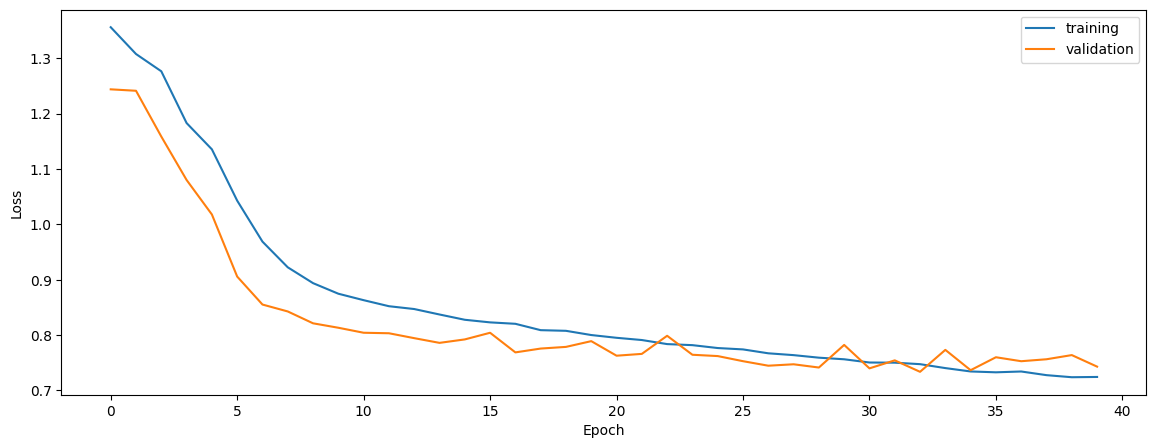

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7092737090273025
0.7121611445783133
0.6870228175035993


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.7092737090273025
0.7121611445783133
0.6870228175035993


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7071005917159763
0.7107492573440423
0.6822057987492893


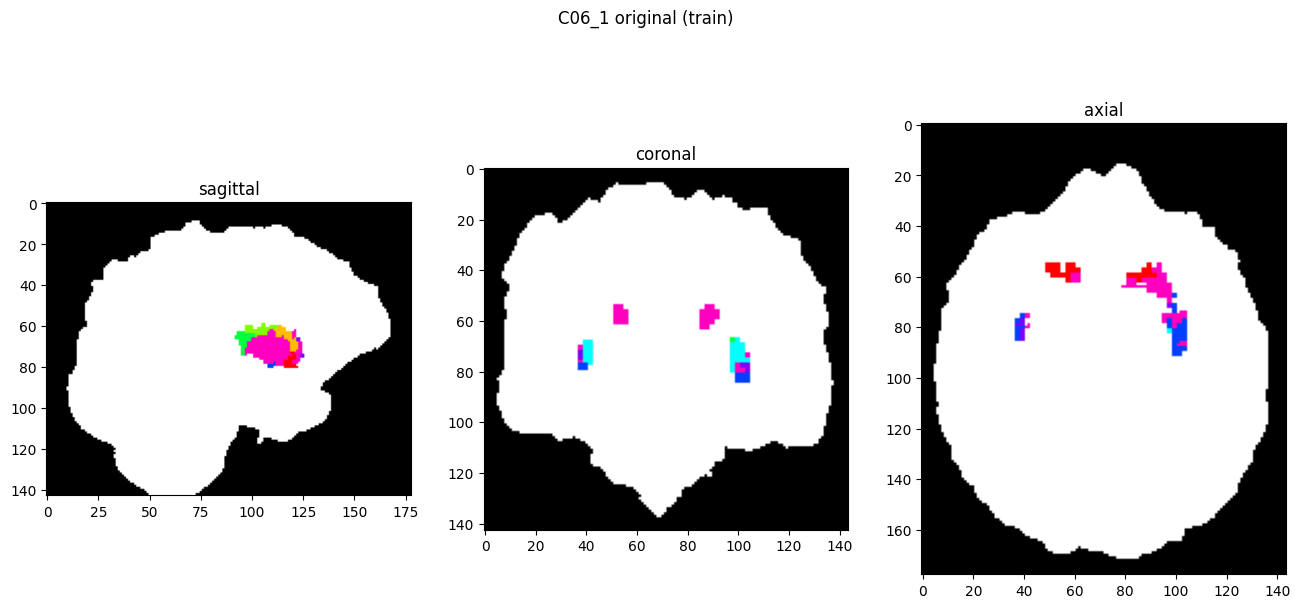

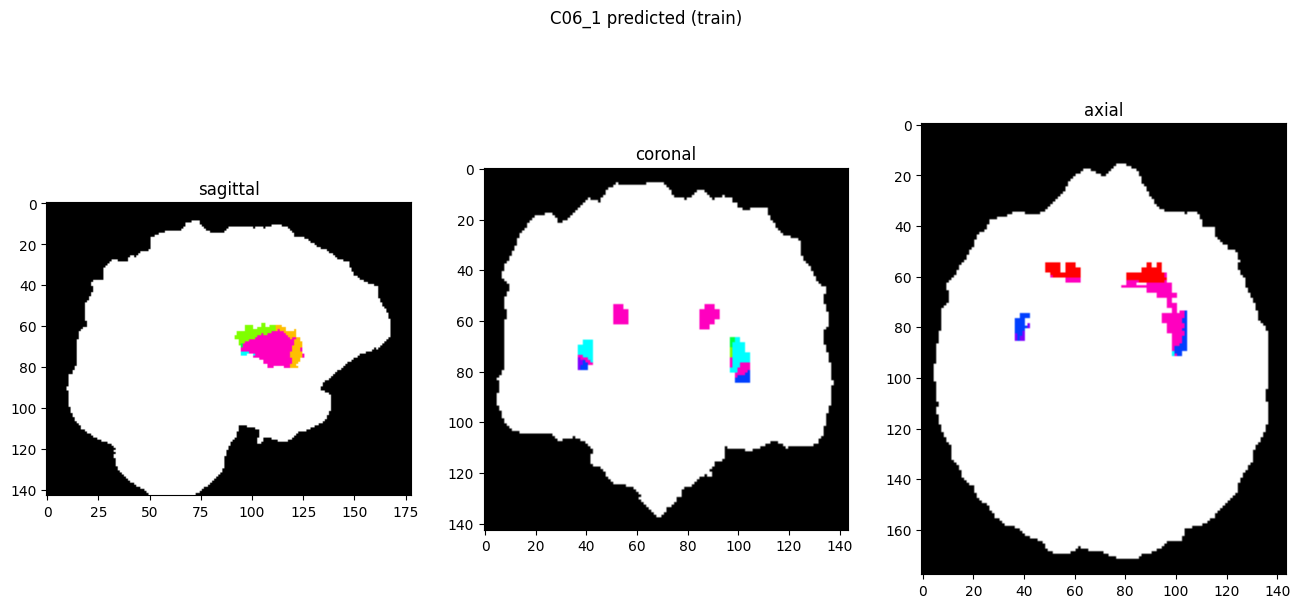

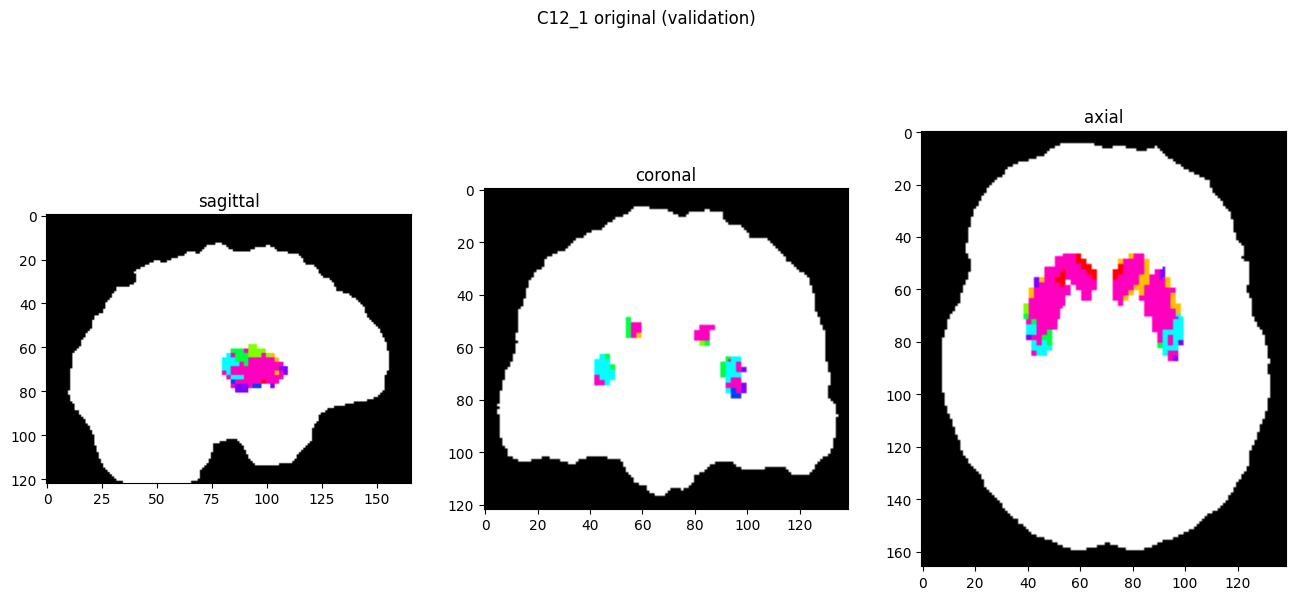

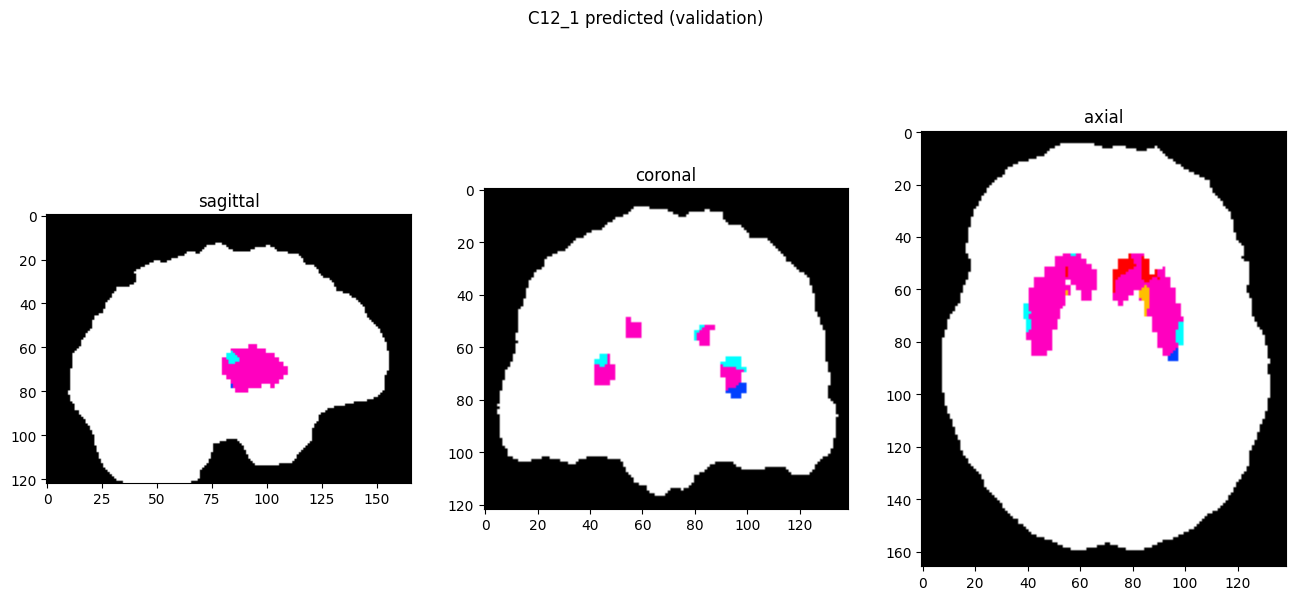

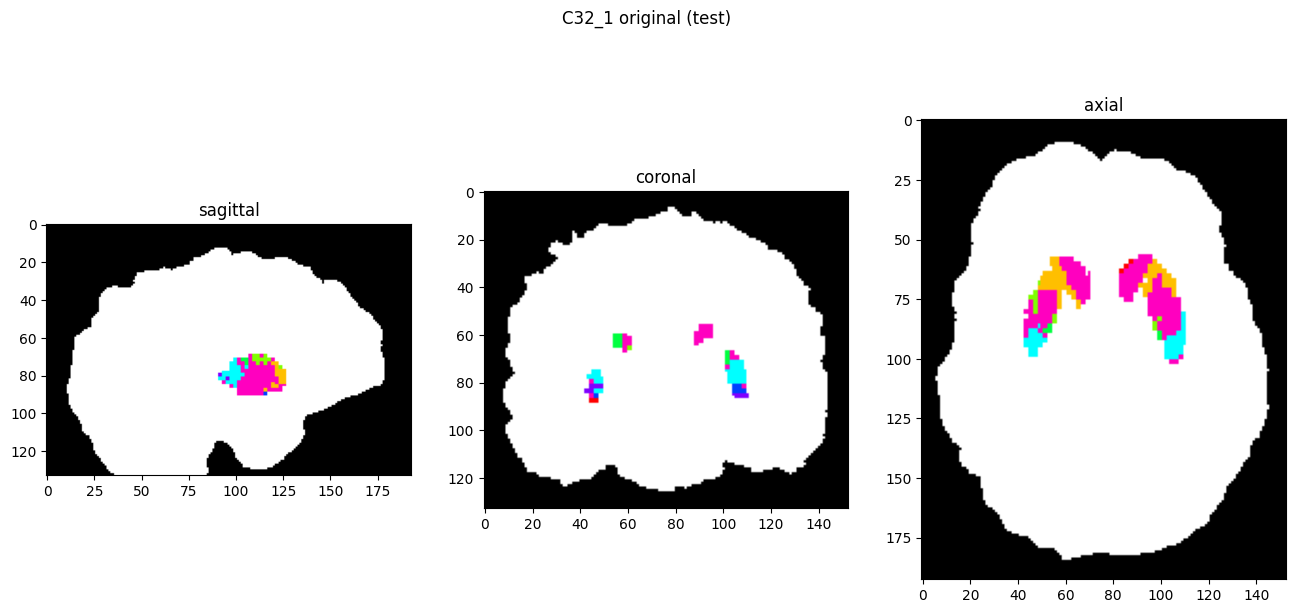

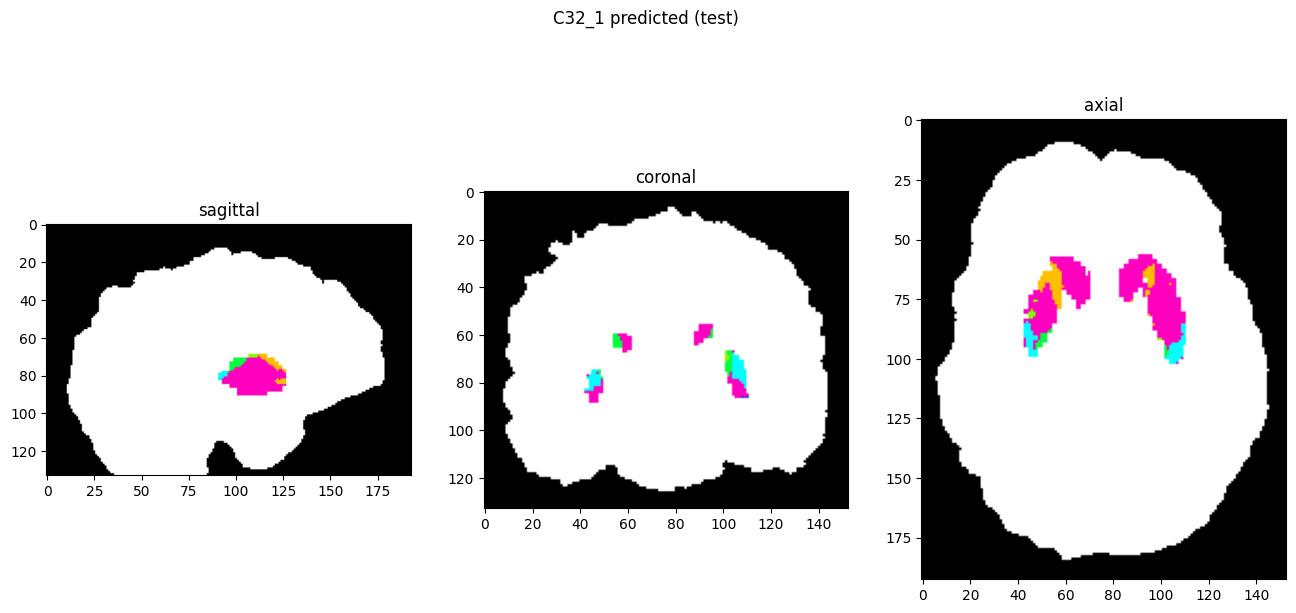

In [10]:
showResults(model, gen, threshold=0)